In [2]:
import importlib
import numpy as np
from matplotlib import pyplot as plt
import MEVeS as S
importlib.reload(S)
import AtomicConstants as AC
importlib.reload(AC)
import Optimiser as Opt
importlib.reload(Opt)
from scipy.optimize import curve_fit

In [3]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [4]:
FONT_SIZE = 11
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [5]:
def gaussian_fit(t, tw, A):
    return A*np.exp(-pow(t,2)/(2*pow(tw,2)))

# ORCA using telecom transition as control (check dephasing)

In [6]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}}}
atom = AC.Rb87(config)

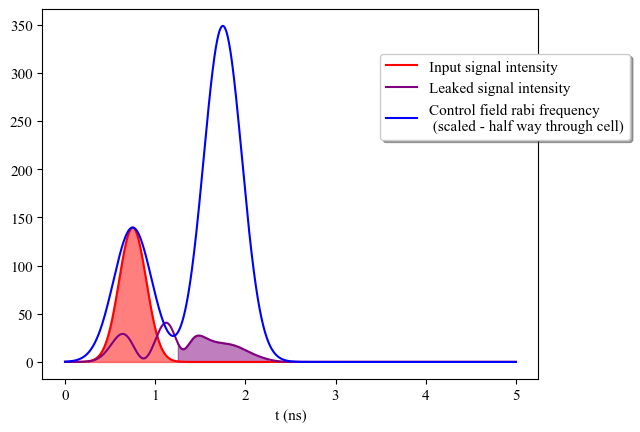

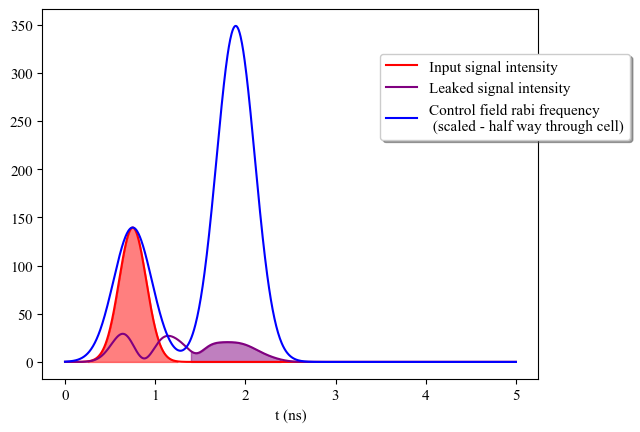

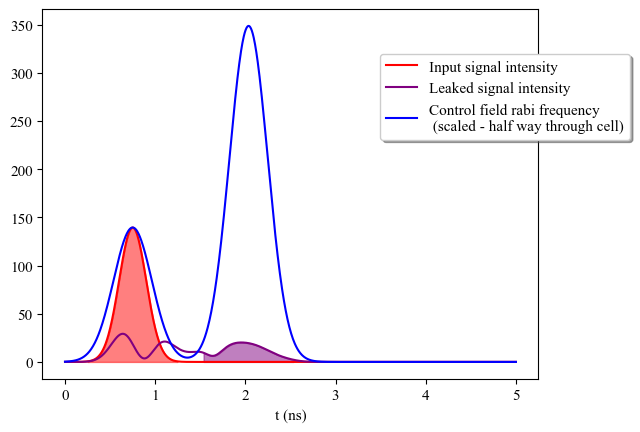

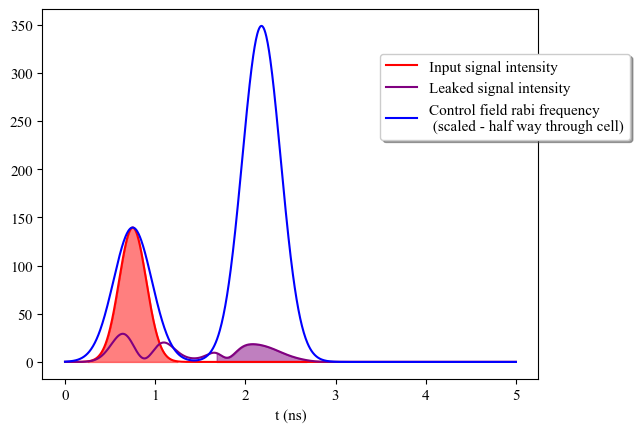

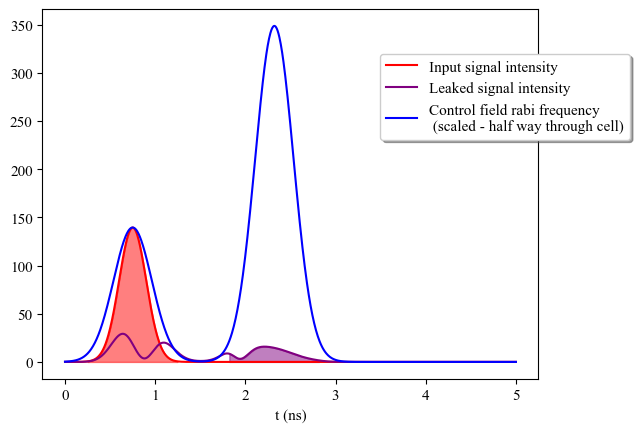

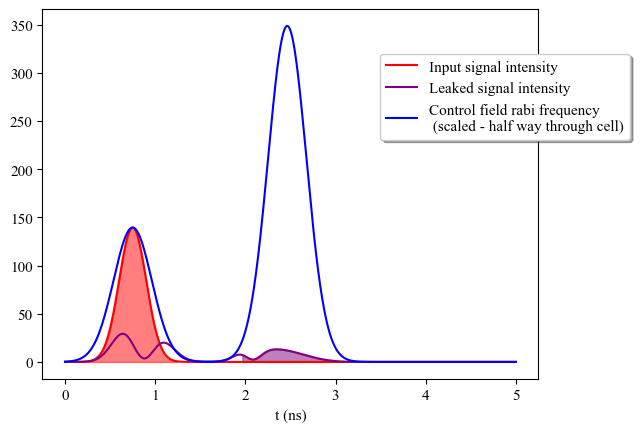

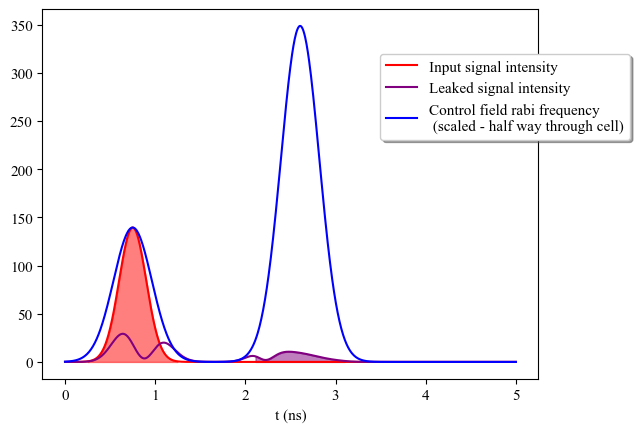

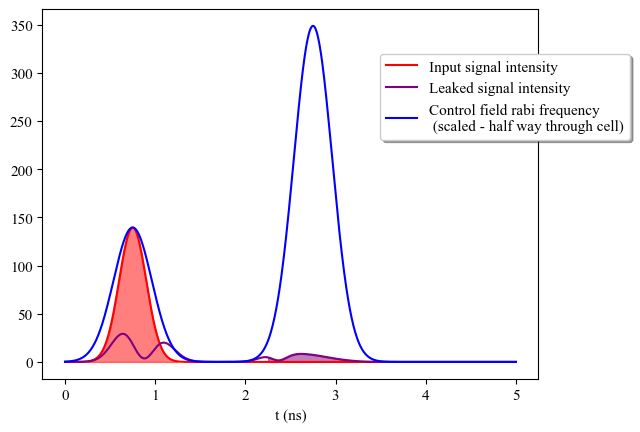

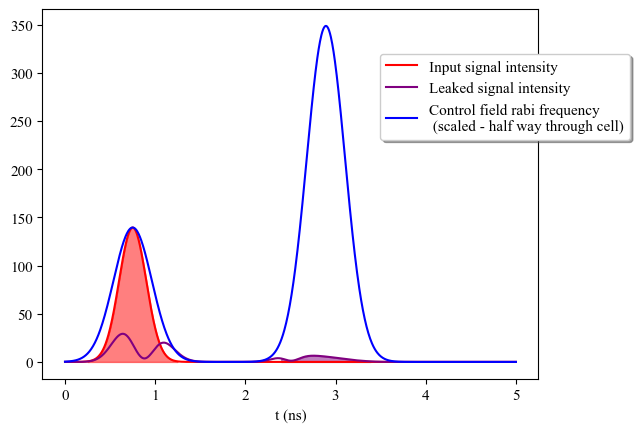

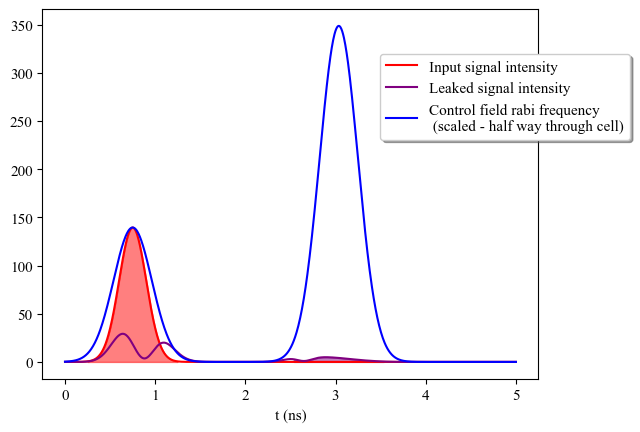

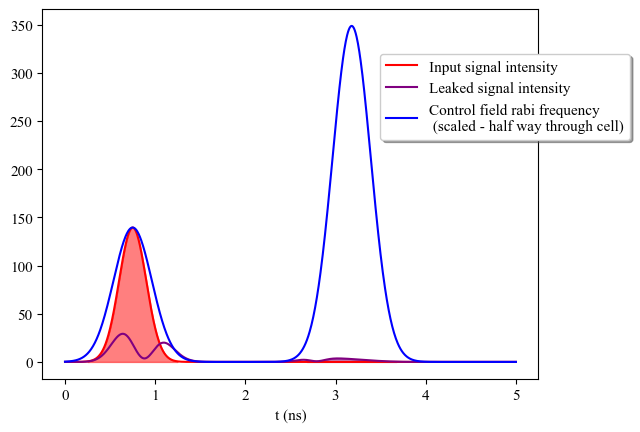

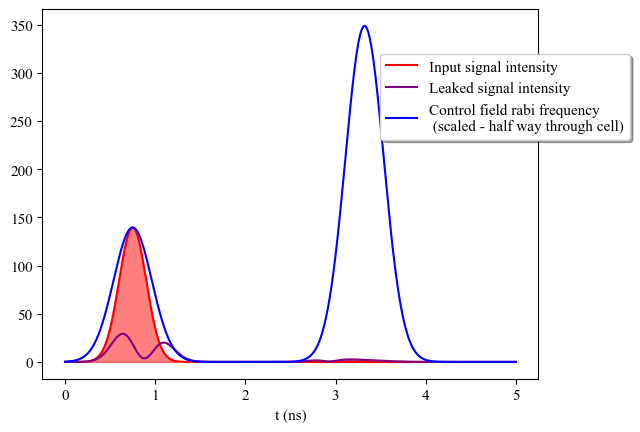

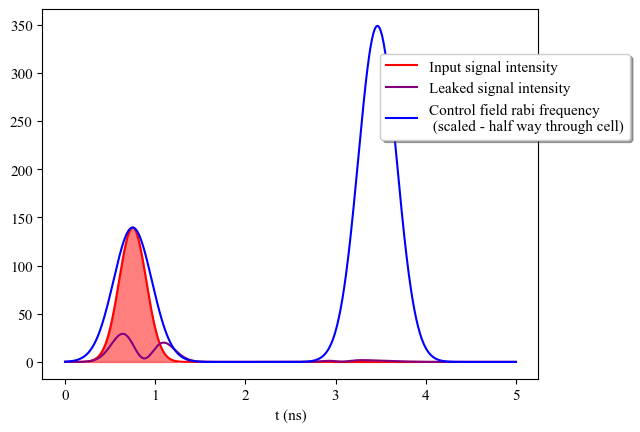

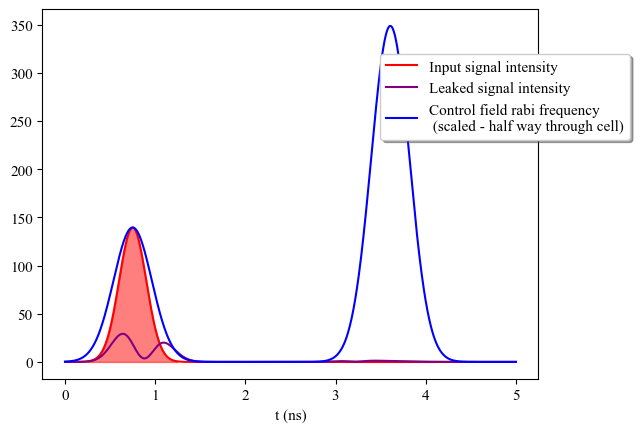

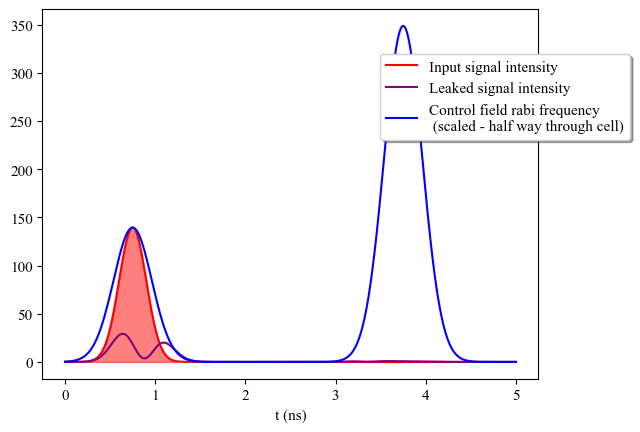

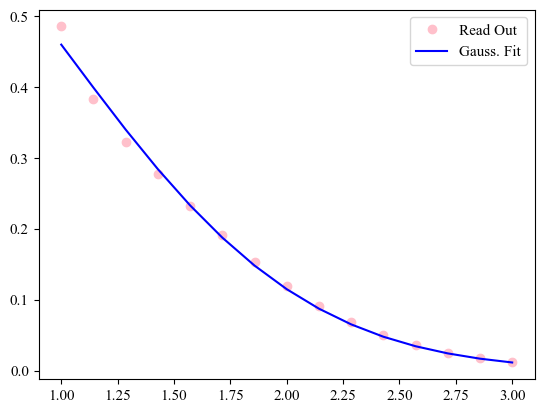

1/e time =  1.4702373986063912


In [7]:
protocol = 'ORCA'

# OD of the cell
OD = 10000 
#BW = 2*np.pi*1e9
# 1/e time of the pulse
tau = 0.5e-9
# number of spatial grid points
n = 50
# temperature of the cell
T = 273.15 + 50
# number velocity classes
vno = 30
# detuning of the control/signal field
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

# length of the cell
L = 0.13

t0 = 1.5*tau
tend = 5e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

# Initial signal field
photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]
# Initial atom field
Sinits = np.zeros((n, 1, 1, 1, 1, vno))

# Rabi freq.
Omega_store = 8e9
Omega_retrieve = 2e10

# Control field
control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)

tr_list = np.linspace(1e-9, 3e-9, 15)

retrieved_list = []

mcut = int((t0+2*tau)*m/(tend))

for tr in tr_list:

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
    # Line width of the excited state
    sol.gammaS = 1/84e-9 #1/480e-9
    sol.gammaSNU = sol.gammaS/sol.gamma

    Control_retrieve = S.gaussian(t, t0+tr, tau, Omega_retrieve)
    Control_tp = (Control_store + Control_retrieve)[:, None] * control_pol[None, :]
    Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

    sol.solve(Control_tzp, method='RK4-Ralston')

    readin_window = [t0-tau, t0+tau]
    #readout_window = [t0+tr-400e-12*gamma, t0+tr+100e-12*gamma]
    readout_window = [t0+tr-tau, t0+tr+tau]
    readin_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readin_window[0])),
                          min(range(len(t)), key=lambda i:abs(t[i]-readin_window[1]))]
    readout_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readout_window[0])),
                          min(range(len(t)), key=lambda i:abs(t[i]-readout_window[1]))]
    
    norm = np.trapz( pow(np.abs(sol.E[:, 0, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                    x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )
    
    stored = 1-np.trapz( pow(np.abs(sol.E[:, -1, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                    x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )/norm
    
    total = np.trapz( pow(np.abs(sol.E[:, -1, 0])[readout_window_index[0]:readout_window_index[1]], 2), 
                    x=sol.tpoints[readout_window_index[0]:readout_window_index[1]] )
    
    retrieved = total/stored
    
    retrieved_list.append(retrieved)
    # E field at all temporal grid points, spatial grid point 0, velocity grid point 0
    plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
    # E field at all temporal grid points, last spatial grid point, velocity grid point 0
    plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
    # Control readin and readout
    plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*Control_tp[:, 0], color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
    plt.fill_between(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), where=(t < readin_window[1]) & (t > readin_window[0]), 
                 alpha=0.5, color='red')
    plt.fill_between(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), where=(t < readout_window[1]) & (t > readout_window[0]), 
                 alpha=0.5, color='purple')
    plt.xlabel('t (ns)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
    plt.show()



fit_x = tr_list*1e9

parameters, covariance = curve_fit(gaussian_fit, fit_x, np.array(retrieved_list), p0=[0.5, 0.5])

fit_tw = parameters[0]
fit_A = parameters[1]
  
fit_y = gaussian_fit(fit_x, fit_tw, fit_A)

plt.plot(fit_x,  np.array(retrieved_list), 'o', label='Read Out', color='pink')
plt.plot(fit_x, fit_y, '-', label='Gauss. Fit', color='blue')
plt.xlabel('t (ns)')
plt.ylabel('Read Out')
plt.legend()
plt.show()

print("1/e time = ", np.sqrt(2)*parameters[0])

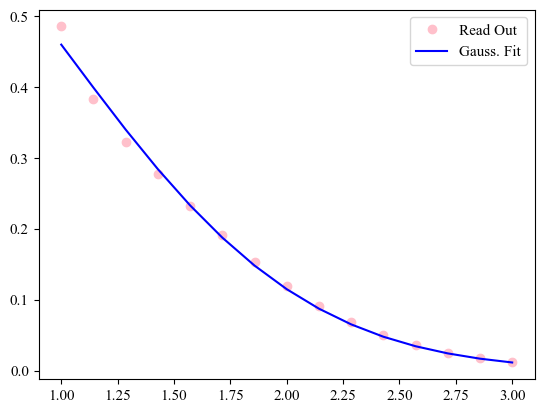

1/e time =  1.4702373986063912


In [9]:
fit_x = tr_list*1e9

parameters, covariance = curve_fit(gaussian_fit, fit_x, np.array(retrieved_list), p0=[0.5, 0.5])

fit_tw = parameters[0]
fit_A = parameters[1]
  
fit_y = gaussian_fit(fit_x, fit_tw, fit_A)

plt.plot(fit_x,  np.array(retrieved_list), 'o', label='Read Out', color='pink')
plt.plot(fit_x, fit_y, '-', label='Gauss. Fit', color='blue')
plt.legend()
plt.show()

print("1/e time = ", np.sqrt(2)*parameters[0])

## Vary pulse energy as Thomas et al. (2023)

In [5]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}}}
atom = AC.Rb87(config)

In [6]:
kB = 1.38e-23 
hbar = 1.05457182e-34
eps0 = 8.8541878128e-12
c = 299792458

def pV(T):
    """ Vapour pressure of Cs as a function of temperature (K) """
    # liquid phase, T>25C
    return pow(10, 8.22127 - 4006.048/T - 0.00060194*T - 0.19623*np.log10(T))

def Nv(T):
    """ Number density as a function of temperature (K) """
    return 133.323*pV(T)/(kB*T)

In [7]:
def optical_depth(atom, T, L):
    cross_section = pow(atom.reduced_dipoles[0], 2)*atom.angular_frequencies[0]/(atom.decay_rates[0]*eps0*hbar*c)
    OD = Nv(T)*L*cross_section
    return OD

def effective_optical_depth(atom, OD, T):
    width = np.sqrt(kB*T/(atom.mass*pow(c, 2)))*atom.angular_frequencies[0]
    ODdash = OD*atom.decay_rates[0]/(2*width) * np.sqrt(np.pi*np.log(2))
    return ODdash

In [21]:
T = 273.15 + 100
L = 0.075
OD_factor = 0.4567

OD = OD_factor*optical_depth(atom, T, L)
ODdash = effective_optical_depth(atom, OD, T)

print(OD)
print(ODdash)

147045.57502097153
2718.105133372939


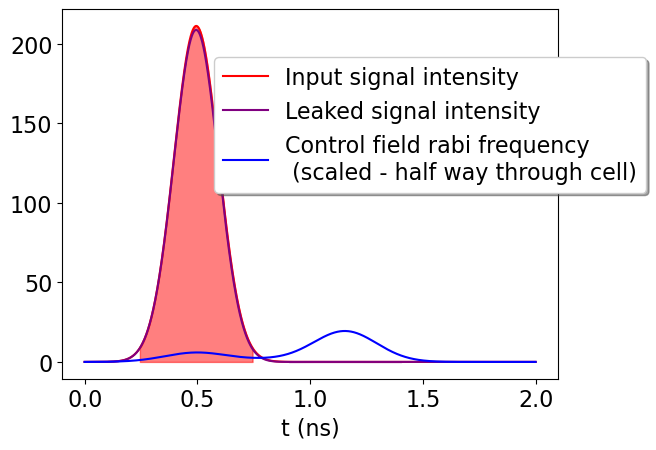

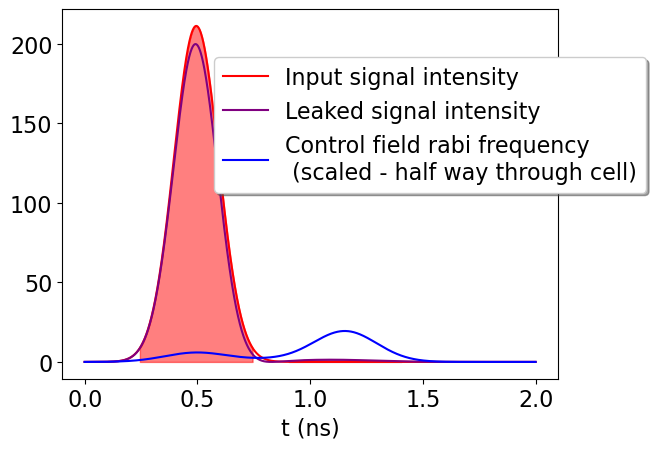

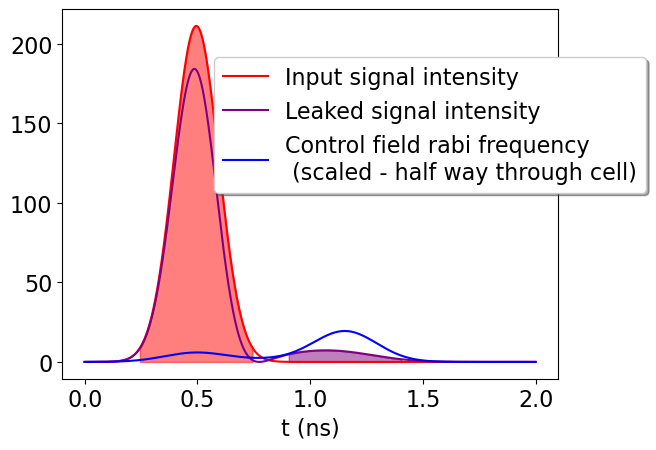

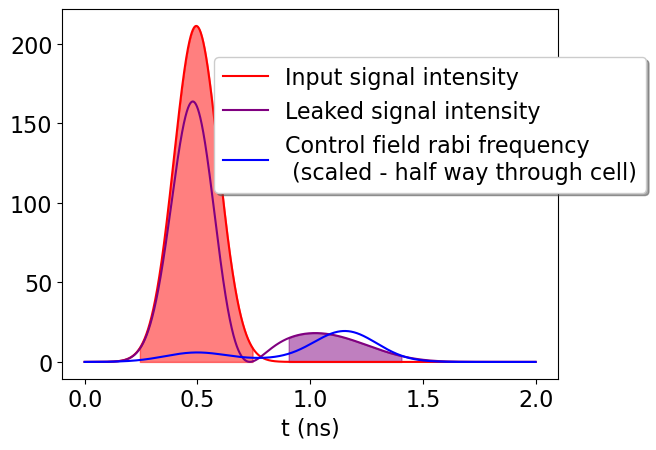

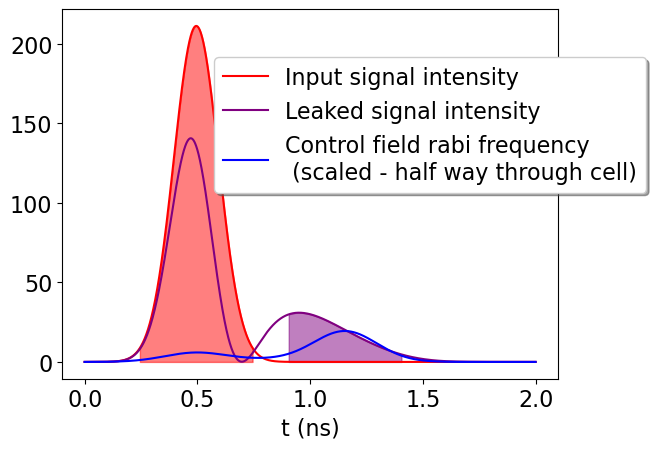

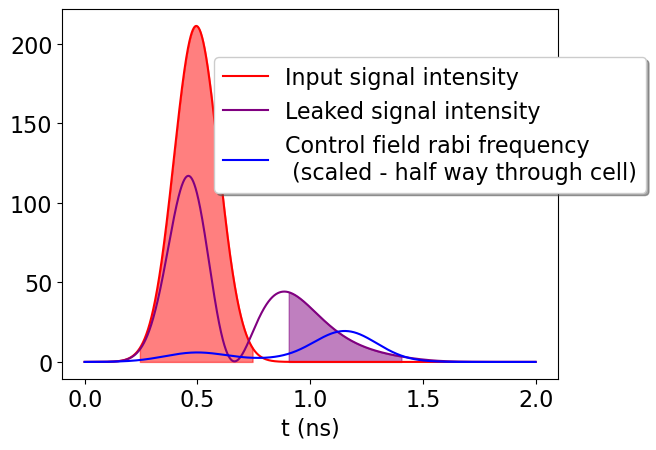

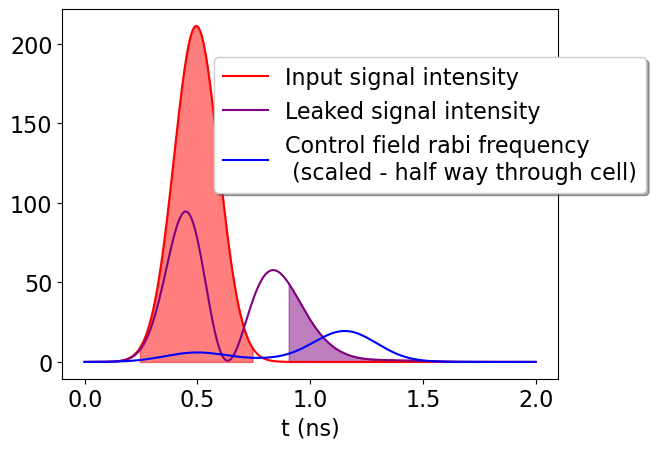

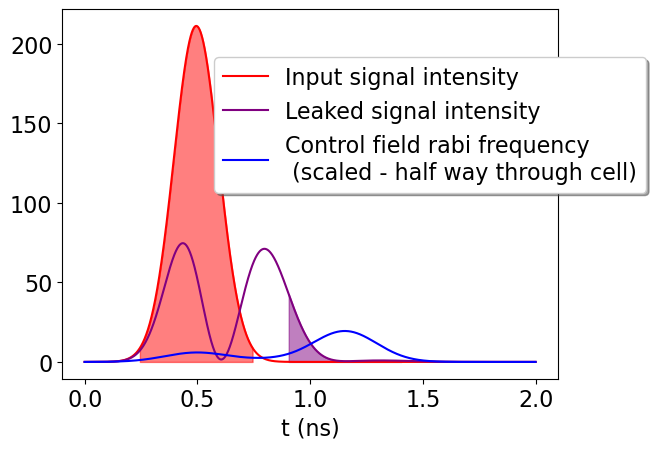

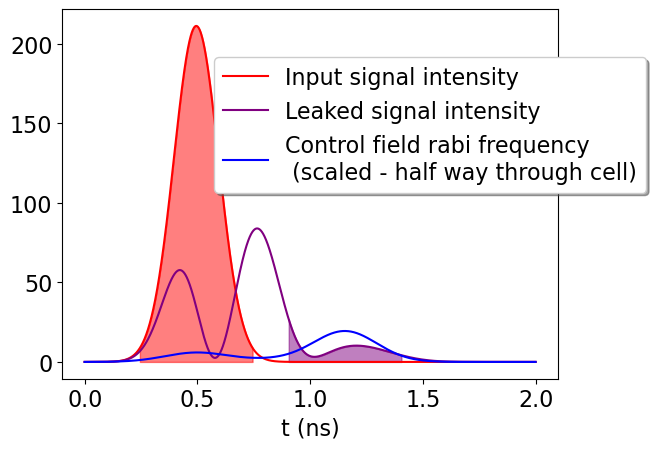

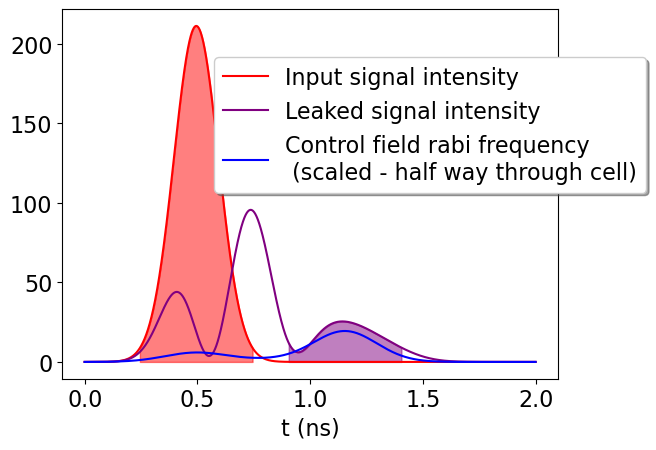

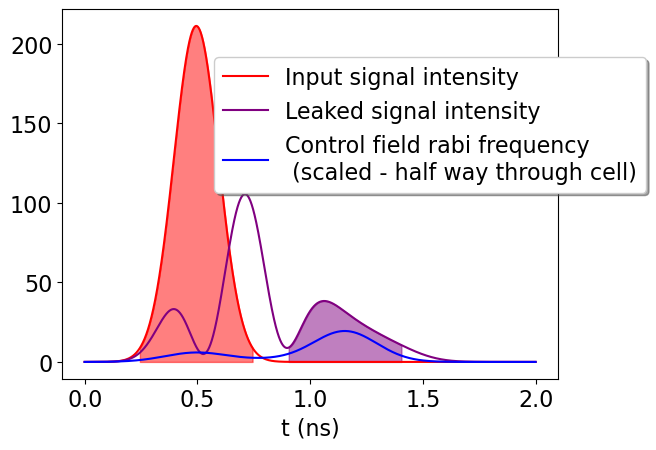

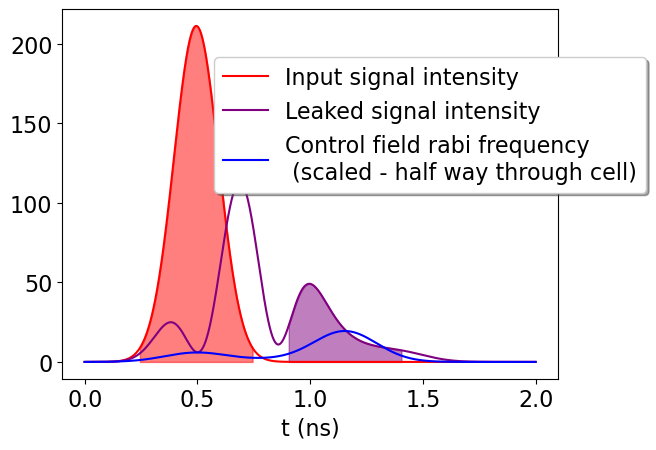

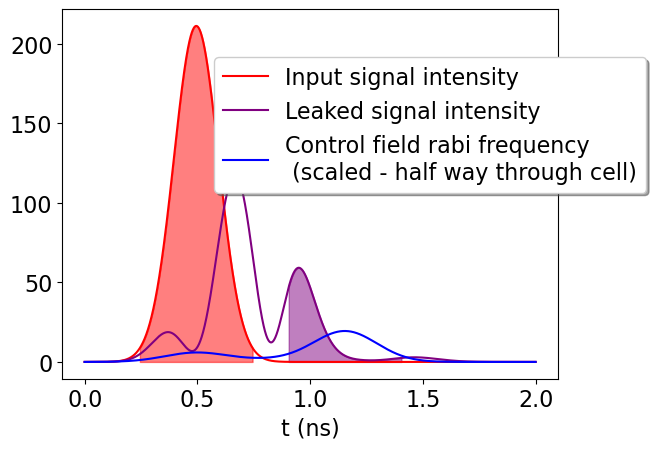

In [25]:
protocol = 'ORCA'
OD_factor = 0.4567
control_factor = 1/6

T = 273.15 + 100
L = 0.075

OD = 10000 #OD_factor*optical_depth(atom, T, L)

tau = 330e-12
n = 75

vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

t0 = 1.5*tau
tend = 2e-9
tbounds = np.array([0, tend])

m = 4000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))


control_pol = np.array([1, 0])


Omega_list = 2*np.pi*1e9 * np.linspace(0.5, 10, 13)
R = 3.3 # ratio of retireval control pulse energy to storage control pulse energy

tr = 660e-12
tw = 500e-12

readin_list = []
readout_list = []
energy_list_store = []
energy_list_retrieve = []

for Omega in Omega_list:

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
    sol.gammaS = 1/84e-9
    sol.gammaSNU = sol.gammaS/sol.gamma

    Control_store = np.sqrt(S.gaussian(t, t0, tau, Omega**2))
    Control_retrieve = np.sqrt(S.gaussian(t, t0+tr, tau, R*Omega**2))
    energy_list_store.append(atom.control_pulse_to_energy(Control_store, t, r=110e-6, index=0))
    energy_list_retrieve.append(atom.control_pulse_to_energy(Control_retrieve, t, r=110e-6, index=0))

    Control_tp = ((Control_store + Control_retrieve)*control_factor)[:, None] * control_pol[None, :]
    Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

    sol.solve(Control_tzp, method='RK4-Ralston')

    readin_window = [t0-tw/2, t0+tw/2]
    #readout_window = [t0+tr-400e-12*gamma, t0+tr+100e-12*gamma]
    readout_window = [t0+tr-tw/2, t0+tr+tw/2]
    readin_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readin_window[0])),
                          min(range(len(t)), key=lambda i:abs(t[i]-readin_window[1]))]
    readout_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readout_window[0])),
                          min(range(len(t)), key=lambda i:abs(t[i]-readout_window[1]))]
    
    norm = np.trapz( pow(np.abs(sol.E[:, 0, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                    x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )
    
    stored = 1-np.trapz( pow(np.abs(sol.E[:, -1, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                    x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )/norm
    
    total = np.trapz( pow(np.abs(sol.E[:, -1, 0])[readout_window_index[0]:readout_window_index[1]], 2), 
                    x=sol.tpoints[readout_window_index[0]:readout_window_index[1]] )
    
    retrieved = total/stored
    
    readin_list.append(stored)
    readout_list.append(total)

    plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
    plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
    plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega**2)*pow(Control_tp[:, 0],2), color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
    plt.fill_between(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), where=(t < readin_window[1]) & (t > readin_window[0]), 
                 alpha=0.5, color='red')
    plt.fill_between(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), where=(t < readout_window[1]) & (t > readout_window[0]), 
                 alpha=0.5, color='purple')
    plt.xlabel('t (ns)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
    plt.show()

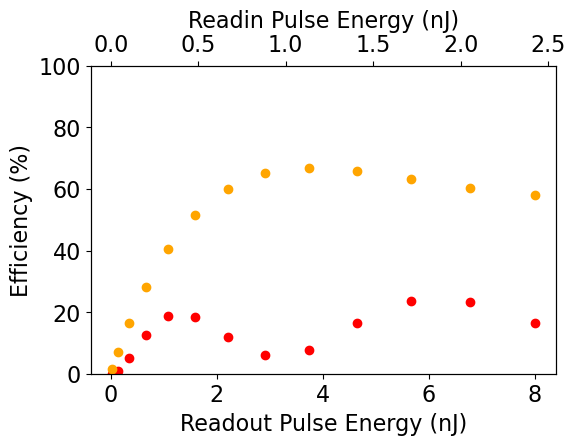

In [26]:
# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))


#ax1.scatter(np.array(energy_list_retrieve)*1e9, np.array(readin_list)*100)
ax1.scatter(np.array(energy_list_retrieve)*1e9, np.array(readout_list)*100, color='red')
ax1.set_xlabel('Readout Pulse Energy (nJ)')
ax1.set_ylabel('Efficiency (%)')
ax1.set_ylim(0, 100)


# Creating a second x-axis for readin energy
ax2 = ax1.twiny()
ax2.scatter(np.array(energy_list_store)*1e9, np.array(readin_list)*100, color='orange')
ax2.set_xlabel('Readin Pulse Energy (nJ)')

# Show the plot
plt.show()

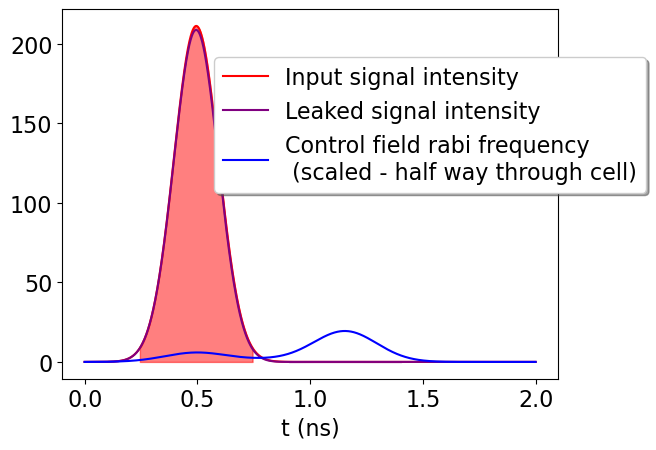

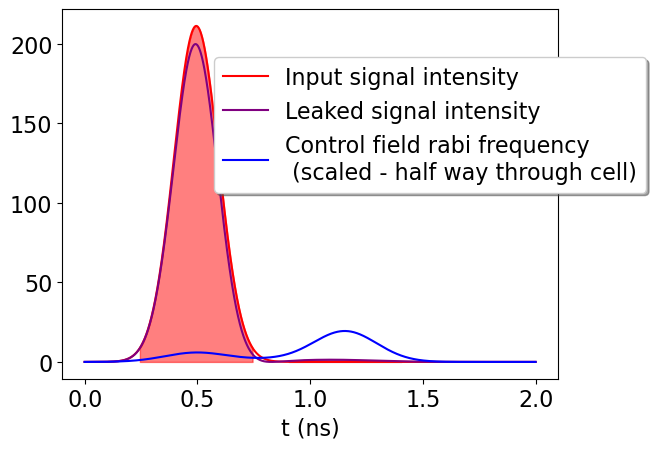

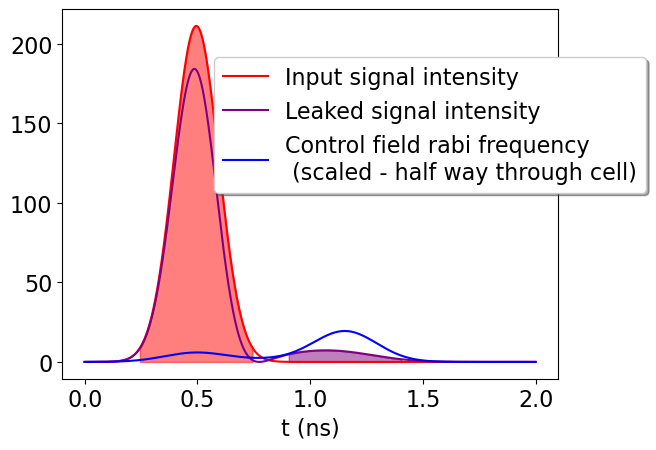

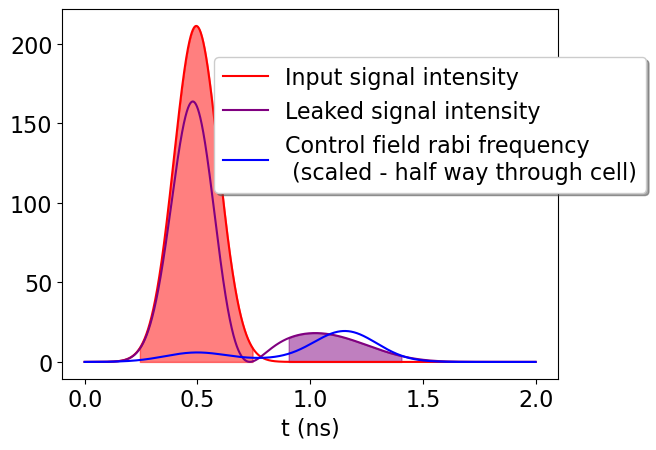

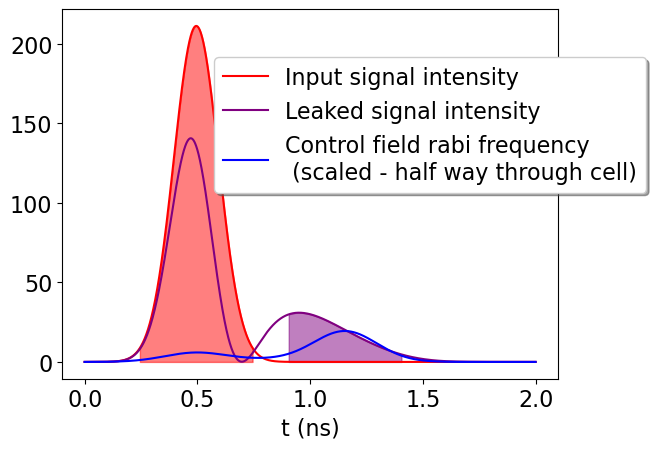

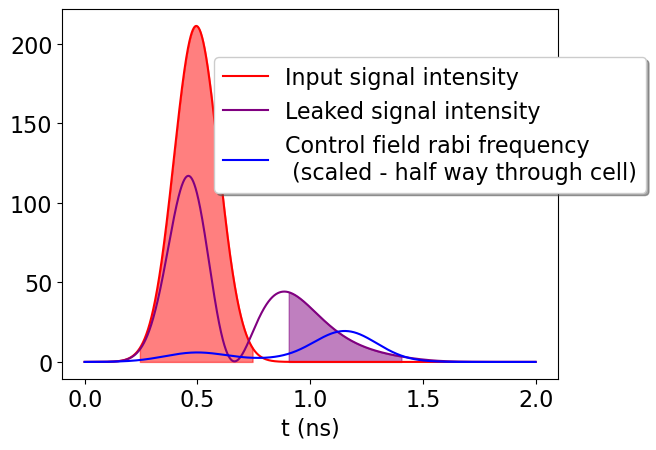

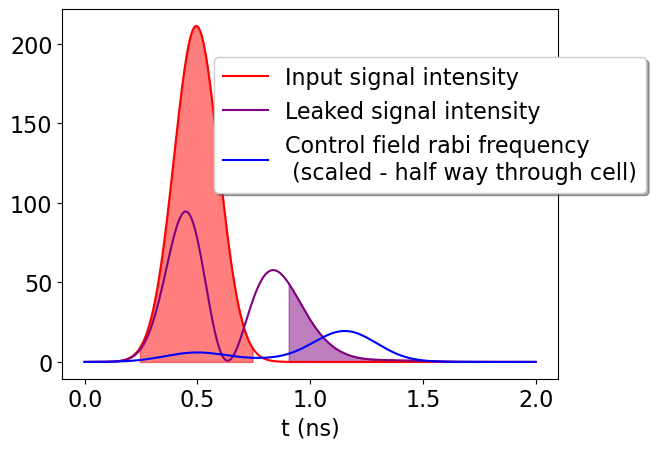

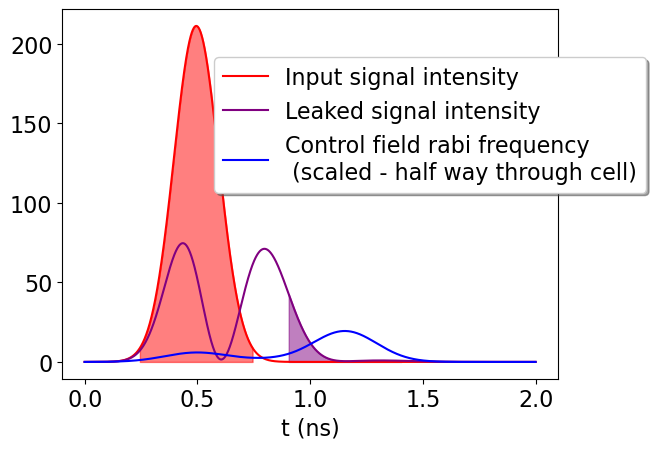

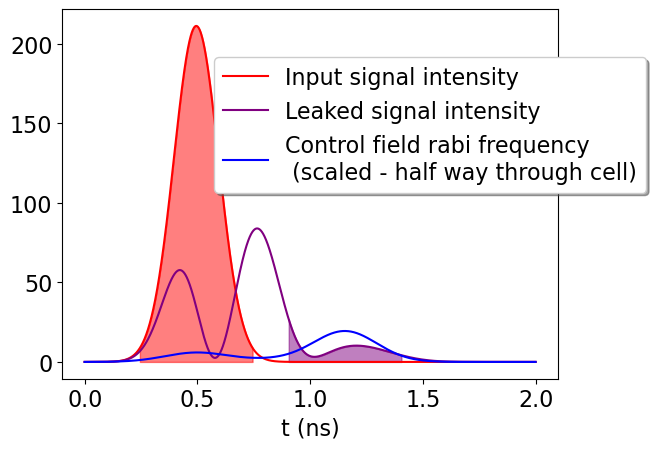

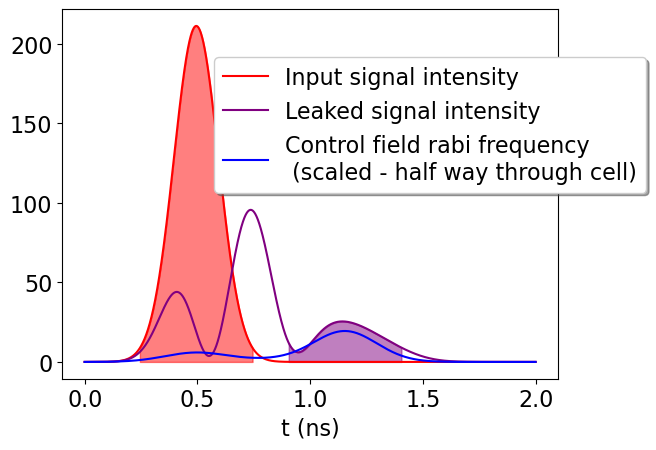

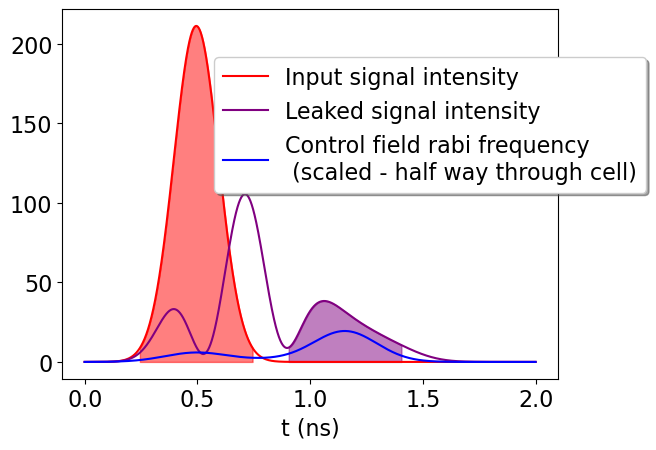

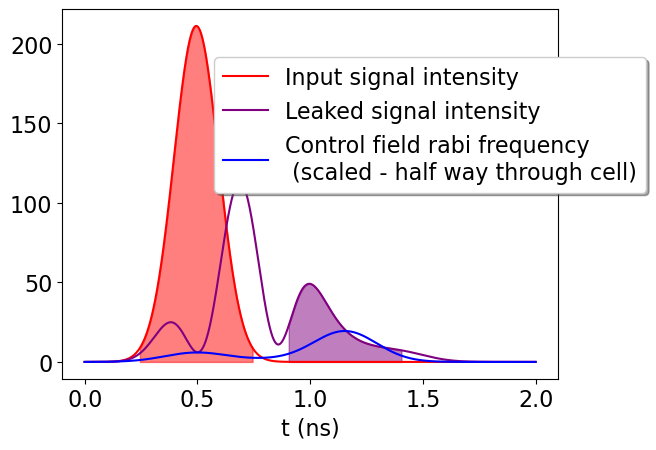

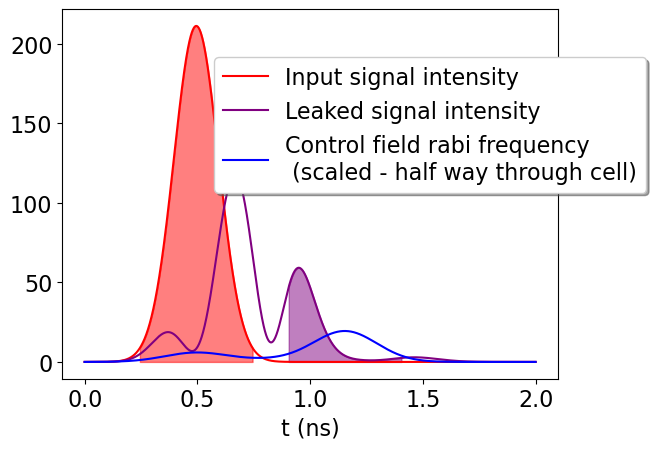

In [27]:
protocol = 'ORCA'
OD_factor = 0.4567
control_factor = 1/6

T = 273.15 + 100
L = 0.075

OD = 10000 #OD_factor*optical_depth(atom, T, L)

tau = 330e-12
n = 75

vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

t0 = 1.5*tau
tend = 2e-9
tbounds = np.array([0, tend])

m = 4000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))


control_pol = np.array([1, 0])


Omega_list = 2*np.pi*1e9 * np.linspace(0.5, 10, 13)
R = 3.3 # ratio of retireval control pulse energy to storage control pulse energy

tr = 660e-12
tw = 500e-12

readin_list = []
readout_list = []
energy_list_store = []
energy_list_retrieve = []

for Omega in Omega_list:

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
    sol.gammaS = 1/84e-9
    sol.gammaSNU = sol.gammaS/sol.gamma

    Control_store = np.sqrt(S.gaussian(t, t0, tau, Omega**2))
    Control_retrieve = np.sqrt(S.gaussian(t, t0+tr, tau, R*Omega**2))
    energy_list_store.append(atom.control_pulse_to_energy(Control_store, t, r=200e-6, index=0))
    energy_list_retrieve.append(atom.control_pulse_to_energy(Control_retrieve, t, r=200e-6, index=0))

    Control_tp = ((Control_store + Control_retrieve)*control_factor)[:, None] * control_pol[None, :]
    Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

    sol.solve(Control_tzp, method='RK4-Ralston')

    readin_window = [t0-tw/2, t0+tw/2]
    #readout_window = [t0+tr-400e-12*gamma, t0+tr+100e-12*gamma]
    readout_window = [t0+tr-tw/2, t0+tr+tw/2]
    readin_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readin_window[0])),
                          min(range(len(t)), key=lambda i:abs(t[i]-readin_window[1]))]
    readout_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readout_window[0])),
                          min(range(len(t)), key=lambda i:abs(t[i]-readout_window[1]))]
    
    norm = np.trapz( pow(np.abs(sol.E[:, 0, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                    x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )
    
    stored = 1-np.trapz( pow(np.abs(sol.E[:, -1, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                    x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )/norm
    
    total = np.trapz( pow(np.abs(sol.E[:, -1, 0])[readout_window_index[0]:readout_window_index[1]], 2), 
                    x=sol.tpoints[readout_window_index[0]:readout_window_index[1]] )
    
    retrieved = total/stored
    
    readin_list.append(stored)
    readout_list.append(total)

    plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
    plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
    plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega**2)*pow(Control_tp[:, 0],2), color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
    plt.fill_between(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), where=(t < readin_window[1]) & (t > readin_window[0]), 
                 alpha=0.5, color='red')
    plt.fill_between(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), where=(t < readout_window[1]) & (t > readout_window[0]), 
                 alpha=0.5, color='purple')
    plt.xlabel('t (ns)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
    plt.show()

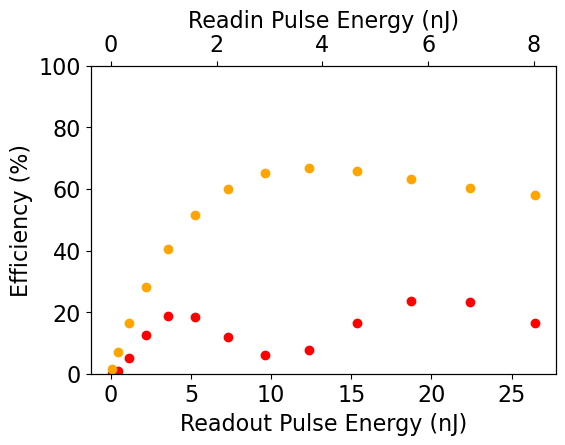

In [28]:
# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))


#ax1.scatter(np.array(energy_list_retrieve)*1e9, np.array(readin_list)*100)
ax1.scatter(np.array(energy_list_retrieve)*1e9, np.array(readout_list)*100, color='red')
ax1.set_xlabel('Readout Pulse Energy (nJ)')
ax1.set_ylabel('Efficiency (%)')
ax1.set_ylim(0, 100)


# Creating a second x-axis for readin energy
ax2 = ax1.twiny()
ax2.scatter(np.array(energy_list_store)*1e9, np.array(readin_list)*100, color='orange')
ax2.set_xlabel('Readin Pulse Energy (nJ)')

# Show the plot
plt.show()

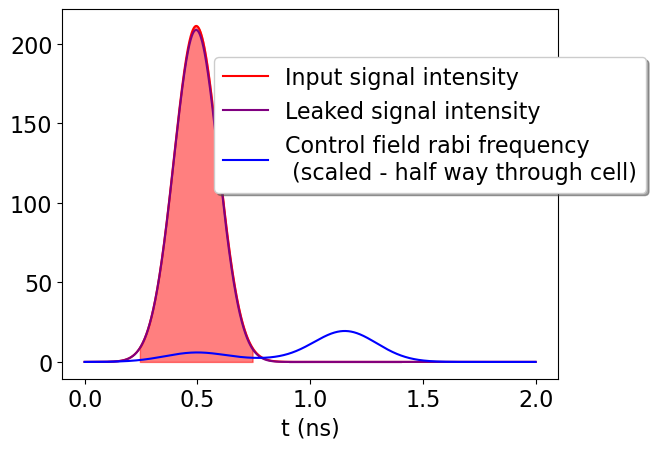

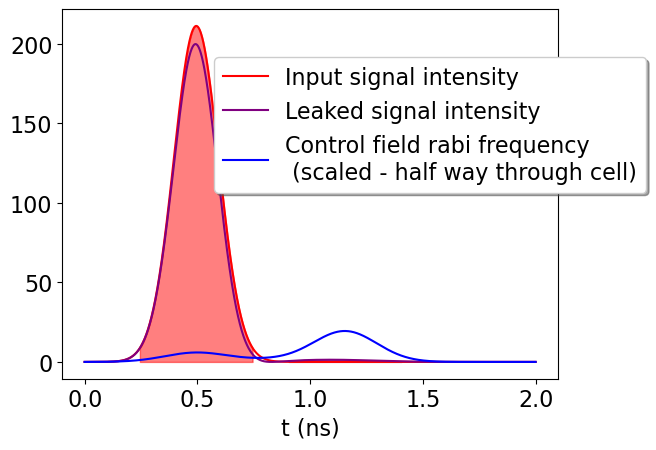

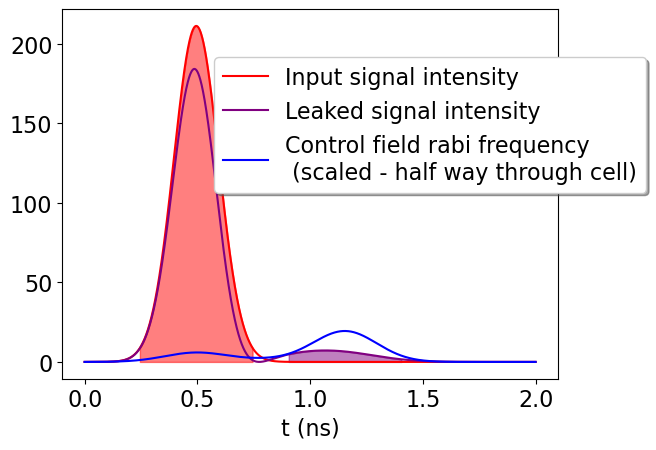

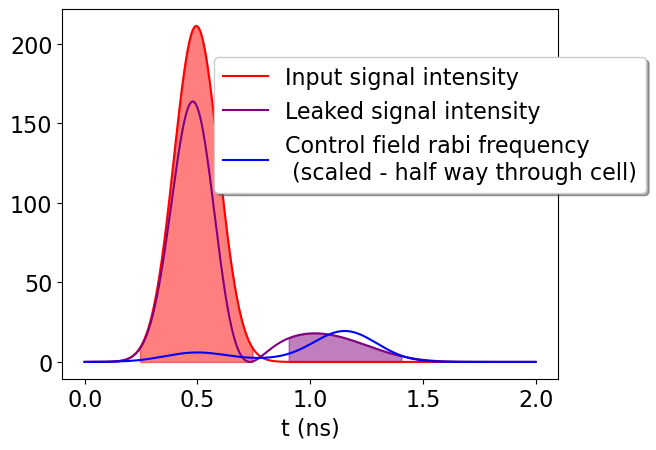

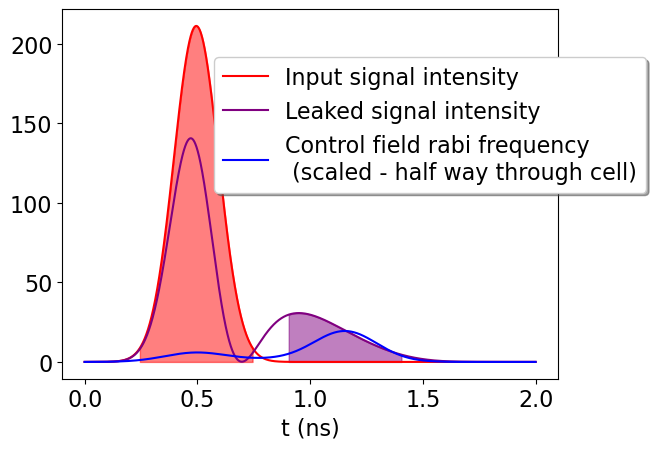

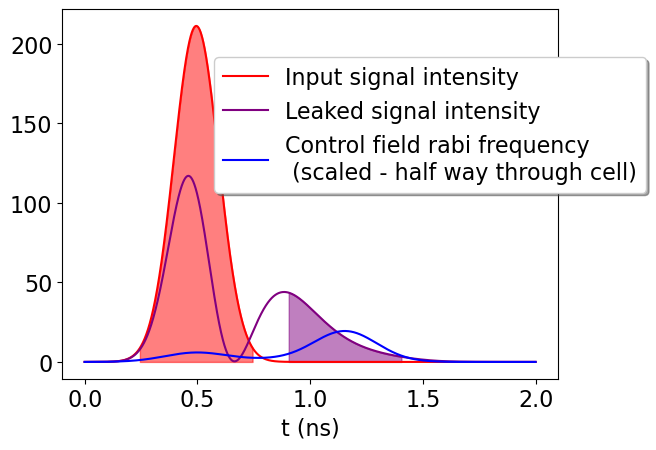

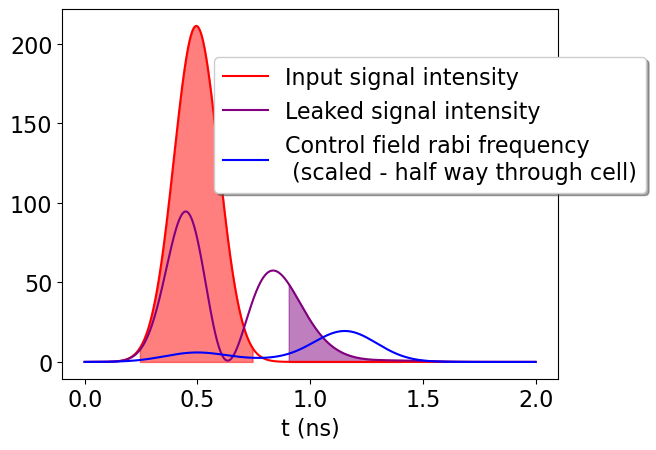

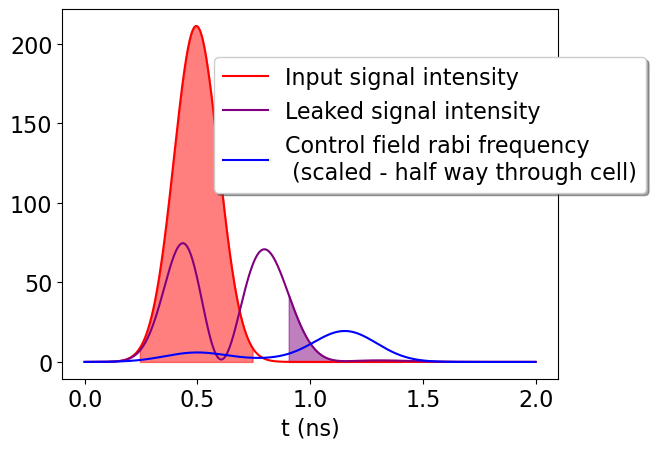

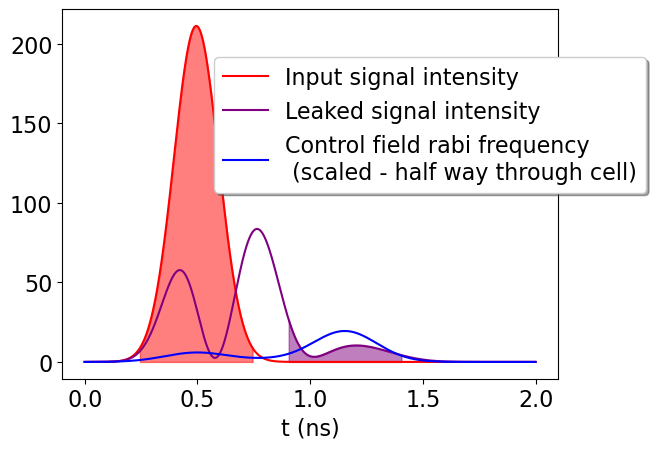

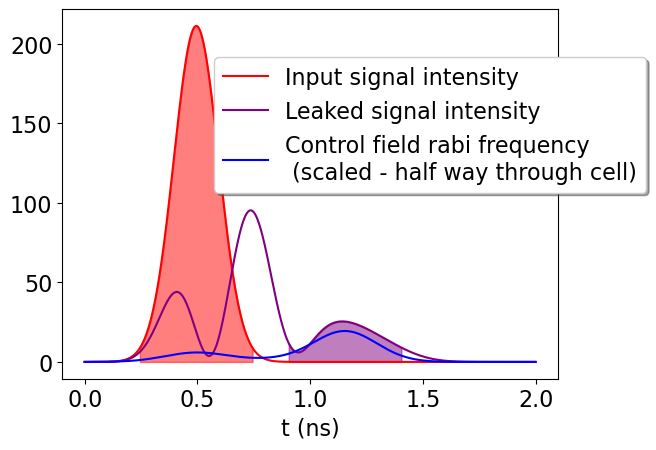

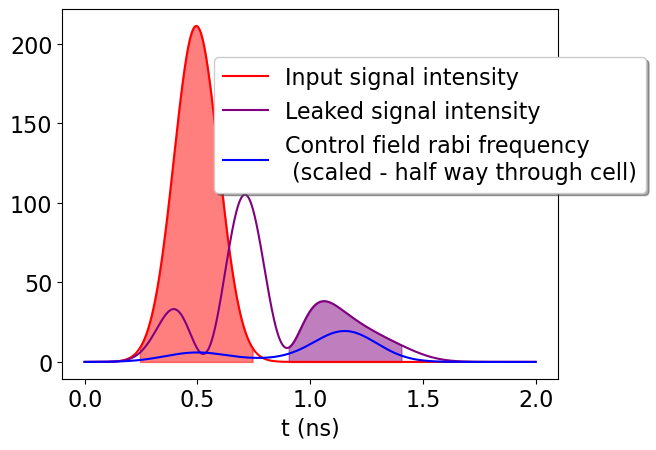

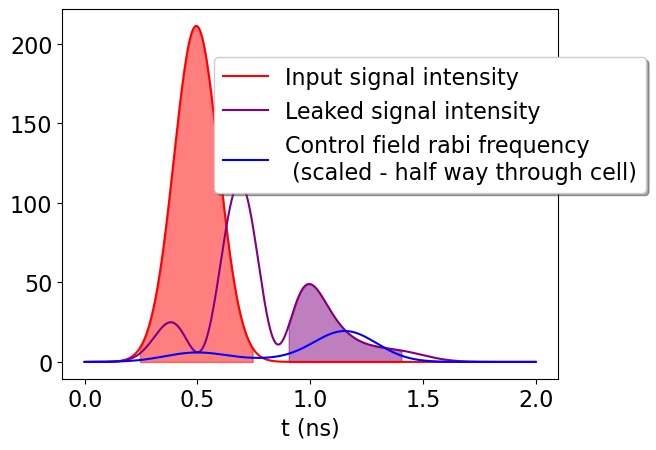

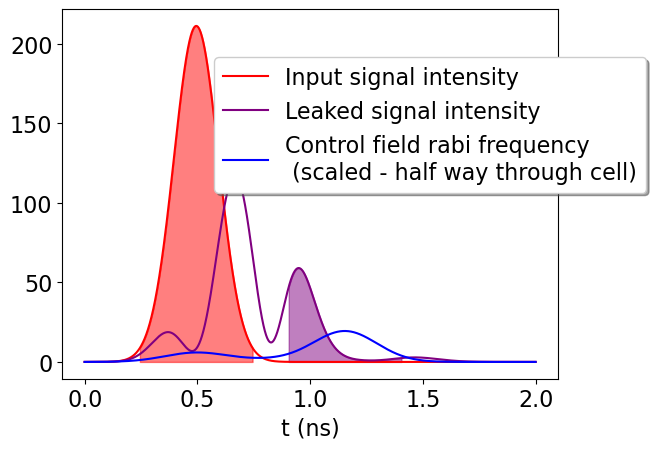

In [29]:
protocol = 'ORCA'
OD_factor = 0.4567
control_factor = 1/6

T = 273.15 + 120
L = 0.075

OD = 10000 #OD_factor*optical_depth(atom, T, L)

tau = 330e-12
n = 75

vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

t0 = 1.5*tau
tend = 2e-9
tbounds = np.array([0, tend])

m = 4000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))


control_pol = np.array([1, 0])


Omega_list = 2*np.pi*1e9 * np.linspace(0.5, 10, 13)
R = 3.3 # ratio of retireval control pulse energy to storage control pulse energy

tr = 660e-12
tw = 500e-12

readin_list = []
readout_list = []
energy_list_store = []
energy_list_retrieve = []

for Omega in Omega_list:

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
    sol.gammaS = 1/84e-9
    sol.gammaSNU = sol.gammaS/sol.gamma

    Control_store = np.sqrt(S.gaussian(t, t0, tau, Omega**2))
    Control_retrieve = np.sqrt(S.gaussian(t, t0+tr, tau, R*Omega**2))
    energy_list_store.append(atom.control_pulse_to_energy(Control_store, t, r=200e-6, index=0))
    energy_list_retrieve.append(atom.control_pulse_to_energy(Control_retrieve, t, r=200e-6, index=0))

    Control_tp = ((Control_store + Control_retrieve)*control_factor)[:, None] * control_pol[None, :]
    Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

    sol.solve(Control_tzp, method='RK4-Ralston')

    readin_window = [t0-tw/2, t0+tw/2]
    #readout_window = [t0+tr-400e-12*gamma, t0+tr+100e-12*gamma]
    readout_window = [t0+tr-tw/2, t0+tr+tw/2]
    readin_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readin_window[0])),
                          min(range(len(t)), key=lambda i:abs(t[i]-readin_window[1]))]
    readout_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readout_window[0])),
                          min(range(len(t)), key=lambda i:abs(t[i]-readout_window[1]))]
    
    norm = np.trapz( pow(np.abs(sol.E[:, 0, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                    x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )
    
    stored = 1-np.trapz( pow(np.abs(sol.E[:, -1, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                    x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )/norm
    
    total = np.trapz( pow(np.abs(sol.E[:, -1, 0])[readout_window_index[0]:readout_window_index[1]], 2), 
                    x=sol.tpoints[readout_window_index[0]:readout_window_index[1]] )
    
    retrieved = total/stored
    
    readin_list.append(stored)
    readout_list.append(total)

    plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
    plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
    plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega**2)*pow(Control_tp[:, 0],2), color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
    plt.fill_between(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), where=(t < readin_window[1]) & (t > readin_window[0]), 
                 alpha=0.5, color='red')
    plt.fill_between(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), where=(t < readout_window[1]) & (t > readout_window[0]), 
                 alpha=0.5, color='purple')
    plt.xlabel('t (ns)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
    plt.show()

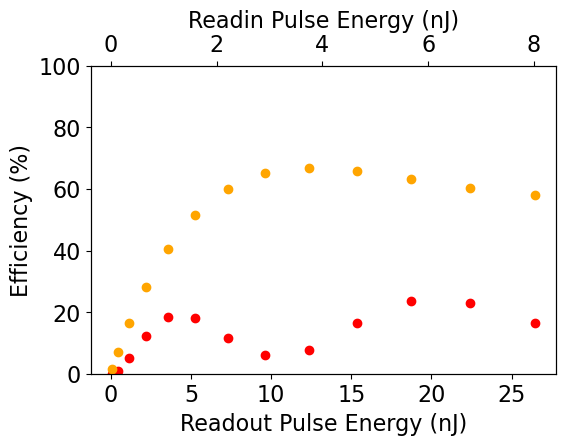

In [30]:
# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))


#ax1.scatter(np.array(energy_list_retrieve)*1e9, np.array(readin_list)*100)
ax1.scatter(np.array(energy_list_retrieve)*1e9, np.array(readout_list)*100, color='red')
ax1.set_xlabel('Readout Pulse Energy (nJ)')
ax1.set_ylabel('Efficiency (%)')
ax1.set_ylim(0, 100)


# Creating a second x-axis for readin energy
ax2 = ax1.twiny()
ax2.scatter(np.array(energy_list_store)*1e9, np.array(readin_list)*100, color='orange')
ax2.set_xlabel('Readin Pulse Energy (nJ)')

# Show the plot
plt.show()

# Choose t=3ns, can we map to intermediate state efficiently, while no light escapes?

In [66]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}, "intermediate2": {"n" : 5, "L": 1, "J" : 3/2}, 
                                                    "storage2": {"n" : 5, "L": 0, "F": 1}}}
atom = AC.Rb87(config)

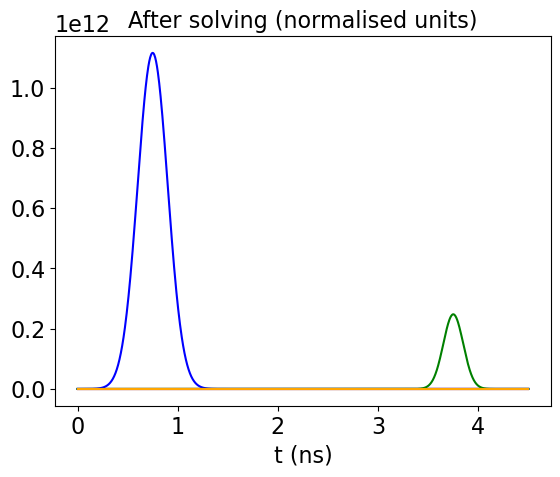

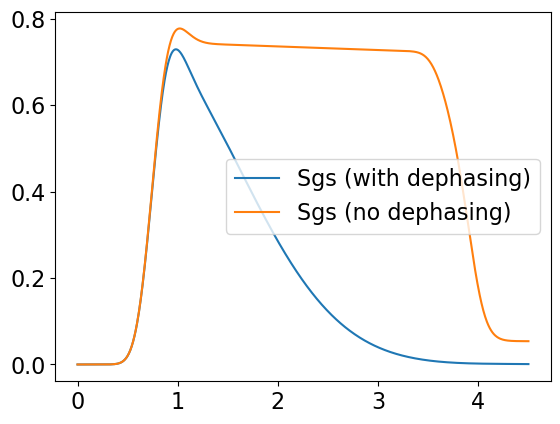

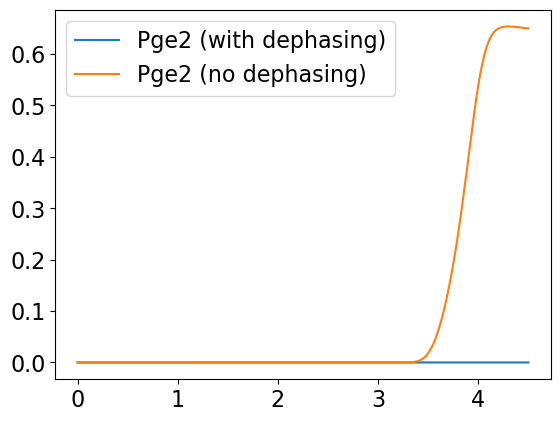

In [67]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12
Omega_store = 8e9
delay = 3e-9
Omega_M1 = 2*np.pi*0.6e9
Omega_M2 = 0


control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
M1_store = (S.gaussian(t, t0+delay, tauc, Omega_M1))[:, None] * control_pol[None, :]
M2_store = (S.gaussian(t, t0+delay, tauc, Omega_M2))[:, None] * control_pol[None, :]


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])


sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
M2_tzp = sol.co_prop( M2_store )

Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

sol.solve(Controls, method='RK4-Ralston')

plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.ER[:, -1, 0]),2), color='black', label='Leaked bad signal intensity')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(Control_store[:, 0])**2, color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M1_store[:, 0])**2, color='green', label='M1 rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M2_store[:, 0])**2, color='orange', label='M2 rabi frequency\n (scaled)')
#plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('t (ns)')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()


Sgs_eff = np.array([sol.storage_efficiency(sol.Sgs, mi) for mi in range(m)])
Sgs_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgs[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Sgs_eff, label='Sgs (with dephasing)')
plt.plot(t*1e9, Sgs_eff_ignore_phase, label='Sgs (no dephasing)')
plt.legend()
plt.show()


Pge2_eff = np.array([sol.storage_efficiency(sol.Pge2, mi) for mi in range(m)])
Pge2_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge2[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Pge2_eff, label='Pge2 (with dephasing)')
plt.plot(t*1e9, Pge2_eff_ignore_phase, label='Pge2 (no dephasing)')
plt.legend()
plt.show()

In [68]:
Sgsmax = max(Sgs_eff_ignore_phase)
Sgsmax

0.7775246093076318

In [42]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1_list = 2*np.pi*1e9 * np.linspace(0.1, 2, 15)
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 *np.linspace(0.01, 1, 15)
Omega_M2 = 0


M1_eff = np.zeros((len(deltaM1_list), len(Omega_M1_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

for i, deltaM1 in enumerate(deltaM1_list):
    for j, Omega_M1 in enumerate(Omega_M1_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = (S.gaussian(t, t0+delay, tauc, Omega_M1))[:, None] * control_pol[None, :]
        M2_store = (S.gaussian(t, t0+delay, tauc, Omega_M2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')




        Pge2_eff_ignore_phase = np.trapz( 
                            np.einsum('zghqw -> z', 
                                        pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge2[-1], nan=0.0))),2)), 
                                        sol.zCheby)
        
        M1_eff[i, j] = Pge2_eff_ignore_phase/Sgsmax



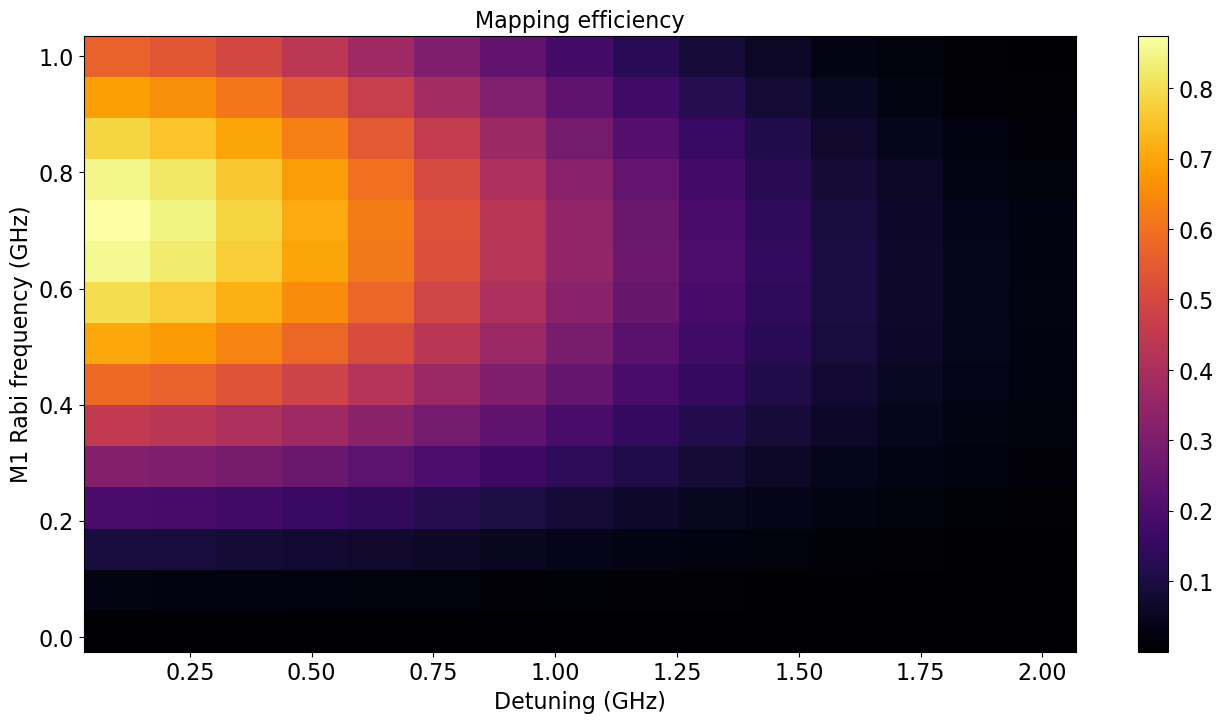

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(deltaM1_list/(2*np.pi*1e9), Omega_M1_list/(2*np.pi*1e9), M1_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('Detuning (GHz)')
ax.set_ylabel('M1 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')

plt.savefig('ORCA_report/18032024_M1_eff_OmegaM1_vs_deltaM1.pdf') 
plt.show()

In [71]:
np.savetxt(f'ORCA_report/18032024_M1_eff_OmegaM1_vs_deltaM1.txt', np.column_stack((deltaM1_list/(2*np.pi*1e9), Omega_M1_list/(2*np.pi*1e9), M1_eff)))

In [67]:
T = 273.15 + 100
delta = 6e9
fs = 384.2279e12 - delta 
fm1 = 196.0287e12
fm2 = 384.2279e12
fc = 196.0287e12 + delta

dk = 2*np.pi*(fs + fm1 - fm2 - fc)/sol.c

Tdopp = np.sqrt(2*sol.M/(T*pow(dk, 2)*sol.kB))
Tdopp

2.976807124068666e-05

In [66]:
T = 273.15 + 100
delta = 6e9
deltaHF = 6.8e9
fs = 384.2279e12 - delta 
fm1 = 196.0287e12
fm2 = 384.2279e12 - deltaHF
fc = 196.0287e12 + delta

dk = 2*np.pi*(fs + fm1 - fm2 - fc)/sol.c

Tdopp = np.sqrt(2*sol.M/(T*pow(dk, 2)*sol.kB))
Tdopp

6.869554901696921e-05

In [70]:
T = 273.15 + 100
delta = -6e9
deltaHF = 6.8e9
fs = 384.2279e12 - delta 
fm1 = 196.0287e12
fm2 = 384.2279e12 + deltaHF
fc = 196.0287e12 + delta

dk = 2*np.pi*(fs + fm1 - fm2 - fc)/sol.c

Tdopp = np.sqrt(2*sol.M/(T*pow(dk, 2)*sol.kB))
Tdopp

6.869554901696921e-05

In [68]:
T = 273.15 + 100
delta = 6e9
deltaHF = 6.8e9
fs = 384.2279e12 - delta 
fm1 = 196.0287e12
fm2 = 384.2279e12 + deltaHF
fc = 196.0287e12 + delta

dk = 2*np.pi*(fs + fm1 - fm2 - fc)/sol.c

Tdopp = np.sqrt(2*sol.M/(T*pow(dk, 2)*sol.kB))
Tdopp

1.9000896536608503e-05

In [65]:
T = 273.15 + 100
delta = 6e9
fs = 384.2279e12 - delta 
fm1 = 0
fm2 = 0
fc = 196.0287e12 + delta

dk = 2*np.pi*(fs + fm1 - fm2 - fc)/sol.c

Tdopp = np.sqrt(2*sol.M/(T*pow(dk, 2)*sol.kB))
Tdopp

1.8981995315740913e-09

In [64]:
T = 273.15 + 100
delta = 6e9
deltaHF = 6.8e9
fs = 384.2279e12 - delta 
fm1 = 0
fm2 = 384.2279e12 - delta + deltaHF
fc = 0

dk = 2*np.pi*(fs + fm1 - fm2 - fc)/sol.c

Tdopp = np.sqrt(2*sol.M/(T*pow(dk, 2)*sol.kB))
Tdopp

5.253189042474116e-05

# Choose t=3ns, can we map to ground state efficiently, while no light escapes?

In [16]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}, "intermediate2": {"n" : 5, "L": 1, "J" : 3/2}, 
                                                    "storage2": {"n" : 5, "L": 0, "F": 1}}}
atom = AC.Rb87(config)

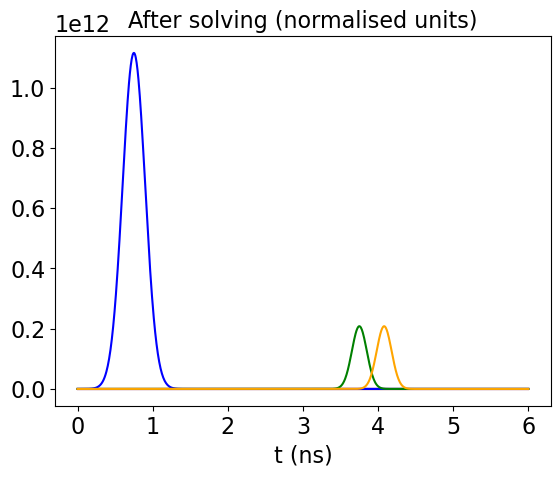

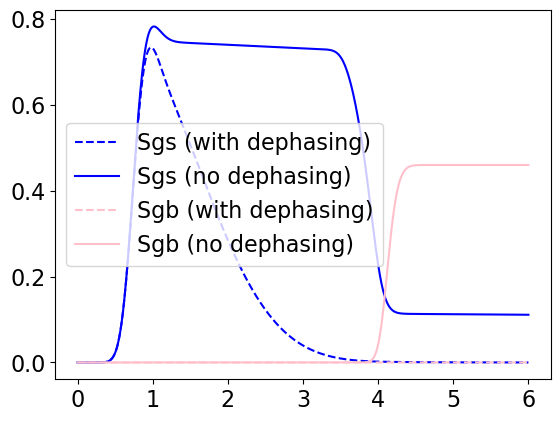

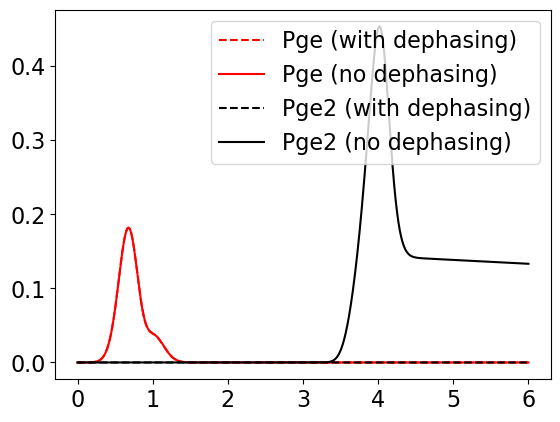

In [70]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 6e-9 #210e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12
Omega_store = 8e9
delay = 3e-9
Omega_M1 = 2*np.pi*0.55e9
Omega_M2 = 2*np.pi*0.55e9
tsep = 330e-12


control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
M1_store = (S.gaussian(t, t0+delay, tauc, Omega_M1))[:, None] * control_pol[None, :]
M2_store = (S.gaussian(t, t0+delay+tsep, tauc, Omega_M2))[:, None] * control_pol[None, :]


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])


sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
M2_tzp = sol.co_prop( M2_store )

Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

sol.solve(Controls, method='RK4-Ralston')

plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.ER[:, -1, 0]),2), color='black', label='Leaked bad signal intensity')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(Control_store[:, 0])**2, color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M1_store[:, 0])**2, color='green', label='M1 rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M2_store[:, 0])**2, color='orange', label='M2 rabi frequency\n (scaled)')
#plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('t (ns)')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()


Sgs_eff = np.array([sol.storage_efficiency(sol.Sgs, mi) for mi in range(m)])
Sgs_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgs[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Sgb_eff = np.array([sol.storage_efficiency(sol.Sgb, mi) for mi in range(m)])
Sgb_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Sgs_eff, label='Sgs (with dephasing)', color='b', linestyle='dashed')
plt.plot(t*1e9, Sgs_eff_ignore_phase, label='Sgs (no dephasing)', color='b')
plt.plot(t*1e9, Sgb_eff, label='Sgb (with dephasing)', color='pink', linestyle='dashed')
plt.plot(t*1e9, Sgb_eff_ignore_phase, label='Sgb (no dephasing)', color='pink')
plt.legend()
plt.show()


Pge_eff = np.array([sol.storage_efficiency(sol.Pge, mi) for mi in range(m)])
Pge_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Pge2_eff = np.array([sol.storage_efficiency(sol.Pge2, mi) for mi in range(m)])
Pge2_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge2[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Pge_eff, label='Pge (with dephasing)', color='r', linestyle='dashed')
plt.plot(t*1e9, Pge_eff_ignore_phase, label='Pge (no dephasing)', color='r')
plt.plot(t*1e9, Pge2_eff, label='Pge2 (with dephasing)', color='k', linestyle='dashed')
plt.plot(t*1e9, Pge2_eff_ignore_phase, label='Pge2 (no dephasing)', color='k')
plt.legend()
plt.show()

In [71]:
Sgb_eff_ignore_phase[-1]/Sgsmax

0.5917873394553352

### What rabi frequency is reasonable?

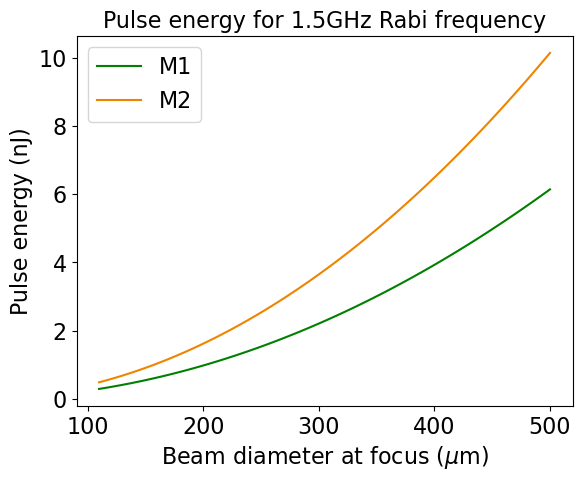

In [122]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}, "intermediate2": {"n" : 5, "L": 1, "J" : 3/2}, 
                                                    "storage2": {"n" : 5, "L": 0, "F": 1}}}
atom = AC.Rb87(config)

### From TORCA simualtion fitting to experiment (TORCA.ipynb and Thomas et al. 2023)
control_factor = 1/6

tau = 330e-12

t0 = 1.5*tau
tend = 2e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

Omega = 2*np.pi*1e9 * 1.5
energy_list_M1 = []
energy_list_M2 = []

beam_waist_list = 1e-6*np.linspace(110, 500, 100)

for beam_waist in beam_waist_list:
    Control = np.sqrt(S.gaussian(t, t0, tau, Omega**2))
    energy_list_M1.append(atom.control_pulse_to_energy(Control/control_factor, t, r=beam_waist, index=1))
    energy_list_M2.append(atom.control_pulse_to_energy(Control/control_factor, t, r=beam_waist, index=0))

plt.plot(beam_waist_list*1e6, np.array(energy_list_M1)*1e9, color='#008000ff', label='M1')
plt.plot(beam_waist_list*1e6, np.array(energy_list_M2)*1e9, color='#ee8500ff', label='M2')
plt.title('Pulse energy for 1.5GHz Rabi frequency')
plt.ylabel('Pulse energy (nJ)')
plt.xlabel('Beam diameter at focus ($\mu$m)')
plt.legend()
plt.show()

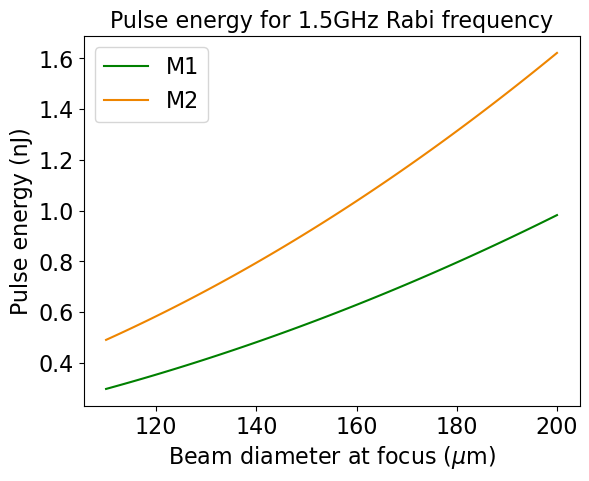

In [123]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}, "intermediate2": {"n" : 5, "L": 1, "J" : 3/2}, 
                                                    "storage2": {"n" : 5, "L": 0, "F": 1}}}
atom = AC.Rb87(config)

### From TORCA simualtion fitting to experiment (TORCA.ipynb and Thomas et al. 2023)
control_factor = 1/6

tau = 330e-12

t0 = 1.5*tau
tend = 2e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

Omega = 2*np.pi*1e9 * 1.5
energy_list_M1 = []
energy_list_M2 = []

beam_waist_list = 1e-6*np.linspace(110, 200, 100)

for beam_waist in beam_waist_list:
    Control = np.sqrt(S.gaussian(t, t0, tau, Omega**2))
    energy_list_M1.append(atom.control_pulse_to_energy(Control/control_factor, t, r=beam_waist, index=1))
    energy_list_M2.append(atom.control_pulse_to_energy(Control/control_factor, t, r=beam_waist, index=0))

plt.plot(beam_waist_list*1e6, np.array(energy_list_M1)*1e9, color='#008000ff', label='M1')
plt.plot(beam_waist_list*1e6, np.array(energy_list_M2)*1e9, color='#ee8500ff', label='M2')
plt.title('Pulse energy for 1.5GHz Rabi frequency')
plt.ylabel('Pulse energy (nJ)')
plt.xlabel('Beam diameter at focus ($\mu$m)')
plt.legend()
plt.show()

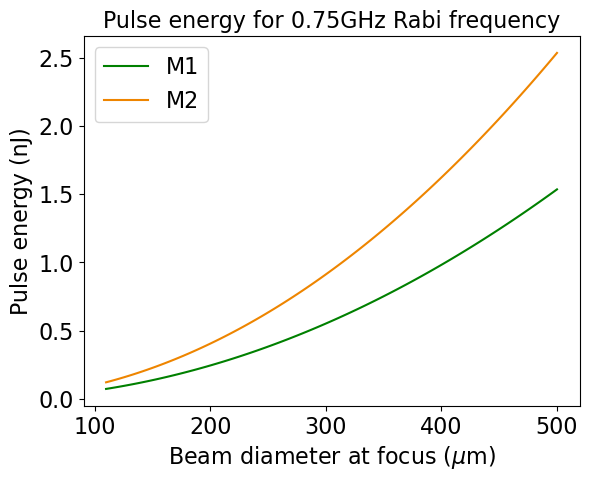

In [124]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}, "intermediate2": {"n" : 5, "L": 1, "J" : 3/2}, 
                                                    "storage2": {"n" : 5, "L": 0, "F": 1}}}
atom = AC.Rb87(config)

### From TORCA simualtion fitting to experiment (TORCA.ipynb and Thomas et al. 2023)
control_factor = 1/6

tau = 330e-12

t0 = 1.5*tau
tend = 2e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

Omega = 2*np.pi*1e9 * 0.75
energy_list_M1 = []
energy_list_M2 = []

beam_waist_list = 1e-6*np.linspace(110, 500, 100)

for beam_waist in beam_waist_list:
    Control = np.sqrt(S.gaussian(t, t0, tau, Omega**2))
    energy_list_M1.append(atom.control_pulse_to_energy(Control/control_factor, t, r=beam_waist, index=1))
    energy_list_M2.append(atom.control_pulse_to_energy(Control/control_factor, t, r=beam_waist, index=0))

plt.plot(beam_waist_list*1e6, np.array(energy_list_M1)*1e9, color='#008000ff', label='M1')
plt.plot(beam_waist_list*1e6, np.array(energy_list_M2)*1e9, color='#ee8500ff', label='M2')
plt.title('Pulse energy for 0.75GHz Rabi frequency')
plt.ylabel('Pulse energy (nJ)')
plt.xlabel('Beam diameter at focus ($\mu$m)')
plt.legend()
plt.show()

### Control field

### Transfer pulse

In [18]:
# pi pulse from TORCA dressing experiment

sech2_factor = 0.88
P_average = 70e-3
E = P_average * 12.5e-9 / sech2_factor
E

9.94318181818182e-10

In [ ]:
# energy  of 2*pi*200 MHz rabi frequency pulse
Omega = 2*np.pi*1e9 * 0.2
control_factor = 1/6
Control = np.sqrt(S.gaussian(t, t0, tau, Omega**2))
E = atom.control_pulse_to_energy(Control/control_factor, t, r=110e-6, index=2)
E

1.169775146584368e-09

In [ ]:
(0.5/330e-12) / (2*np.pi*1e9) # estimated pi pulse rabi frequency

0.2411438531695384

In [ ]:
# energy needed for 500 um beam diameter
Omega = 2*np.pi*1e9 * 0.2
control_factor = 1/6
Control = np.sqrt(S.gaussian(t, t0, tau, Omega**2))
E = atom.control_pulse_to_energy(Control/control_factor, t, r=250e-6, index=2)
E

6.042226996820081e-09

In [ ]:
# energy needed for 400 um beam diameter
Omega = 2*np.pi*1e9 * 0.2
control_factor = 1/6
Control = np.sqrt(S.gaussian(t, t0, tau, Omega**2))
E = atom.control_pulse_to_energy(Control/control_factor, t, r=200e-6, index=2)
E

3.867025277964852e-09

### tsep = 330ps

In [12]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)


mapping_eff = np.zeros((len(Omega_M1_list), len(Omega_M2_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 330e-12

for i, Omega_M1 in enumerate(Omega_M1_list):
    for j, Omega_M2 in enumerate(Omega_M2_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = np.sqrt(S.gaussian(t, t0+delay, tauc, Omega_M1**2))[:, None] * control_pol[None, :]
        M2_store = np.sqrt(S.gaussian(t, t0+delay+tsep, tauc, Omega_M2**2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')

        Sgb_eff_ignore_phase = np.trapz( 
                                np.einsum('zghqw -> z', 
                                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                            sol.zCheby)
        
        mapping_eff[i, j] = Sgb_eff_ignore_phase/Sgsmax



AttributeError: 'Rb87' object has no attribute 'coupling_be'

NameError: name 'Omega_M1_list' is not defined

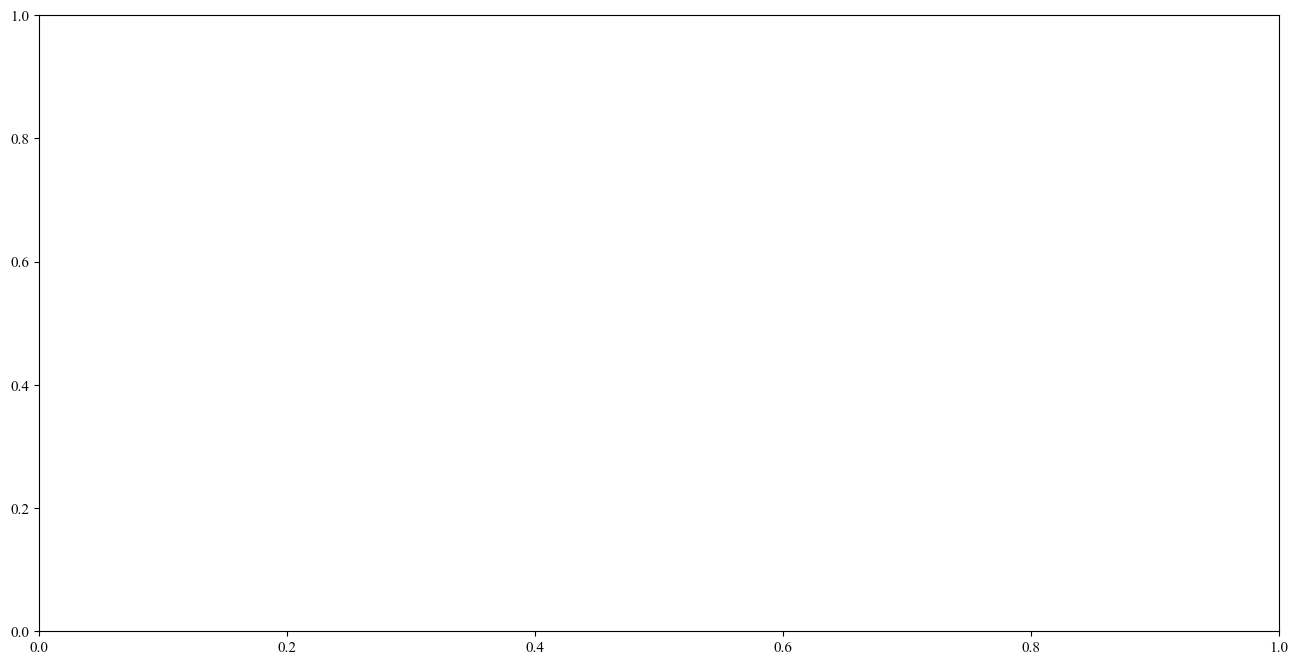

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')


plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.pdf') 
plt.show()

print(max(mapping_eff.T.flatten()))

In [74]:
np.savetxt(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.txt', np.column_stack((Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff)))

### tsep = 165ps

In [75]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)


mapping_eff = np.zeros((len(Omega_M1_list), len(Omega_M2_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 165e-12

for i, Omega_M1 in enumerate(Omega_M1_list):
    for j, Omega_M2 in enumerate(Omega_M2_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = np.sqrt(S.gaussian(t, t0+delay, tauc, Omega_M1**2))[:, None] * control_pol[None, :]
        M2_store = np.sqrt(S.gaussian(t, t0+delay+tsep, tauc, Omega_M2**2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')

        Sgb_eff_ignore_phase = np.trapz( 
                                np.einsum('zghqw -> z', 
                                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                            sol.zCheby)
        
        mapping_eff[i, j] = Sgb_eff_ignore_phase/Sgsmax



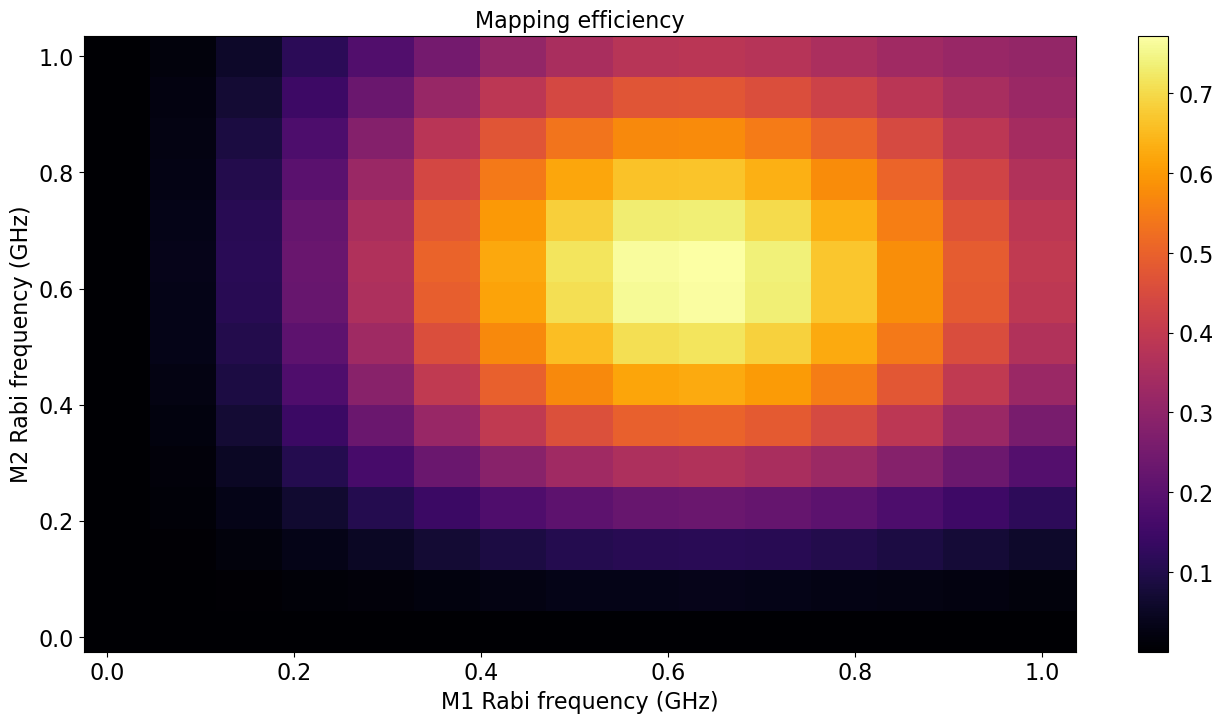

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')

plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.pdf') 
plt.show()

In [77]:
np.savetxt(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.txt', np.column_stack((Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff)))

### tsep = 0ps

In [78]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 * np.linspace(0.5, 1.5, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(0.5, 1.5, 15)


mapping_eff = np.zeros((len(Omega_M1_list), len(Omega_M2_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 0

for i, Omega_M1 in enumerate(Omega_M1_list):
    for j, Omega_M2 in enumerate(Omega_M2_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = np.sqrt(S.gaussian(t, t0+delay, tauc, Omega_M1**2))[:, None] * control_pol[None, :]
        M2_store = np.sqrt(S.gaussian(t, t0+delay+tsep, tauc, Omega_M2**2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')

        Sgb_eff_ignore_phase = np.trapz( 
                                np.einsum('zghqw -> z', 
                                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                            sol.zCheby)
        
        mapping_eff[i, j] = Sgb_eff_ignore_phase/Sgsmax



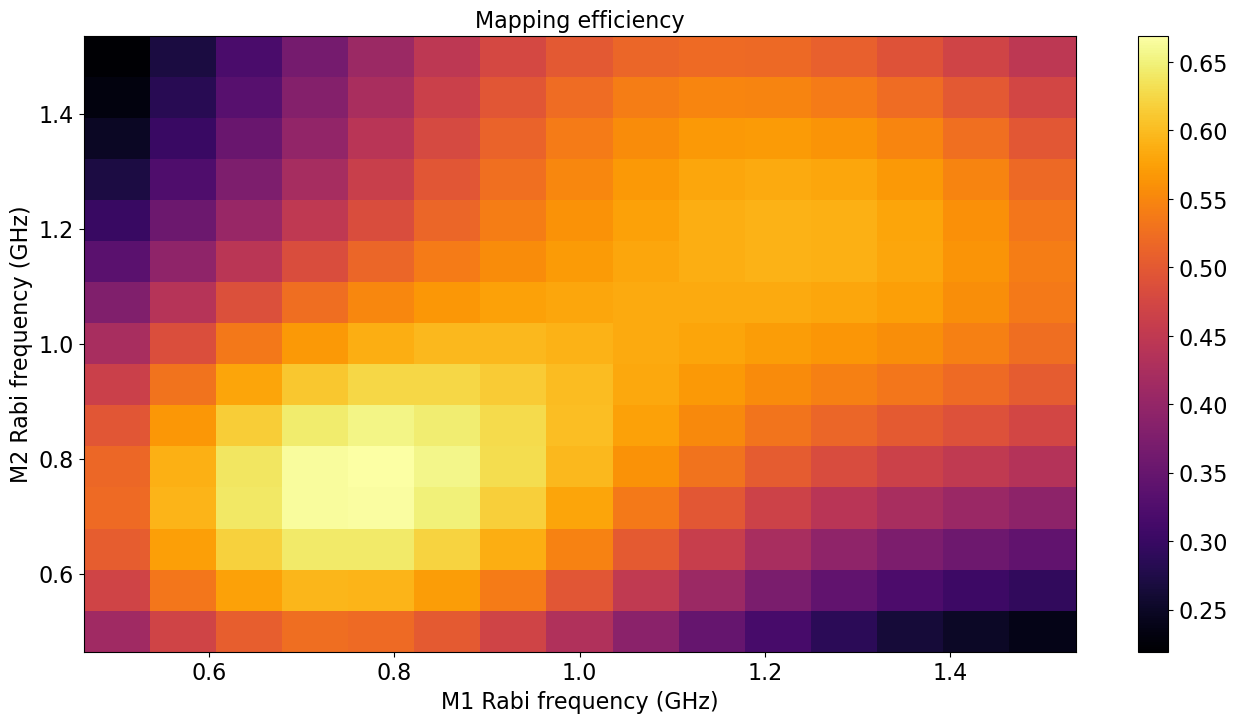

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')

plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.pdf') 
plt.show()

In [80]:
np.savetxt(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.txt', np.column_stack((Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff)))

### tsep = 0ps, higher rabi range

In [94]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 * np.linspace(1.4, 2.5, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(1.4, 2.5, 15)


mapping_eff = np.zeros((len(Omega_M1_list), len(Omega_M2_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 0

for i, Omega_M1 in enumerate(Omega_M1_list):
    for j, Omega_M2 in enumerate(Omega_M2_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = (S.gaussian(t, t0+delay, tauc, Omega_M1))[:, None] * control_pol[None, :]
        M2_store = (S.gaussian(t, t0+delay+tsep, tauc, Omega_M2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')

        Sgb_eff_ignore_phase = np.trapz( 
                                np.einsum('zghqw -> z', 
                                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                            sol.zCheby)
        
        mapping_eff[i, j] = Sgb_eff_ignore_phase/Sgsmax



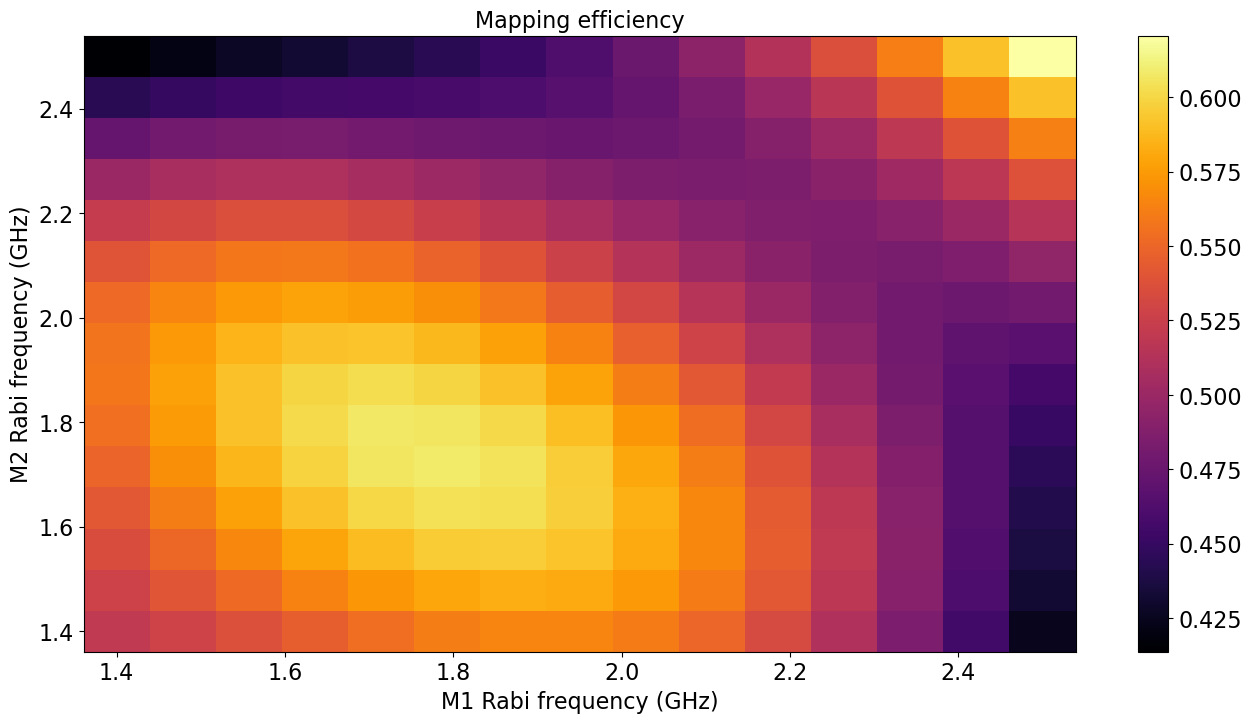

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')

plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_higher_range_tsep={tsep*1e12}ps.pdf') 
plt.show()

In [96]:
np.savetxt(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_higher_range_tsep={tsep*1e12}ps.txt', np.column_stack((Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff)))

### tsep = 0ps, higher rabi range (5e9)

In [97]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 * np.linspace(2.4, 5, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(2.4, 5, 15)


mapping_eff = np.zeros((len(Omega_M1_list), len(Omega_M2_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 0

for i, Omega_M1 in enumerate(Omega_M1_list):
    for j, Omega_M2 in enumerate(Omega_M2_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = (S.gaussian(t, t0+delay, tauc, Omega_M1))[:, None] * control_pol[None, :]
        M2_store = (S.gaussian(t, t0+delay+tsep, tauc, Omega_M2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')

        Sgb_eff_ignore_phase = np.trapz( 
                                np.einsum('zghqw -> z', 
                                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                            sol.zCheby)
        
        mapping_eff[i, j] = Sgb_eff_ignore_phase/Sgsmax



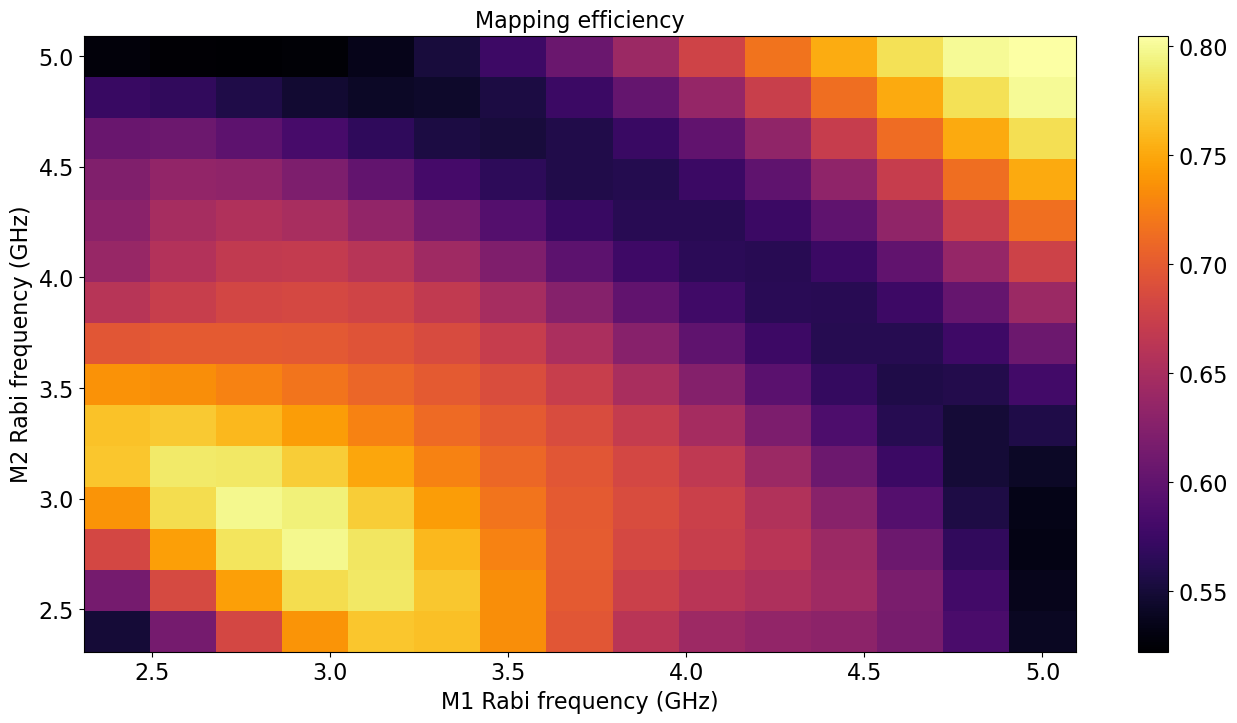

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')

plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_higher_range_upto_5e9_tsep={tsep*1e12}ps.pdf') 
plt.show()

In [99]:
np.savetxt(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_higher_range_upto_5e9_tsep={tsep*1e12}ps.txt', np.column_stack((Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff)))

### tsep = 495ps

In [81]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)


mapping_eff = np.zeros((len(Omega_M1_list), len(Omega_M2_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 495e-12

for i, Omega_M1 in enumerate(Omega_M1_list):
    for j, Omega_M2 in enumerate(Omega_M2_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = np.sqrt(S.gaussian(t, t0+delay, tauc, Omega_M1**2))[:, None] * control_pol[None, :]
        M2_store = np.sqrt(S.gaussian(t, t0+delay+tsep, tauc, Omega_M2**2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')

        Sgb_eff_ignore_phase = np.trapz( 
                                np.einsum('zghqw -> z', 
                                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                            sol.zCheby)
        
        mapping_eff[i, j] = Sgb_eff_ignore_phase/Sgsmax



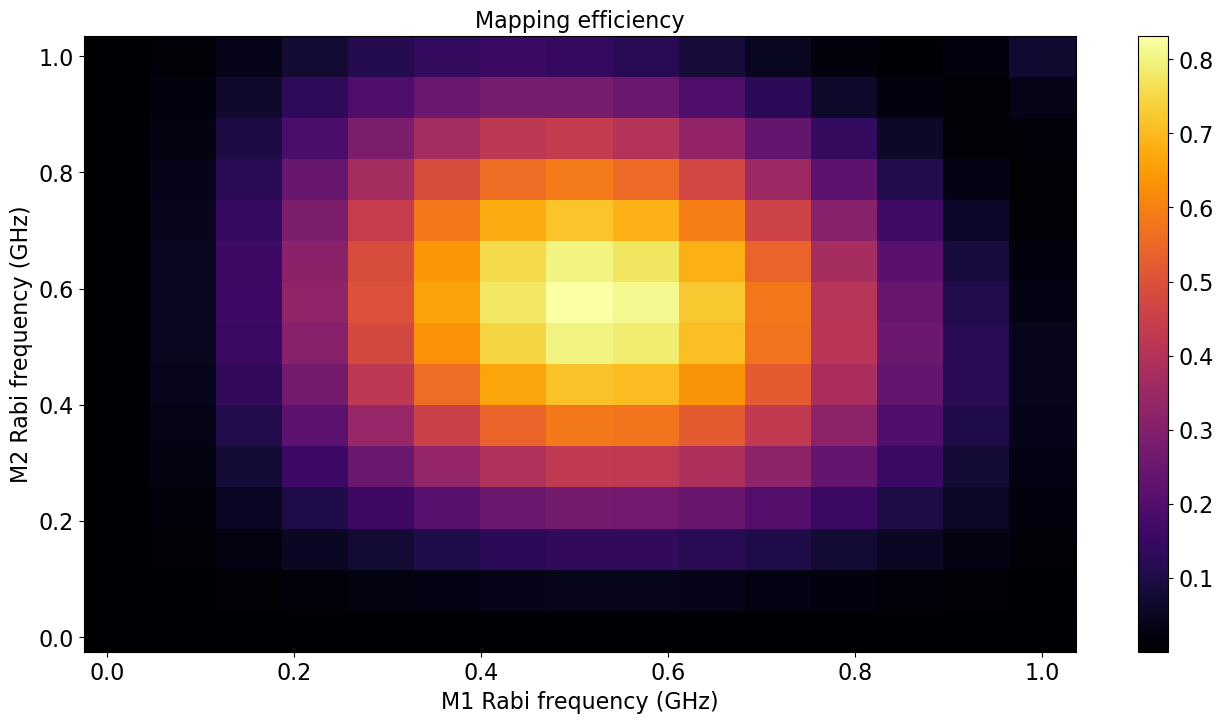

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')

plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.pdf') 
plt.show()

In [83]:
np.savetxt(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.txt', np.column_stack((Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff)))

### tsep = 200ps

In [84]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)


mapping_eff = np.zeros((len(Omega_M1_list), len(Omega_M2_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 200e-12

for i, Omega_M1 in enumerate(Omega_M1_list):
    for j, Omega_M2 in enumerate(Omega_M2_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = np.sqrt(S.gaussian(t, t0+delay, tauc, Omega_M1**2))[:, None] * control_pol[None, :]
        M2_store = np.sqrt(S.gaussian(t, t0+delay+tsep, tauc, Omega_M2**2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')

        Sgb_eff_ignore_phase = np.trapz( 
                                np.einsum('zghqw -> z', 
                                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                            sol.zCheby)
        
        mapping_eff[i, j] = Sgb_eff_ignore_phase/Sgsmax



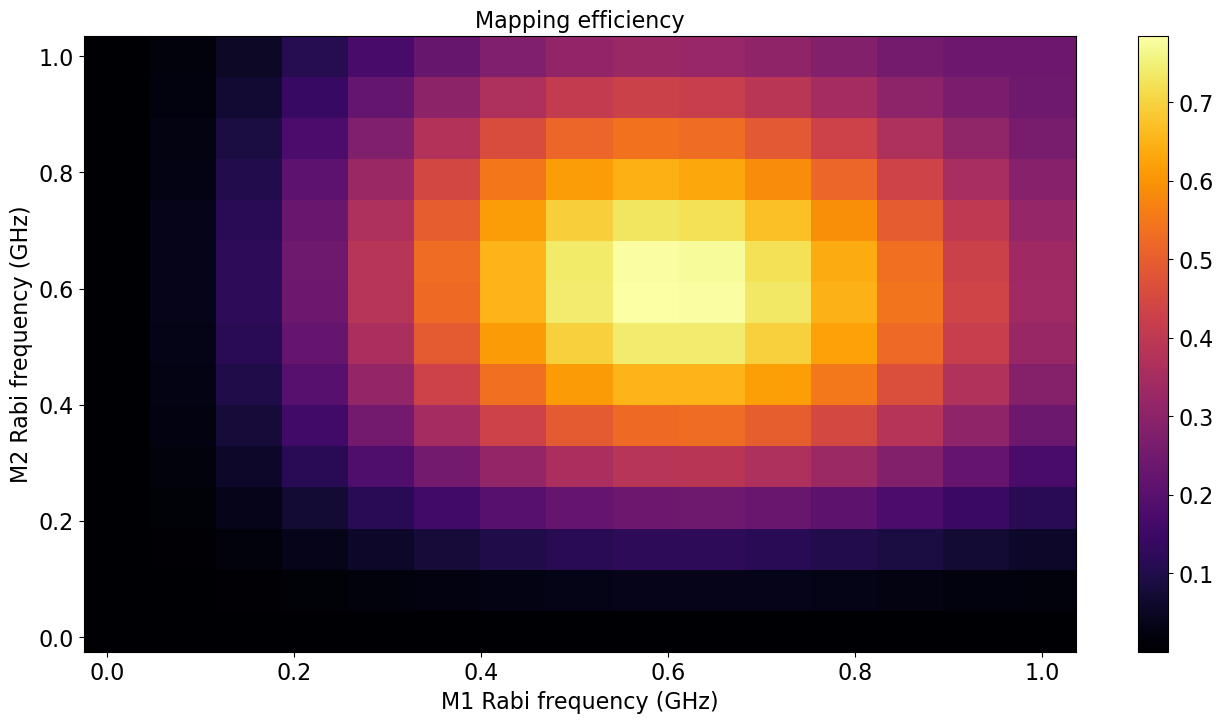

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')

plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.pdf') 
plt.show()

In [86]:
np.savetxt(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.txt', np.column_stack((Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff)))

### tsep = 200ps, higher rabi frequency range, upto 1.5 GHz

In [107]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 200e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 * np.linspace(0.4, 1.5, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(0.4, 1.5, 15)


mapping_eff = np.zeros((len(Omega_M1_list), len(Omega_M2_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 330e-12

for i, Omega_M1 in enumerate(Omega_M1_list):
    for j, Omega_M2 in enumerate(Omega_M2_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = (S.gaussian(t, t0+delay, tauc, Omega_M1))[:, None] * control_pol[None, :]
        M2_store = (S.gaussian(t, t0+delay+tsep, tauc, Omega_M2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')

        Sgb_eff_ignore_phase = np.trapz( 
                                np.einsum('zghqw -> z', 
                                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                            sol.zCheby)
        
        mapping_eff[i, j] = Sgb_eff_ignore_phase/Sgsmax



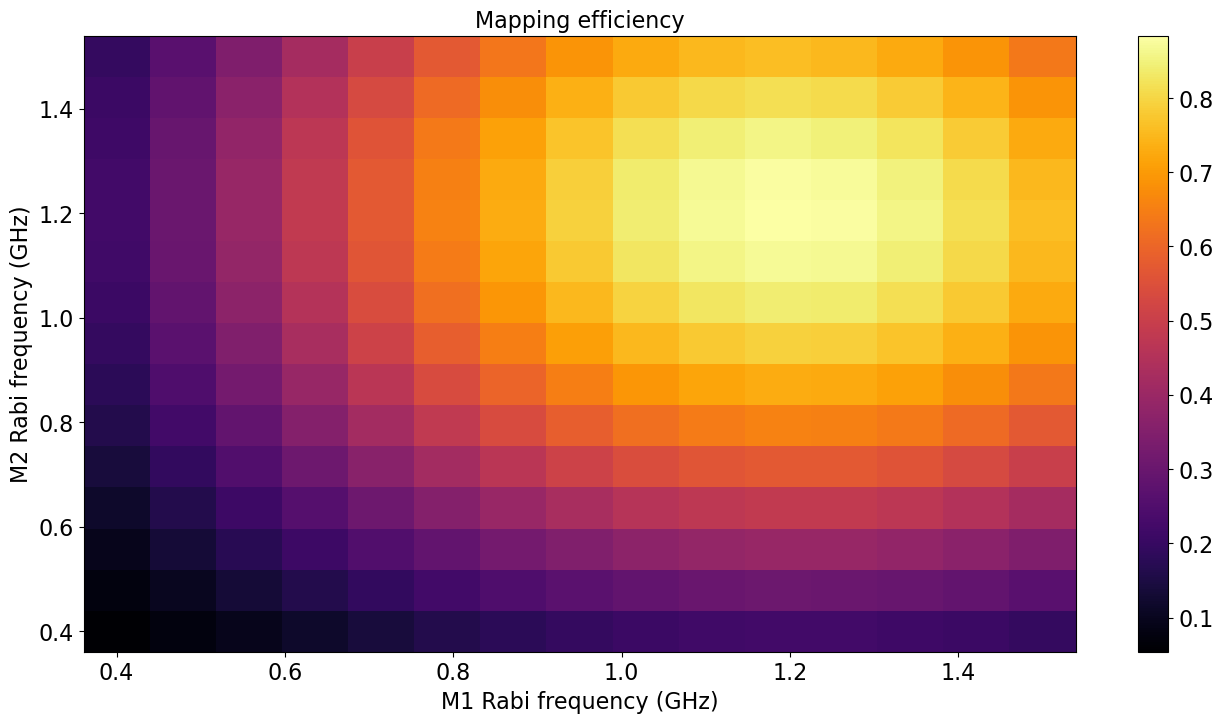

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')

plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_upto_1p5GHz_tsep={tsep*1e12}ps.pdf') 
plt.show()

In [109]:
np.savetxt(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_upto_1p5GHz_tsep={tsep*1e12}ps.txt', np.column_stack((Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff)))

### tsep = 75ps

In [87]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)


mapping_eff = np.zeros((len(Omega_M1_list), len(Omega_M2_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 75e-12

for i, Omega_M1 in enumerate(Omega_M1_list):
    for j, Omega_M2 in enumerate(Omega_M2_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = np.sqrt(S.gaussian(t, t0+delay, tauc, Omega_M1**2))[:, None] * control_pol[None, :]
        M2_store = np.sqrt(S.gaussian(t, t0+delay+tsep, tauc, Omega_M2**2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')

        Sgb_eff_ignore_phase = np.trapz( 
                                np.einsum('zghqw -> z', 
                                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                            sol.zCheby)
        
        mapping_eff[i, j] = Sgb_eff_ignore_phase/Sgsmax



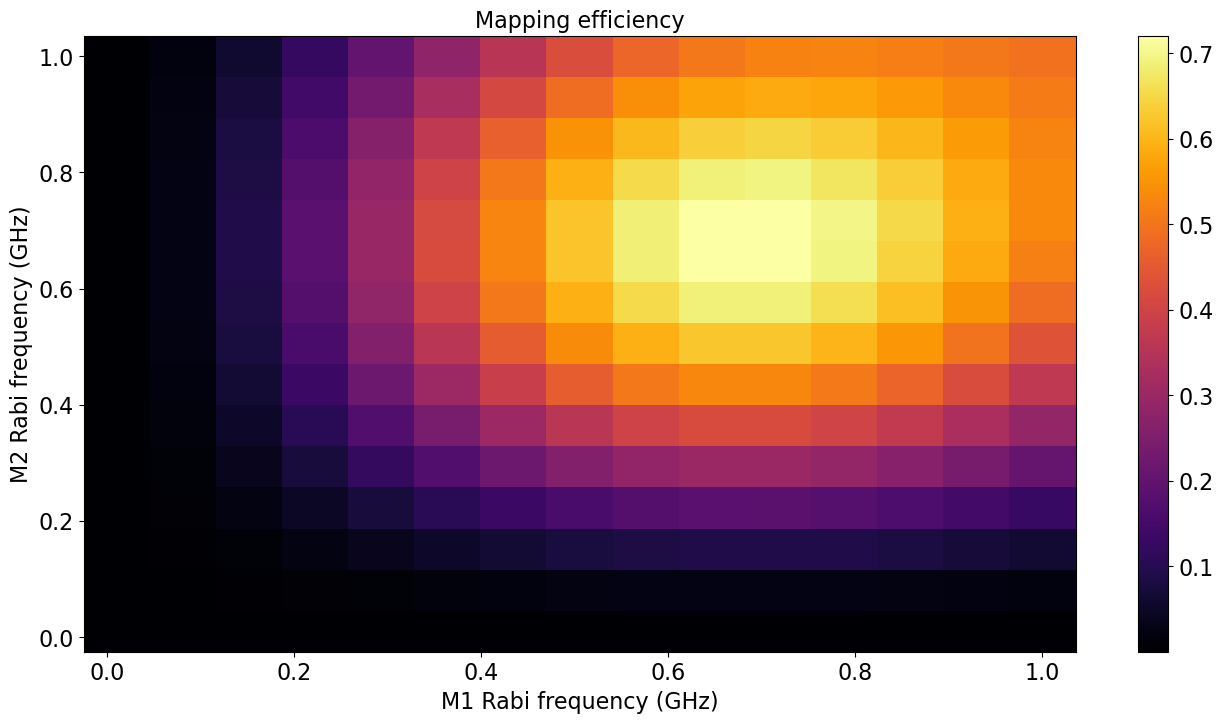

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')

plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.pdf') 
plt.show()

In [89]:
np.savetxt(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.txt', np.column_stack((Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff)))

### tsep = 75ps, higher rabi frequency range, upto 2.5 GHz

In [113]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 75e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 * np.linspace(1, 2.5, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(1, 2.5, 15)


mapping_eff = np.zeros((len(Omega_M1_list), len(Omega_M2_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 330e-12

for i, Omega_M1 in enumerate(Omega_M1_list):
    for j, Omega_M2 in enumerate(Omega_M2_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = (S.gaussian(t, t0+delay, tauc, Omega_M1))[:, None] * control_pol[None, :]
        M2_store = (S.gaussian(t, t0+delay+tsep, tauc, Omega_M2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')

        Sgb_eff_ignore_phase = np.trapz( 
                                np.einsum('zghqw -> z', 
                                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                            sol.zCheby)
        
        mapping_eff[i, j] = Sgb_eff_ignore_phase/Sgsmax



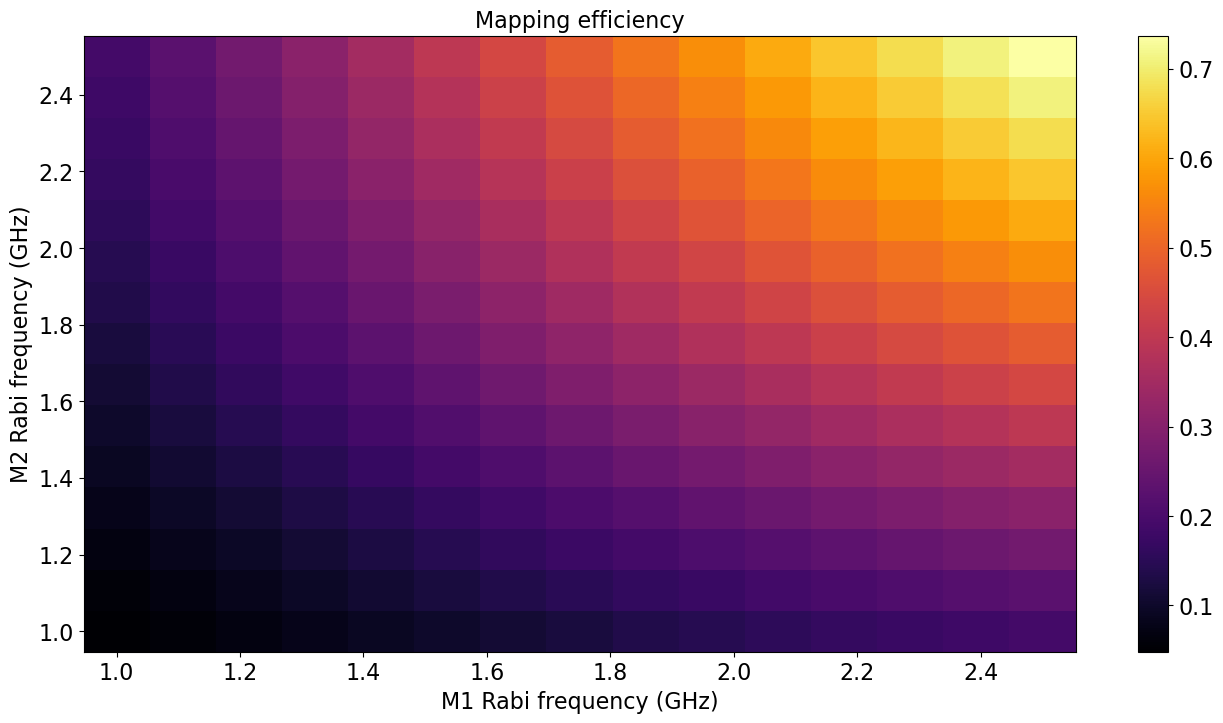

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')

plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_upto_2p5GHz_tsep={tsep*1e12}ps.pdf') 
plt.show()

In [115]:
np.savetxt(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_upto_2p5GHz_tsep={tsep*1e12}ps.txt', np.column_stack((Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff)))

### tsep = 400ps

In [90]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)


mapping_eff = np.zeros((len(Omega_M1_list), len(Omega_M2_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 400e-12

for i, Omega_M1 in enumerate(Omega_M1_list):
    for j, Omega_M2 in enumerate(Omega_M2_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = np.sqrt(S.gaussian(t, t0+delay, tauc, Omega_M1**2))[:, None] * control_pol[None, :]
        M2_store = np.sqrt(S.gaussian(t, t0+delay+tsep, tauc, Omega_M2**2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')

        Sgb_eff_ignore_phase = np.trapz( 
                                np.einsum('zghqw -> z', 
                                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                            sol.zCheby)
        
        mapping_eff[i, j] = Sgb_eff_ignore_phase/Sgsmax



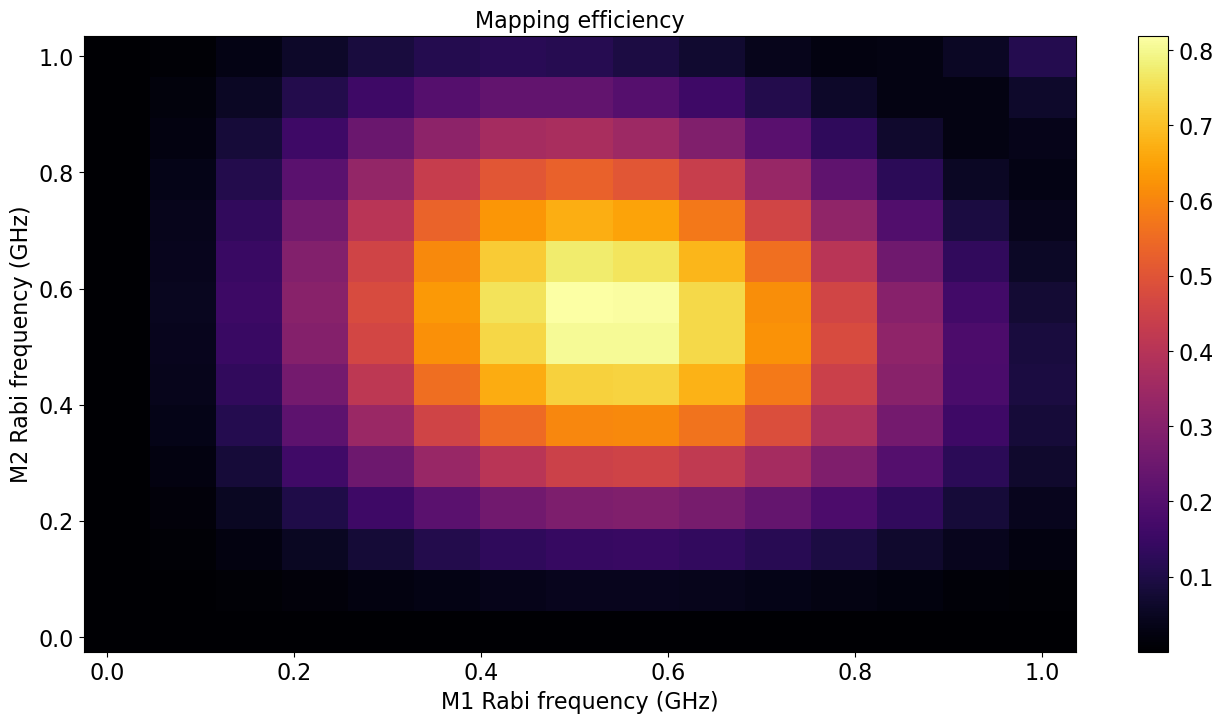

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')

plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.pdf') 
plt.show()

In [92]:
np.savetxt(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.txt', np.column_stack((Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff)))

### tsep = 660ps

In [100]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)


mapping_eff = np.zeros((len(Omega_M1_list), len(Omega_M2_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 660e-12

for i, Omega_M1 in enumerate(Omega_M1_list):
    for j, Omega_M2 in enumerate(Omega_M2_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = np.sqrt(S.gaussian(t, t0+delay, tauc, Omega_M1**2))[:, None] * control_pol[None, :]
        M2_store = np.sqrt(S.gaussian(t, t0+delay+tsep, tauc, Omega_M2**2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')

        Sgb_eff_ignore_phase = np.trapz( 
                                np.einsum('zghqw -> z', 
                                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                            sol.zCheby)
        
        mapping_eff[i, j] = Sgb_eff_ignore_phase/Sgsmax



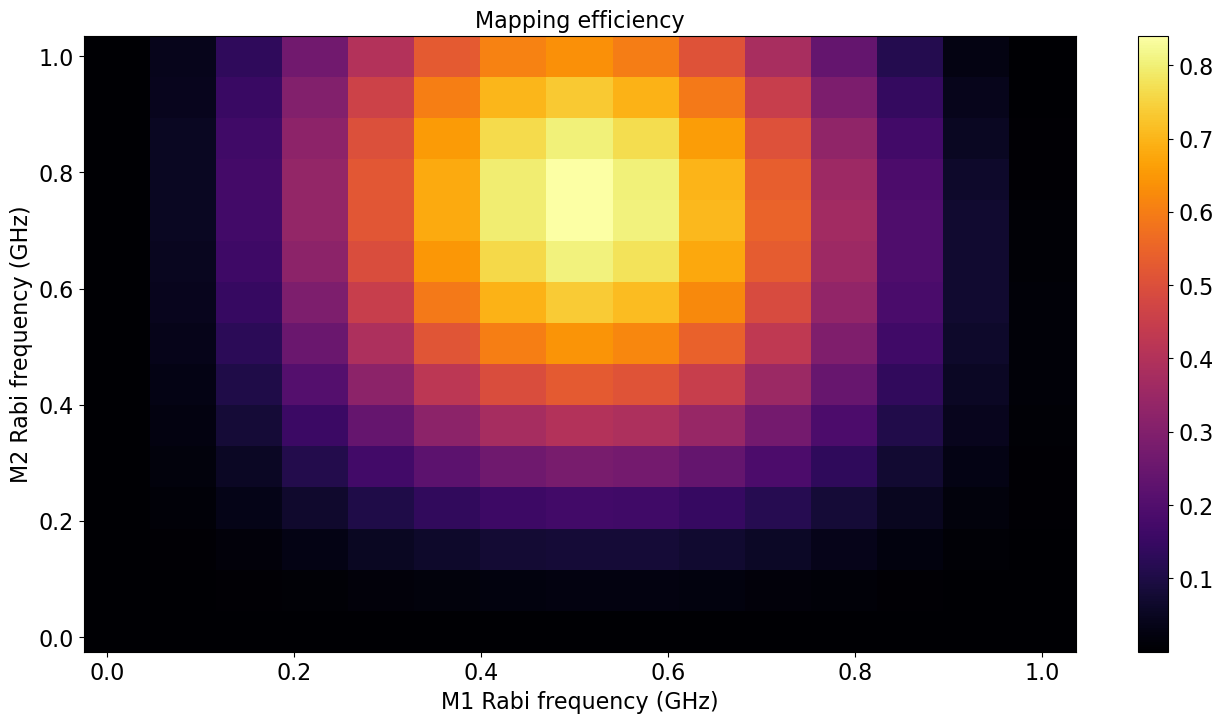

In [101]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')

plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.pdf') 
plt.show()

In [102]:
np.savetxt(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.txt', np.column_stack((Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff)))

### tsep = 800ps

In [103]:
protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0

L = 0.075

t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]


tauc = 330e-12 # 330 ps
Omega_store = 8e9
delay = 3e-9
Omega_M1_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)


mapping_eff = np.zeros((len(Omega_M1_list), len(Omega_M2_list)))


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 800e-12

for i, Omega_M1 in enumerate(Omega_M1_list):
    for j, Omega_M2 in enumerate(Omega_M2_list):

        control_pol = np.array([1, 0])
        Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
        M1_store = np.sqrt(S.gaussian(t, t0+delay, tauc, Omega_M1**2))[:, None] * control_pol[None, :]
        M2_store = np.sqrt(S.gaussian(t, t0+delay+tsep, tauc, Omega_M2**2))[:, None] * control_pol[None, :]


        sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)

        Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
        M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
        M2_tzp = sol.co_prop( M2_store )

        Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

        sol.solve(Controls, method='RK4-Ralston')

        Sgb_eff_ignore_phase = np.trapz( 
                                np.einsum('zghqw -> z', 
                                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                            sol.zCheby)
        
        mapping_eff[i, j] = Sgb_eff_ignore_phase/Sgsmax



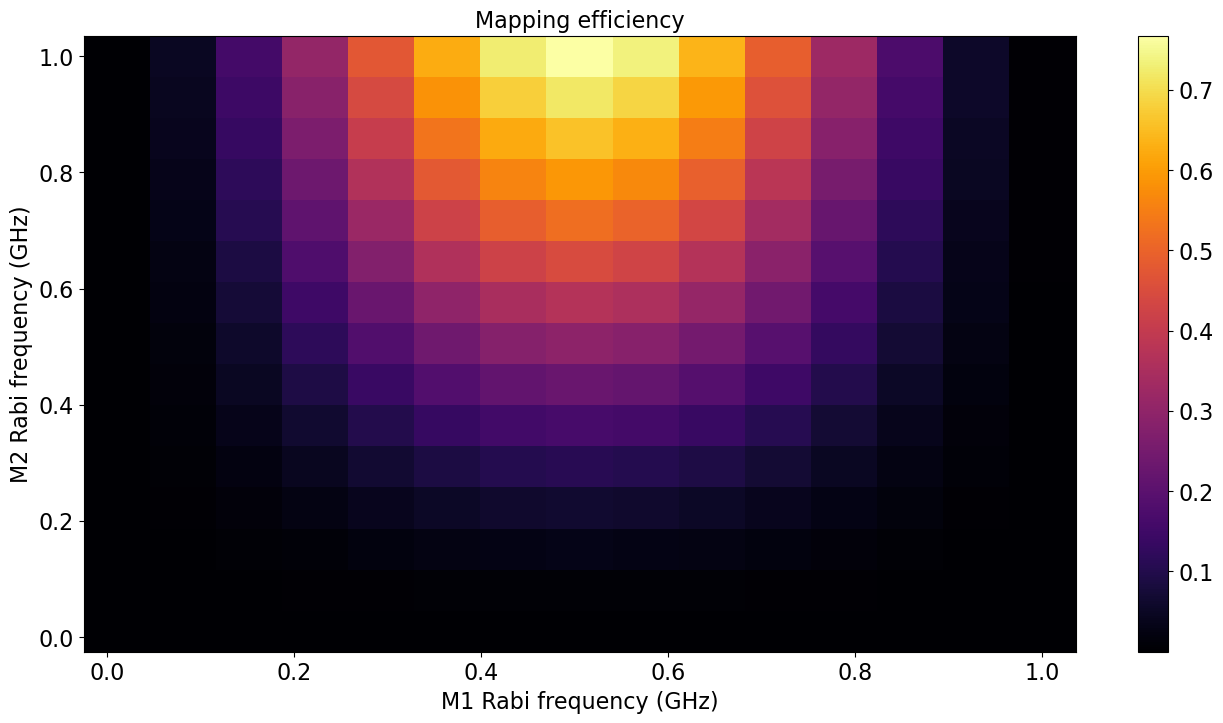

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title('Mapping efficiency')

plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.pdf') 
plt.show()

In [105]:
np.savetxt(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.txt', np.column_stack((Omega_M1_list/(2*np.pi*1e9), Omega_M2_list/(2*np.pi*1e9), mapping_eff)))

# Max eff vs tsep

In [6]:
directory = u'\\\\?\\C:\\Users\\pmb18\\OneDrive - Imperial College London\\Documents\\GitHub\\MEVeS\\ORCA_report\\'
tsep = 330e-12
file = f'18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.txt'

test = np.loadtxt(directory + file)

In [7]:
test.shape

(15, 17)

In [8]:
Omega_M1_list = test[:, 0]
Omega_M2_list = test[:, 1]

mapping_eff = test[:, 2:].T

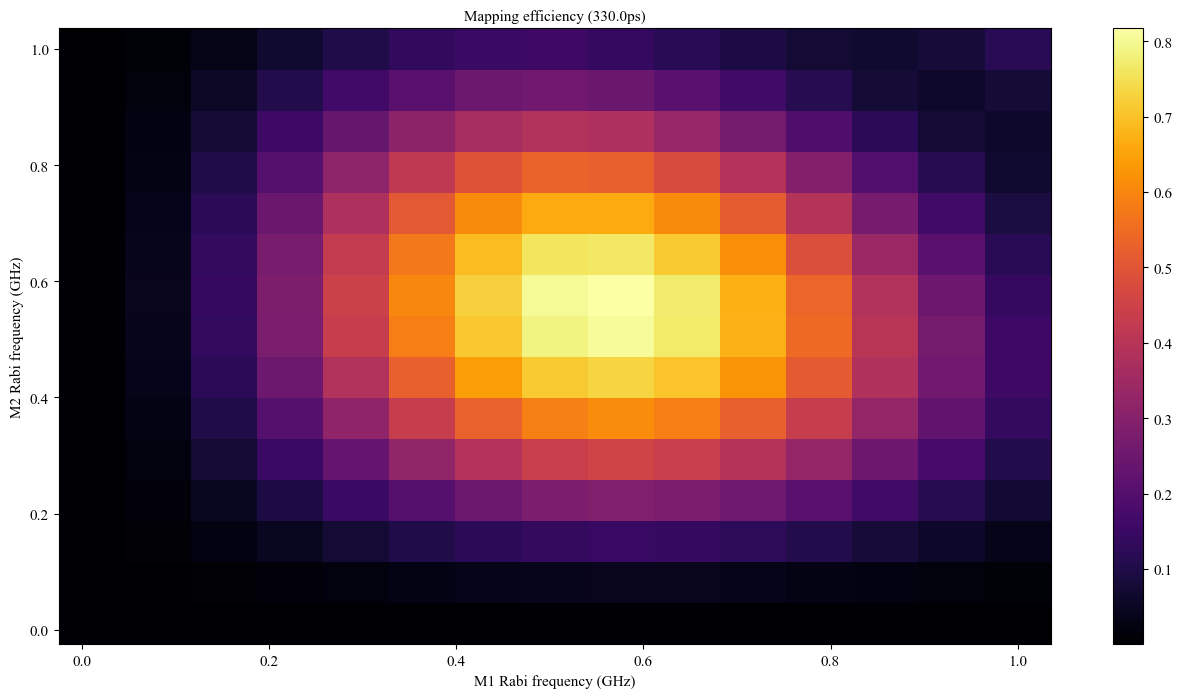

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list, Omega_M2_list, mapping_eff.T, cmap=colour)

fig.colorbar(im, ax=ax)

ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title(f'Mapping efficiency ({tsep*1e12}ps)')

# plt.savefig(f'ORCA_report/18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12}ps.pdf') 
plt.show()

In [10]:
tsep_list = 1e-12*np.array([0, 75, 165, 200, 330, 400, 495, 660, 800])
Omega_num = 15

directory = u'\\\\?\\C:\\Users\\pmb18\\OneDrive - Imperial College London\\Documents\\GitHub\\MEVeS\\ORCA_report\\'

file_list = [f'18032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep*1e12:.1f}ps.txt' for tsep in tsep_list]
Omega_M1_list = np.zeros((len(file_list), Omega_num))
Omega_M2_list = np.zeros((len(file_list), Omega_num))
mapping_eff_array = np.zeros((len(file_list), Omega_num, Omega_num))

for i, file in enumerate(file_list):
    arr = np.loadtxt(directory + file)
    Omega_M1_list[i] = arr[:, 0]
    Omega_M2_list[i] = arr[:, 1]

    mapping_eff_array[i] = arr[:, 2:].T
    

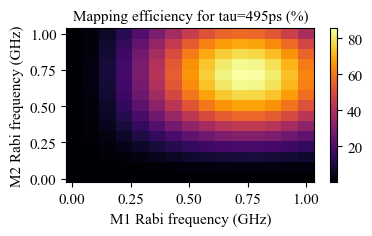

0.8555991121141867
(10, 10)


In [11]:
i = 6

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,2))
colour = plt.get_cmap("inferno")

im = ax.pcolormesh(Omega_M1_list[i], Omega_M2_list[i], mapping_eff_array[i].T*100, cmap=colour)

fig.colorbar(im, ax=ax)
tau_sep_string = 'tau' #r'$\tau_{sep}$'
ax.set_xlabel('M1 Rabi frequency (GHz)')
ax.set_ylabel('M2 Rabi frequency (GHz)')
ax.set_title(f'Mapping efficiency for {tau_sep_string}={tsep_list[i]*1e12:.0f}ps (%)')

plt.savefig(f'ORCA_report/22032024_DRAGON_eff_OmegaM1_vs_OmegaM2_tsep={tsep_list[i]*1e12:.0f}ps_for_fig.pdf') 
plt.show()

print(np.max(mapping_eff_array[i]))
print(np.unravel_index(np.argmax(mapping_eff_array[i]), mapping_eff_array[i].shape))

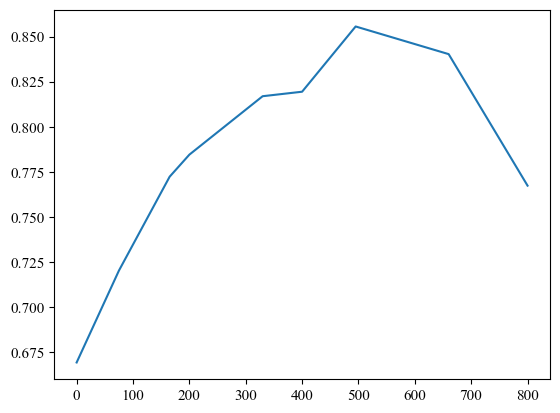

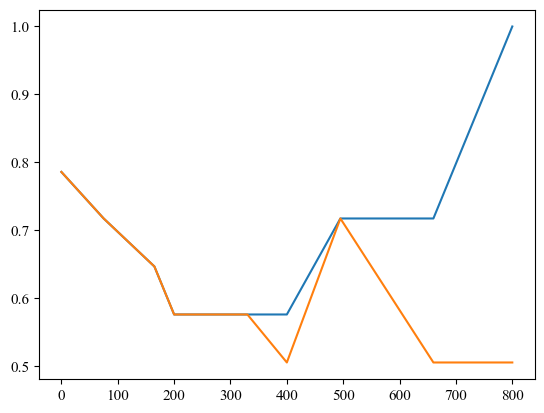

In [12]:
eff_list = []
OmegaM1_list = []
OmegaM2_list = []
for i, tsep in enumerate(tsep_list):
    eff_list.append(np.max(mapping_eff_array[i]))
    idx1, idx2 = np.unravel_index(np.argmax(mapping_eff_array[i]), mapping_eff_array[i].shape)
    OmegaM1 = Omega_M1_list[i, idx1]
    OmegaM1_list.append(OmegaM1)
    OmegaM2 = Omega_M2_list[i, idx2]
    OmegaM2_list.append(OmegaM2)

plt.plot(np.array(tsep_list)*1e12, eff_list)
plt.show()

plt.plot(np.array(tsep_list)*1e12, OmegaM1_list)
plt.plot(np.array(tsep_list)*1e12, OmegaM2_list)
plt.show()

In [33]:
idx = np.argmax(eff_list)
Omega_M1_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)
Omega_M2_list = 2*np.pi*1e9 * np.linspace(0.01, 1, 15)
print(Omega_M1_list[idx]/(2*np.pi*1e9))
print(Omega_M1_list[idx]/(2*np.pi*1e9))
print(tsep_list[idx])

0.43428571428571433
0.43428571428571433
4.949999999999999e-10


In [13]:
tau = 0.5e-9
t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

tauc = 330e-12
delay = 3e-9

In [17]:
control_factor = 1/6
energyM1_list = []
energyM2_list = []

for i in range(len(tsep_list)):
    energyM1_list.append( atom.control_pulse_to_energy(np.sqrt(S.gaussian(t, t0+delay, tauc, np.array(2*np.pi*1e9*OmegaM1_list[i]/control_factor)**2)), t, r=125e-6, index=1) )
    energyM2_list.append( atom.control_pulse_to_energy(np.sqrt(S.gaussian(t, t0+delay, tauc, np.array(2*np.pi*1e9*OmegaM2_list[i]/control_factor)**2)), t, r=125e-6, index=0) )

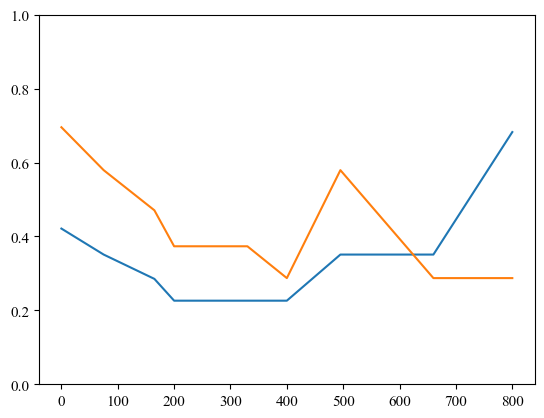

In [18]:
plt.plot(np.array(tsep_list)*1e12, np.array(energyM1_list)*1e9)
plt.plot(np.array(tsep_list)*1e12, np.array(energyM2_list)*1e9)
plt.ylim(0, 1)
plt.show()

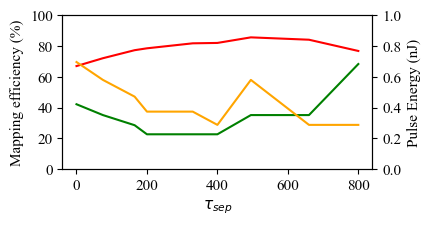

In [26]:
# Plotting
fig, ax1 = plt.subplots(figsize=(4, 2))

#ax1.scatter(np.array(energy_list_retrieve)*1e9, np.array(readin_list)*100)
ax1.plot(np.array(tsep_list)*1e12, np.array(eff_list)*100, color='red')
ax1.set_xlabel(r'$\tau_{sep}$')
ax1.set_ylabel('Mapping efficiency (%)')
ax1.set_ylim(0, 100)


# Creating a second y-axis for pulse energy
ax2 = ax1.twinx()
ax2.plot(np.array(tsep_list)*1e12, np.array(energyM1_list)*1e9, color='green')
ax2.plot(np.array(tsep_list)*1e12, np.array(energyM2_list)*1e9, color='orange')
ax2.set_ylabel('Pulse Energy (nJ)')
ax2.set_ylim(0, 1)

plt.savefig('ORCA_report/22032024_DRAGON_efficiency_vs_tsep.pdf') 
# Show the plot
plt.show()

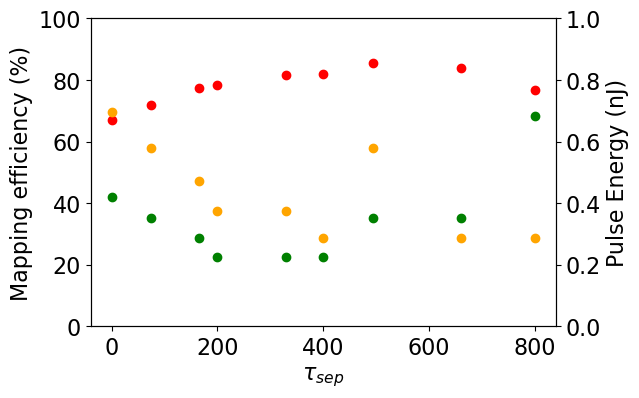

In [137]:
# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

#ax1.scatter(np.array(energy_list_retrieve)*1e9, np.array(readin_list)*100)
ax1.scatter(np.array(tsep_list)*1e12, np.array(eff_list)*100, color='red')
ax1.set_xlabel(r'$\tau_{sep}$')
ax1.set_ylabel('Mapping efficiency (%)')
ax1.set_ylim(0, 100)


# Creating a second y-axis for pulse energy
ax2 = ax1.twinx()
ax2.scatter(np.array(tsep_list)*1e12, np.array(energyM1_list)*1e9, color='green')
ax2.scatter(np.array(tsep_list)*1e12, np.array(energyM2_list)*1e9, color='orange')
ax2.set_ylabel('Pulse Energy (nJ)')
ax2.set_ylim(0, 1)

plt.savefig('ORCA_report/22032024_DRAGON_efficiency_vs_tsep_scatter.pdf') 
# Show the plot
plt.show()

# Include rephasing

In [7]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}, "intermediate2": {"n" : 5, "L": 1, "J" : 3/2}, 
                                                    "storage2": {"n" : 5, "L": 0, "F": 1}, "dressing": {"n" : 8, "L": 3, "J" : 7/2}}}
atom = AC.Rb87(config)

In [112]:
atom.gammas

array([19054665.80119383,  5568912.428391  , 19054665.80119383,
              0.        ,   812717.17238618])

In [15]:
tau = 0.5e-9
t0 = 1.5*tau
tend = 4.5e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

tauc = 330e-12
delay = 3e-9

control_factor = 1/6
Omega_M2_store = 0.51
atom.control_pulse_to_energy(np.sqrt(S.gaussian(t, t0+delay, tauc, np.array(2*np.pi*1e9*Omega_M2_store/control_factor)**2)), t, r=250e-6, index=0) * 1e12

1171.9942537030865

Mapping efficinecy (down) =  0.6760644465960295
Mapping efficinecy (up) =  0.019306067992279474


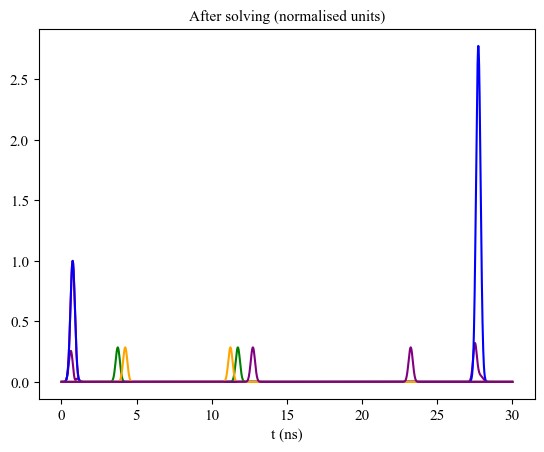

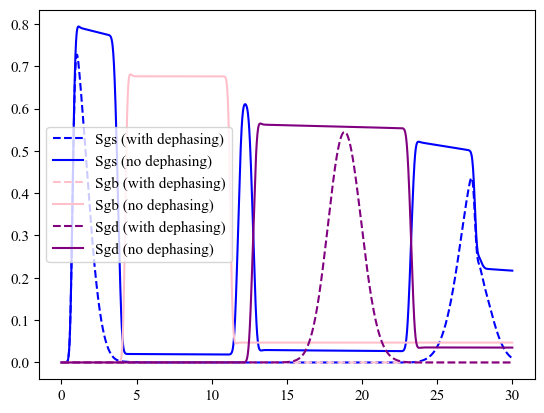

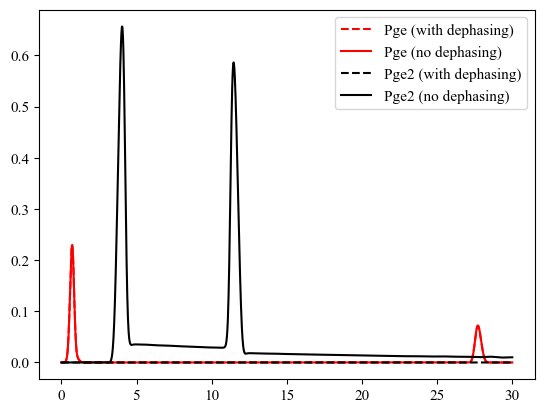

In [124]:
protocol = 'ORCA_DRAGON'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = 0
deltaM2 = 0
deltaD = 0

L = 0.075

t0 = 1.5*tau
tend = 30e-9 #210e-9
tbounds = np.array([0, tend])

m = 2000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

tauc = 330e-12 # 330 ps
Omega_store = 6e9
Omega_ret = 1e10
delay = 3e-9


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])

tsep = 495e-12
tstore = 7e-9
td_delay = 1e-9
t_rephasing = 3.5*delay

Omega_M1_store = 2*np.pi*1e9 * 0.51 #0.43428571428571433
Omega_M2_store = 2*np.pi*1e9 * 0.51 #0.43428571428571433

Omega_d = 2*np.pi*1e9*0.523

Omega_M1_ret = 2*np.pi*1e9 * 0.51 #0.43428571428571433
Omega_M2_ret = 2*np.pi*1e9 * 0.51 #0.43428571428571433

control_pol = np.array([1, 0])
Control = (S.gaussian(t, t0, tau, Omega_store) + S.gaussian(t, t0+delay+2*tsep+tstore+td_delay+2*t_rephasing-2*delay, tau, Omega_ret))[:, None] * control_pol[None, :]
M1 = np.sqrt(S.gaussian(t, t0+delay, tauc, Omega_M1_store**2) + S.gaussian(t, t0+delay+2*tsep+tstore, tauc, Omega_M1_ret**2))[:, None] * control_pol[None, :]
M2 = np.sqrt(S.gaussian(t, t0+delay+tsep, tauc, Omega_M2_store**2) + S.gaussian(t, t0+delay+tsep+tstore, tauc, Omega_M2_ret**2))[:, None] * control_pol[None, :]
D = np.sqrt(S.gaussian(t, t0+delay+2*tsep+tstore+td_delay, tauc, Omega_M2_store**2) + S.gaussian(t, t0+delay+2*tsep+tstore+td_delay+t_rephasing, tauc, Omega_M2_ret**2))[:, None] * control_pol[None, :]


sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2, deltaD], OD, L, n, m, tbounds, T, vno)

Control_tzp = sol.counter_prop( Control, zdef=0.5, field=0)
M1_tzp = sol.counter_prop( M1, zdef=0.5, field=1)
M2_tzp = sol.co_prop( M2 )
D_tzp = sol.counter_prop( D, zdef=0.5, field=3)

Controls = np.array([Control_tzp, M1_tzp, M2_tzp, D_tzp])

sol.solve(Controls, method='RK4-Ralston')

tidx = np.argmin(abs(t-5e-9))

print("Mapping efficinecy (down) = ", np.trapz( 
                np.einsum('zghqw -> z', 
                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[tidx], nan=0.0))),2)), 
                            sol.zCheby) )

tidx = np.argmin(abs(t-8e-9))

print("Mapping efficinecy (up) = ", np.trapz( 
                np.einsum('zghqw -> z', 
                            pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgs[tidx], nan=0.0))),2)), 
                            sol.zCheby) )

photon_norm = max(pow(np.abs(sol.E[:, 0, 0]),2))
control_norm = pow(np.abs(Omega_store), 2)

plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2)/photon_norm, color='red', label='Input signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2)/photon_norm, color='purple', label='Leaked signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.ER[:, -1, 0]),2)/photon_norm, color='black', label='Leaked bad signal intensity')
plt.plot(t*1e9, np.abs(Control[:, 0])**2/control_norm, color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (np.abs(M1[:, 0])**2/control_norm), color='green', label='M1 rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (np.abs(M2[:, 0])**2/control_norm), color='orange', label='M2 rabi frequency\n (scaled)')
plt.plot(t*1e9, (np.abs(D[:, 0])**2/control_norm), color='purple', label='Dressing rabi frequency\n (scaled)')
#plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('t (ns)')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()


Sgs_eff = np.array([sol.storage_efficiency(sol.Sgs, mi) for mi in range(m)])
Sgs_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgs[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Sgb_eff = np.array([sol.storage_efficiency(sol.Sgb, mi) for mi in range(m)])
Sgb_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Sgd_eff = np.array([sol.storage_efficiency(sol.Sgd, mi) for mi in range(m)])
Sgd_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgd[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Sgs_eff, label='Sgs (with dephasing)', color='b', linestyle='dashed')
plt.plot(t*1e9, Sgs_eff_ignore_phase, label='Sgs (no dephasing)', color='b')
plt.plot(t*1e9, Sgb_eff, label='Sgb (with dephasing)', color='pink', linestyle='dashed')
plt.plot(t*1e9, Sgb_eff_ignore_phase, label='Sgb (no dephasing)', color='pink')
plt.plot(t*1e9, Sgd_eff, label='Sgd (with dephasing)', color='purple', linestyle='dashed')
plt.plot(t*1e9, Sgd_eff_ignore_phase, label='Sgd (no dephasing)', color='purple')
plt.legend()
plt.show()


Pge_eff = np.array([sol.storage_efficiency(sol.Pge, mi) for mi in range(m)])
Pge_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Pge2_eff = np.array([sol.storage_efficiency(sol.Pge2, mi) for mi in range(m)])
Pge2_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge2[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Pge_eff, label='Pge (with dephasing)', color='r', linestyle='dashed')
plt.plot(t*1e9, Pge_eff_ignore_phase, label='Pge (no dephasing)', color='r')
plt.plot(t*1e9, Pge2_eff, label='Pge2 (with dephasing)', color='k', linestyle='dashed')
plt.plot(t*1e9, Pge2_eff_ignore_phase, label='Pge2 (no dephasing)', color='k')
plt.legend()
plt.show()


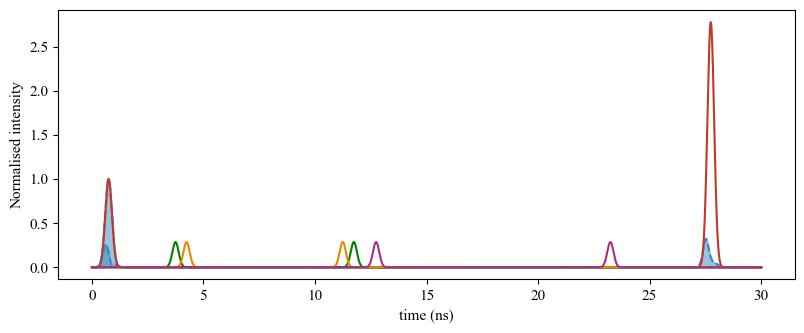

In [125]:
fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2)/photon_norm, color='#3788bfff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, 0, 0])**2 /photon_norm, color='#3788bfff', alpha=0.5)
ax.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2)/photon_norm, color='#3788bfff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, -1, 0])**2 /photon_norm, color='#3788bfff', alpha=0.5)
#ax.plot(t*1e9, pow(np.abs(sol.ER[:, -1, 0]),2)/photon_norm, color='black', label='Leaked bad signal intensity')
ax.plot(t*1e9, np.abs(Control[:, 0])**2/control_norm, color='#c0392bff', label='Control field rabi frequency\n (scaled - half way through cell)')
ax.plot(t*1e9, (np.abs(M1[:, 0])**2/control_norm), color='#008000ff', label='M1 rabi frequency\n (scaled - half way through cell)')
ax.plot(t*1e9, (np.abs(M2[:, 0])**2/control_norm), color='#ee8500ff', label='M2 rabi frequency\n (scaled)')
ax.plot(t*1e9, (np.abs(D[:, 0])**2/control_norm), color='#a82e84ff', label='Dressing rabi frequency\n (scaled)')
#ax.plot(t*1e9, np.zeros(len(t)), color='k')
#plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.savefig('ORCA_report/09042024_ORCA_DRAGON_full_pulse_sequence.pdf')
plt.show()

# Optimise DRAGON

In [5]:
import nlopt

## FWHM = 330ps

In [7]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}, "intermediate2": {"n" : 5, "L": 1, "J" : 3/2}, 
                                                    "storage2": {"n" : 5, "L": 0, "F": 1}}}
atom = AC.Rb87(config)

protocol = 'ORCA'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 1.5*tau
tend = 5e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

Omega_store = 8e9

control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
sol.gammaS = 1/480e-9
sol.gammaSNU = sol.gammaS/sol.gamma

Control_tp = (Control_store)[:, None] * control_pol[None, :]
Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

sol.solve(Control_tzp, method='RK4-Ralston')

readin_window = [t0-tau, t0+tau]
#readout_window = [t0+tr-400e-12*gamma, t0+tr+100e-12*gamma]

readin_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readin_window[0])),
                        min(range(len(t)), key=lambda i:abs(t[i]-readin_window[1]))]


norm = np.trapz( pow(np.abs(sol.E[:, 0, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )

stored = 1-np.trapz( pow(np.abs(sol.E[:, -1, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )/norm

print(stored)

0.7494752859828264


In [12]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}, "intermediate2": {"n" : 5, "L": 1, "J" : 3/2}, 
                                                    "storage2": {"n" : 5, "L": 0, "F": 1}}}
atom = AC.Rb87(config)

def objective_function(x, grad):

    [t0_M1, A_M1, delta_M1, t0_M2, A_M2, delta_M2] = x

    FWHM_M1 = 330e-12
    FWHM_M2 = 330e-12

    if grad.size > 0:
        grad[:] = 0
    
    protocol = 'ORCA_GSM'
    OD = 10000
    #BW = 2*np.pi*1e9
    tau = 0.5e-9
    n = 50
    T = 273.15 + 90
    vno = 30
    detuning = 2*np.pi*6e9

    deltaS = -detuning 
    deltaC = detuning
    deltaM1 = delta_M1*2*np.pi*1e9
    deltaM2 = delta_M2*2*np.pi*1e9


    L = 0.075

    t0 = 1.5*tau
    tend = 6e-9 #210e-9
    tbounds = np.array([0, tend])

    m = 2000
    t = np.linspace(0, tend, m)

    photon_pol = np.array([1, 0]) #should be normalised
    Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]
    
    Omega_store = 8e9


    control_pol = np.array([1, 0])
    Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
    M1_store = np.sqrt((S.gaussian(t, t0+t0_M1*1e-9, FWHM_M1, (2*np.pi*1e9*A_M1)**2)))[:, None] * control_pol[None, :]
    M2_store = np.sqrt((S.gaussian(t, t0+t0_M2*1e-9, FWHM_M2, (2*np.pi*1e9*A_M2)**2)))[:, None] * control_pol[None, :]


    Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])
    
    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)
    sol.gammaS = 1/84e-9
    sol.gammaSNU = sol.gammaS/sol.gamma

    Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
    M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
    M2_tzp = sol.co_prop( M2_store )

    Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

    sol.solve(Controls, method='RK4-Ralston')

    Sgb_eff_no_dephasing = np.trapz( np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                sol.zCheby)

    metric = Sgb_eff_no_dephasing/stored

    # print( f"x = {x} \n")
    # print( f"Efficiency = {metric}" )

    return metric

### Lots of control power

In [13]:
algorithm = nlopt.GN_CRS2_LM

A_M1 = 8 # units of 2*np.pi*1e9
t0_M1 = 3.33 # units of ns delay after t0
delta_M1 = 0 # units of 2*np.pi*1e9

A_M2 = 8 # units of 2*np.pi*1e9
t0_M2 = 3 # units of ns delay after t0
delta_M2 = 0 # units of 2*np.pi*1e9

x = np.array([t0_M1, A_M1, delta_M1, t0_M2, A_M2, delta_M2])

optimiser = nlopt.opt(algorithm, len(x))
optimiser.set_max_objective(objective_function)

lb = np.array([0, 0.1, -2, 0, 0.1, -2])
ub = np.array([5, 10, 2, 5, 10, 2])
optimiser.set_lower_bounds(lb)
optimiser.set_upper_bounds(ub)

ftol = 1e-3
maxeval = 100
optimiser.set_ftol_rel(ftol)
optimiser.set_maxeval(maxeval)

xopt = optimiser.optimize(x)
result = optimiser.last_optimum_value()

print("xopt = ", xopt)
print("Efficiency = ", result)

xopt =  [ 2.09636516  8.26895297  0.97599167  1.77866762 10.         -0.03993963]
Efficiency =  0.910705664222389


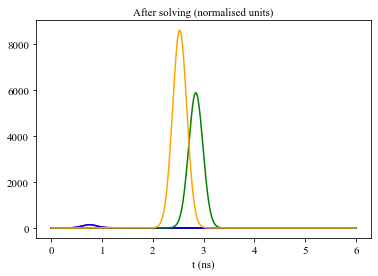

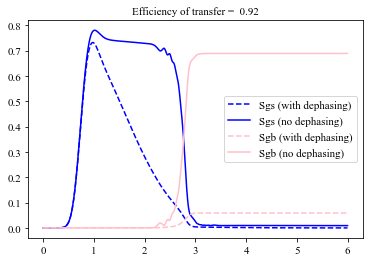

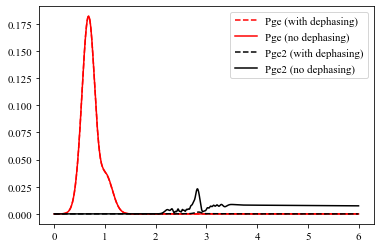

In [14]:
# A_M1 = 1 # units of 2*np.pi*1e9
# t0_M1 = 1 # units of ns delay after t0
# delta_M1 = 0 # units of 2*np.pi*1e9

# A_M2 = 1 # units of 2*np.pi*1e9
# t0_M2 = 1 # units of ns delay after t0
# delta_M2 = 0 # units of 2*np.pi*1e9

# x = np.array([t0_M1, A_M1, delta_M1, t0_M2, A_M2, delta_M2])

# [t0_M1, A_M1, delta_M1, t0_M2, A_M2, delta_M2] = x

[t0_M1, A_M1, delta_M1, t0_M2, A_M2, delta_M2] = xopt
FWHM_M1 = 330e-12
FWHM_M2 = 330e-12


protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = delta_M1*2*np.pi*1e9
deltaM2 = delta_M2*2*np.pi*1e9

L = 0.075

t0 = 1.5*tau
tend = 6e-9 #210e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Omega_store = 8e9

control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
M1_store = np.sqrt(S.gaussian(t, t0+t0_M1*1e-9, FWHM_M1, (2*np.pi*1e9*A_M1)**2))[:, None] * control_pol[None, :]
M2_store = np.sqrt(S.gaussian(t, t0+t0_M2*1e-9, FWHM_M2, (2*np.pi*1e9*A_M2)**2))[:, None] * control_pol[None, :]


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])


sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)
sol.gammaS = 1/84e-9
sol.gammaSNU = sol.gammaS/sol.gamma

Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
M2_tzp = sol.co_prop( M2_store )

Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

sol.solve(Controls, method='RK4-Ralston')

plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.ER[:, -1, 0]),2), color='black', label='Leaked bad signal intensity')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store**2)*np.abs(Control_store[:, 0])**2, color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store**2)*np.abs(M1_store[:, 0])**2, color='green', label='M1 rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store**2)*np.abs(M2_store[:, 0])**2, color='orange', label='M2 rabi frequency\n (scaled)')
#plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('t (ns)')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()


Sgs_eff = np.array([sol.storage_efficiency(sol.Sgs, mi) for mi in range(m)])
Sgs_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgs[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Sgb_eff = np.array([sol.storage_efficiency(sol.Sgb, mi) for mi in range(m)])
Sgb_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Sgs_eff, label='Sgs (with dephasing)', color='b', linestyle='dashed')
plt.plot(t*1e9, Sgs_eff_ignore_phase, label='Sgs (no dephasing)', color='b')
plt.plot(t*1e9, Sgb_eff, label='Sgb (with dephasing)', color='pink', linestyle='dashed')
plt.plot(t*1e9, Sgb_eff_ignore_phase, label='Sgb (no dephasing)', color='pink')
plt.title(f'Efficiency of transfer = {Sgb_eff_ignore_phase[-1]/stored: .2f}')
plt.legend()
plt.show()


Pge_eff = np.array([sol.storage_efficiency(sol.Pge, mi) for mi in range(m)])
Pge_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Pge2_eff = np.array([sol.storage_efficiency(sol.Pge2, mi) for mi in range(m)])
Pge2_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge2[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Pge_eff, label='Pge (with dephasing)', color='r', linestyle='dashed')
plt.plot(t*1e9, Pge_eff_ignore_phase, label='Pge (no dephasing)', color='r')
plt.plot(t*1e9, Pge2_eff, label='Pge2 (with dephasing)', color='k', linestyle='dashed')
plt.plot(t*1e9, Pge2_eff_ignore_phase, label='Pge2 (no dephasing)', color='k')
plt.legend()
plt.show()

### Restricted control power

In [15]:
algorithm = nlopt.GN_CRS2_LM

A_M1 = 0.55 # units of 2*np.pi*1e9
t0_M1 = 3 # units of ns delay after t0
delta_M1 = 0 # units of 2*np.pi*1e9

A_M2 = 0.55 # units of 2*np.pi*1e9
t0_M2 = 3.33 # units of ns delay after t0
delta_M2 = 0 # units of 2*np.pi*1e9

x = np.array([t0_M1, A_M1, delta_M1, t0_M2, A_M2, delta_M2])

optimiser = nlopt.opt(algorithm, len(x))
optimiser.set_max_objective(objective_function)

lb = np.array([0, 0.1, -2, 0, 0.1, -2])
ub = np.array([5, 3, 2, 5, 3, 2])
optimiser.set_lower_bounds(lb)
optimiser.set_upper_bounds(ub)

ftol = 1e-3
maxeval = 100
optimiser.set_ftol_rel(ftol)
optimiser.set_maxeval(maxeval)

xopt = optimiser.optimize(x)
result = optimiser.last_optimum_value()

print("xopt = ", xopt)
print("Efficiency = ", result)

xopt =  [3.   0.55 0.   3.33 0.55 0.  ]
Efficiency =  0.8194528402338217


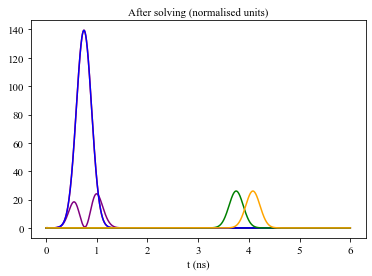

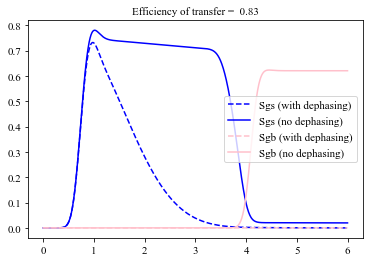

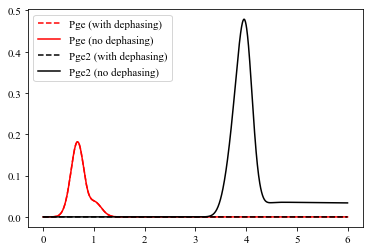

In [16]:
# A_M1 = 1 # units of 2*np.pi*1e9
# t0_M1 = 1 # units of ns delay after t0
# delta_M1 = 0 # units of 2*np.pi*1e9

# A_M2 = 1 # units of 2*np.pi*1e9
# t0_M2 = 1 # units of ns delay after t0
# delta_M2 = 0 # units of 2*np.pi*1e9

# x = np.array([t0_M1, A_M1, delta_M1, t0_M2, A_M2, delta_M2])

# [t0_M1, A_M1, delta_M1, t0_M2, A_M2, delta_M2] = x

[t0_M1, A_M1, delta_M1, t0_M2, A_M2, delta_M2] = xopt
FWHM_M1 = 330e-12
FWHM_M2 = 330e-12


protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = delta_M1*2*np.pi*1e9
deltaM2 = delta_M2*2*np.pi*1e9

L = 0.075

t0 = 1.5*tau
tend = 6e-9 #210e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Omega_store = 8e9

control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
M1_store = np.sqrt(S.gaussian(t, t0+t0_M1*1e-9, FWHM_M1, (2*np.pi*1e9*A_M1)**2))[:, None] * control_pol[None, :]
M2_store = np.sqrt(S.gaussian(t, t0+t0_M2*1e-9, FWHM_M2, (2*np.pi*1e9*A_M2)**2))[:, None] * control_pol[None, :]


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])


sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)
sol.gammaS = 1/84e-9
sol.gammaSNU = sol.gammaS/sol.gamma

Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
M2_tzp = sol.co_prop( M2_store )

Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

sol.solve(Controls, method='RK4-Ralston')

plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.ER[:, -1, 0]),2), color='black', label='Leaked bad signal intensity')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store**2)*np.abs(Control_store[:, 0])**2, color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store**2)*np.abs(M1_store[:, 0])**2, color='green', label='M1 rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store**2)*np.abs(M2_store[:, 0])**2, color='orange', label='M2 rabi frequency\n (scaled)')
#plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('t (ns)')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()


Sgs_eff = np.array([sol.storage_efficiency(sol.Sgs, mi) for mi in range(m)])
Sgs_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgs[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Sgb_eff = np.array([sol.storage_efficiency(sol.Sgb, mi) for mi in range(m)])
Sgb_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Sgs_eff, label='Sgs (with dephasing)', color='b', linestyle='dashed')
plt.plot(t*1e9, Sgs_eff_ignore_phase, label='Sgs (no dephasing)', color='b')
plt.plot(t*1e9, Sgb_eff, label='Sgb (with dephasing)', color='pink', linestyle='dashed')
plt.plot(t*1e9, Sgb_eff_ignore_phase, label='Sgb (no dephasing)', color='pink')
plt.title(f'Efficiency of transfer = {Sgb_eff_ignore_phase[-1]/stored: .2f}')
plt.legend()
plt.show()


Pge_eff = np.array([sol.storage_efficiency(sol.Pge, mi) for mi in range(m)])
Pge_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Pge2_eff = np.array([sol.storage_efficiency(sol.Pge2, mi) for mi in range(m)])
Pge2_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge2[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Pge_eff, label='Pge (with dephasing)', color='r', linestyle='dashed')
plt.plot(t*1e9, Pge_eff_ignore_phase, label='Pge (no dephasing)', color='r')
plt.plot(t*1e9, Pge2_eff, label='Pge2 (with dephasing)', color='k', linestyle='dashed')
plt.plot(t*1e9, Pge2_eff_ignore_phase, label='Pge2 (no dephasing)', color='k')
plt.legend()
plt.show()

## Any gaussian shape

In [5]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}, "intermediate2": {"n" : 5, "L": 1, "J" : 3/2}, 
                                                    "storage2": {"n" : 5, "L": 0, "F": 1}}}
atom = AC.Rb87(config)

protocol = 'ORCA'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

L = 0.075

t0 = 1.5*tau
tend = 5e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Sinits = np.zeros((n, 1, 1, 1, 1, vno))

Omega_store = 8e9

control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
sol.gammaS = 1/480e-9
sol.gammaSNU = sol.gammaS/sol.gamma

Control_tp = (Control_store)[:, None] * control_pol[None, :]
Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

sol.solve(Control_tzp, method='RK4-Ralston')

readin_window = [t0-tau, t0+tau]
#readout_window = [t0+tr-400e-12*gamma, t0+tr+100e-12*gamma]

readin_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readin_window[0])),
                        min(range(len(t)), key=lambda i:abs(t[i]-readin_window[1]))]


norm = np.trapz( pow(np.abs(sol.E[:, 0, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )

stored = 1-np.trapz( pow(np.abs(sol.E[:, -1, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )/norm

print(stored)

0.7494752859828264


In [13]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}, "intermediate2": {"n" : 5, "L": 1, "J" : 3/2}, 
                                                    "storage2": {"n" : 5, "L": 0, "F": 1}}}
atom = AC.Rb87(config)

def objective_function(x, grad):

    [t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2] = x

    if grad.size > 0:
        grad[:] = 0
    
    protocol = 'ORCA_GSM'
    OD = 10000
    #BW = 2*np.pi*1e9
    tau = 0.5e-9
    n = 50
    T = 273.15 + 90
    vno = 30
    detuning = 2*np.pi*6e9

    deltaS = -detuning 
    deltaC = detuning
    deltaM1 = delta_M1*2*np.pi*1e9
    deltaM2 = delta_M2*2*np.pi*1e9


    L = 0.075

    t0 = 1.5*tau
    tend = 6e-9 #210e-9
    tbounds = np.array([0, tend])

    m = 1000
    t = np.linspace(0, tend, m)

    photon_pol = np.array([1, 0]) #should be normalised
    Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]
    
    Omega_store = 8e9


    control_pol = np.array([1, 0])
    Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
    M1_store = (S.gaussian(t, t0+t0_M1*1e-9, FWHM_M1*tau, 2*np.pi*1e9*A_M1))[:, None] * control_pol[None, :]
    M2_store = (S.gaussian(t, t0+t0_M2*1e-9, FWHM_M2*tau, 2*np.pi*1e9*A_M2))[:, None] * control_pol[None, :]


    Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])
    
    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)
    sol.gammaS = 1/480e-9
    sol.gammaSNU = sol.gammaS/sol.gamma

    Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
    M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
    M2_tzp = sol.co_prop( M2_store )

    Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

    sol.solve(Controls, method='RK4-Ralston')

    Sgb_eff_no_dephasing = np.trapz( np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[-1], nan=0.0))),2)), 
                                sol.zCheby)

    metric = Sgb_eff_no_dephasing/stored

    # print( f"x = {x} \n")
    # print( f"Efficiency = {metric}" )

    return metric

In [11]:
algorithm = nlopt.LN_COBYLA

A_M1 = 1 # units of 2*np.pi*1e9
FWHM_M1 = 1 # units of tau
t0_M1 = 1 # units of ns delay after t0
delta_M1 = 0 # units of 2*np.pi*1e9

A_M2 = 1 # units of 2*np.pi*1e9
FWHM_M2 = 1 # units of tau
t0_M2 = 1 # units of ns delay after t0
delta_M2 = 0 # units of 2*np.pi*1e9

x = np.array([t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2])

optimiser = nlopt.opt(algorithm, len(x))
optimiser.set_max_objective(objective_function)

lb = np.array([0, 0.1, 0, -2, 0, 0.1, 0, -2])
ub = np.array([5, 3, 10, 2, 5, 3, 10, 2])
optimiser.set_lower_bounds(lb)
optimiser.set_upper_bounds(ub)

ftol = 1e-2
maxeval = 100
optimiser.set_ftol_rel(0.01)
optimiser.set_maxeval(maxeval)

xopt = optimiser.optimize(x)
result = optimiser.last_optimum_value()

print("xopt = ", xopt)
print("Efficiency = ", result)

x = [1. 1. 1. 0. 1. 1. 1. 0.] 

Efficiency = 0.34303141840945195
x = [1.75 1.   1.   0.   1.   1.   1.   0.  ] 

Efficiency = 0.008098751643233119
x = [1.    1.725 1.    0.    1.    1.    1.    0.   ] 

Efficiency = 0.2731234738145151
x = [1.   1.   1.75 0.   1.   1.   1.   0.  ] 

Efficiency = 0.29407694327943035
x = [1. 1. 1. 1. 1. 1. 1. 0.] 

Efficiency = 0.1833165454829146
x = [1.   1.   1.   0.   1.75 1.   1.   0.  ] 

Efficiency = 0.017859861822750657
x = [1.    1.    1.    0.    1.    1.725 1.    0.   ] 

Efficiency = 0.2617556136144669
x = [1.   1.   1.   0.   1.   1.   1.75 0.  ] 

Efficiency = 0.2879862389705582
x = [1. 1. 1. 0. 1. 1. 1. 1.] 

Efficiency = 0.14940527808738013
x = [ 0.53971125  0.90712985  0.93272321 -0.29265568  0.55312567  0.89202807
  0.92435292 -0.35479344] 

Efficiency = 0.1397896933767402
x = [ 0.76985562  0.95356493  0.96636161 -0.14632784  0.77656284  0.94601403
  0.96217646 -0.17739672] 

Efficiency = 0.2437318860756407
x = [ 1.16831987  0.98704344  0

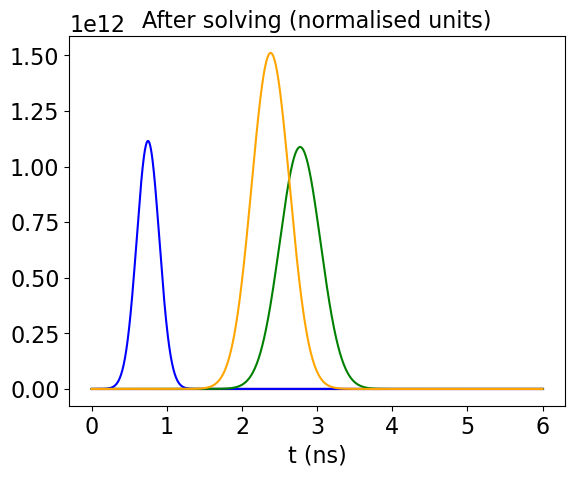

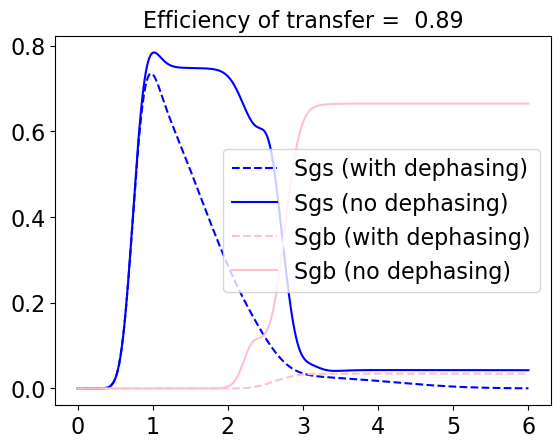

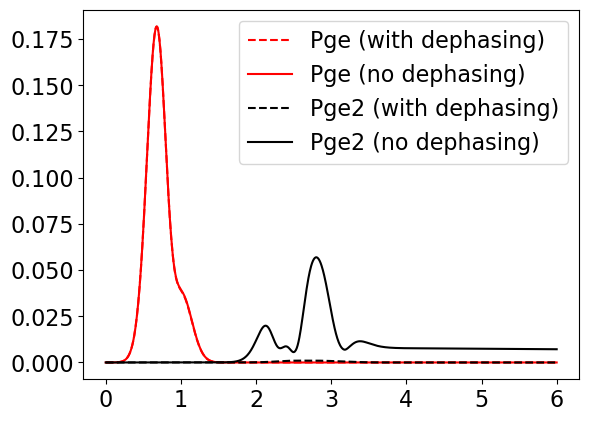

In [12]:
# A_M1 = 1 # units of 2*np.pi*1e9
# FWHM_M1 = 1 # units of tau
# t0_M1 = 1 # units of ns delay after t0
# delta_M1 = 0 # units of 2*np.pi*1e9

# A_M2 = 1 # units of 2*np.pi*1e9
# FWHM_M2 = 1 # units of tau
# t0_M2 = 1 # units of ns delay after t0
# delta_M2 = 0 # units of 2*np.pi*1e9

# x = np.array([t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2])

# [t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2] = x

[t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2] = xopt


protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = delta_M1*2*np.pi*1e9
deltaM2 = delta_M2*2*np.pi*1e9

L = 0.075

t0 = 1.5*tau
tend = 6e-9 #210e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Omega_store = 8e9

control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
M1_store = (S.gaussian(t, t0+t0_M1*1e-9, FWHM_M1*tau, 2*np.pi*1e9*A_M1))[:, None] * control_pol[None, :]
M2_store = (S.gaussian(t, t0+t0_M2*1e-9, FWHM_M2*tau, 2*np.pi*1e9*A_M2))[:, None] * control_pol[None, :]


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])


sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)
sol.gammaS = 1/480e-9
sol.gammaSNU = sol.gammaS/sol.gamma

Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
M2_tzp = sol.co_prop( M2_store )

Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

sol.solve(Controls, method='RK4-Ralston')

plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.ER[:, -1, 0]),2), color='black', label='Leaked bad signal intensity')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(Control_store[:, 0])**2, color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M1_store[:, 0])**2, color='green', label='M1 rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M2_store[:, 0])**2, color='orange', label='M2 rabi frequency\n (scaled)')
#plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('t (ns)')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()


Sgs_eff = np.array([sol.storage_efficiency(sol.Sgs, mi) for mi in range(m)])
Sgs_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgs[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Sgb_eff = np.array([sol.storage_efficiency(sol.Sgb, mi) for mi in range(m)])
Sgb_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Sgs_eff, label='Sgs (with dephasing)', color='b', linestyle='dashed')
plt.plot(t*1e9, Sgs_eff_ignore_phase, label='Sgs (no dephasing)', color='b')
plt.plot(t*1e9, Sgb_eff, label='Sgb (with dephasing)', color='pink', linestyle='dashed')
plt.plot(t*1e9, Sgb_eff_ignore_phase, label='Sgb (no dephasing)', color='pink')
plt.title(f'Efficiency of transfer = {Sgb_eff_ignore_phase[-1]/stored: .2f}')
plt.legend()
plt.show()


Pge_eff = np.array([sol.storage_efficiency(sol.Pge, mi) for mi in range(m)])
Pge_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Pge2_eff = np.array([sol.storage_efficiency(sol.Pge2, mi) for mi in range(m)])
Pge2_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge2[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Pge_eff, label='Pge (with dephasing)', color='r', linestyle='dashed')
plt.plot(t*1e9, Pge_eff_ignore_phase, label='Pge (no dephasing)', color='r')
plt.plot(t*1e9, Pge2_eff, label='Pge2 (with dephasing)', color='k', linestyle='dashed')
plt.plot(t*1e9, Pge2_eff_ignore_phase, label='Pge2 (no dephasing)', color='k')
plt.legend()
plt.show()

In [18]:
algorithm = nlopt.LN_SBPLX

A_M1 = 0.55 # units of 2*np.pi*1e9
FWHM_M1 = 1 # units of tau
t0_M1 = 3 # units of ns delay after t0
delta_M1 = 0 # units of 2*np.pi*1e9

A_M2 = 0.55 # units of 2*np.pi*1e9
FWHM_M2 = 1 # units of tau
t0_M2 = 3.5 # units of ns delay after t0
delta_M2 = 0 # units of 2*np.pi*1e9

x = np.array([t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2])

optimiser = nlopt.opt(algorithm, len(x))
optimiser.set_max_objective(objective_function)

lb = np.array([0, 0.1, 0, -2, 0, 0.1, 0, -2])
ub = np.array([5, 3, 10, 2, 5, 3, 10, 2])
optimiser.set_lower_bounds(lb)
optimiser.set_upper_bounds(ub)

ftol = 1e-3
maxeval = 100
optimiser.set_ftol_rel(ftol)
optimiser.set_maxeval(maxeval)

xopt = optimiser.optimize(x)
result = optimiser.last_optimum_value()

print("xopt = ", xopt)
print("Efficiency = ", result)

xopt =  [3.52554294 0.88813477 0.55       0.         3.97738974 0.81875
 0.56117859 0.02441406]
Efficiency =  0.8895429808313412


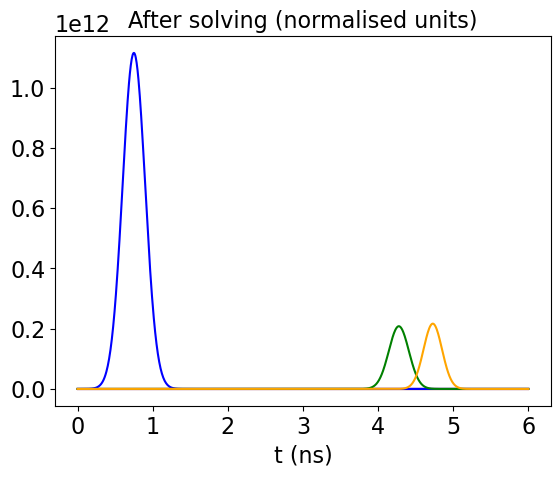

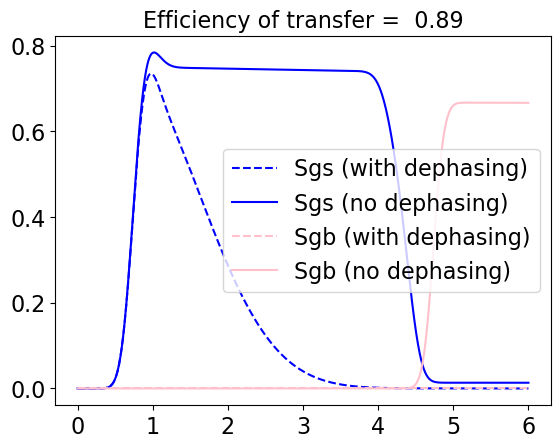

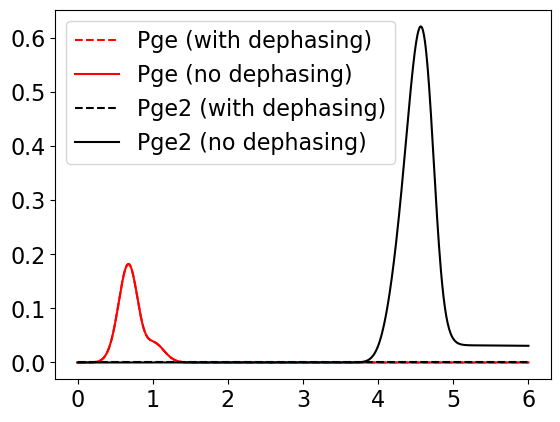

In [19]:
# A_M1 = 1 # units of 2*np.pi*1e9
# FWHM_M1 = 1 # units of tau
# t0_M1 = 1 # units of ns delay after t0
# delta_M1 = 0 # units of 2*np.pi*1e9

# A_M2 = 1 # units of 2*np.pi*1e9
# FWHM_M2 = 1 # units of tau
# t0_M2 = 1 # units of ns delay after t0
# delta_M2 = 0 # units of 2*np.pi*1e9

# x = np.array([t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2])

# [t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2] = x

[t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2] = xopt


protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = delta_M1*2*np.pi*1e9
deltaM2 = delta_M2*2*np.pi*1e9

L = 0.075

t0 = 1.5*tau
tend = 6e-9 #210e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Omega_store = 8e9

control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
M1_store = (S.gaussian(t, t0+t0_M1*1e-9, FWHM_M1*tau, 2*np.pi*1e9*A_M1))[:, None] * control_pol[None, :]
M2_store = (S.gaussian(t, t0+t0_M2*1e-9, FWHM_M2*tau, 2*np.pi*1e9*A_M2))[:, None] * control_pol[None, :]


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])


sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)
sol.gammaS = 1/480e-9
sol.gammaSNU = sol.gammaS/sol.gamma

Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
M2_tzp = sol.co_prop( M2_store )

Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

sol.solve(Controls, method='RK4-Ralston')

plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.ER[:, -1, 0]),2), color='black', label='Leaked bad signal intensity')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(Control_store[:, 0])**2, color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M1_store[:, 0])**2, color='green', label='M1 rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M2_store[:, 0])**2, color='orange', label='M2 rabi frequency\n (scaled)')
#plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('t (ns)')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()


Sgs_eff = np.array([sol.storage_efficiency(sol.Sgs, mi) for mi in range(m)])
Sgs_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgs[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Sgb_eff = np.array([sol.storage_efficiency(sol.Sgb, mi) for mi in range(m)])
Sgb_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Sgs_eff, label='Sgs (with dephasing)', color='b', linestyle='dashed')
plt.plot(t*1e9, Sgs_eff_ignore_phase, label='Sgs (no dephasing)', color='b')
plt.plot(t*1e9, Sgb_eff, label='Sgb (with dephasing)', color='pink', linestyle='dashed')
plt.plot(t*1e9, Sgb_eff_ignore_phase, label='Sgb (no dephasing)', color='pink')
plt.title(f'Efficiency of transfer = {Sgb_eff_ignore_phase[-1]/stored: .2f}')
plt.legend()
plt.show()


Pge_eff = np.array([sol.storage_efficiency(sol.Pge, mi) for mi in range(m)])
Pge_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Pge2_eff = np.array([sol.storage_efficiency(sol.Pge2, mi) for mi in range(m)])
Pge2_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge2[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Pge_eff, label='Pge (with dephasing)', color='r', linestyle='dashed')
plt.plot(t*1e9, Pge_eff_ignore_phase, label='Pge (no dephasing)', color='r')
plt.plot(t*1e9, Pge2_eff, label='Pge2 (with dephasing)', color='k', linestyle='dashed')
plt.plot(t*1e9, Pge2_eff_ignore_phase, label='Pge2 (no dephasing)', color='k')
plt.legend()
plt.show()

In [20]:
algorithm = nlopt.GN_CRS2_LM

A_M1 = 0.55 # units of 2*np.pi*1e9
FWHM_M1 = 1 # units of tau
t0_M1 = 3 # units of ns delay after t0
delta_M1 = 0 # units of 2*np.pi*1e9

A_M2 = 0.55 # units of 2*np.pi*1e9
FWHM_M2 = 1 # units of tau
t0_M2 = 3.5 # units of ns delay after t0
delta_M2 = 0 # units of 2*np.pi*1e9

x = np.array([t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2])

optimiser = nlopt.opt(algorithm, len(x))
optimiser.set_max_objective(objective_function)

lb = np.array([0, 0.1, 0, -2, 0, 0.1, 0, -2])
ub = np.array([5, 3, 10, 2, 5, 3, 10, 2])
optimiser.set_lower_bounds(lb)
optimiser.set_upper_bounds(ub)

ftol = 1e-3
maxeval = 100
optimiser.set_ftol_rel(ftol)
optimiser.set_maxeval(maxeval)

xopt = optimiser.optimize(x)
result = optimiser.last_optimum_value()

print("xopt = ", xopt)
print("Efficiency = ", result)

xopt =  [ 2.20881012  2.23399485  6.38129226  0.26130887  1.23560098  2.0219819
  6.92434638 -0.01222906]
Efficiency =  0.9795783147480955


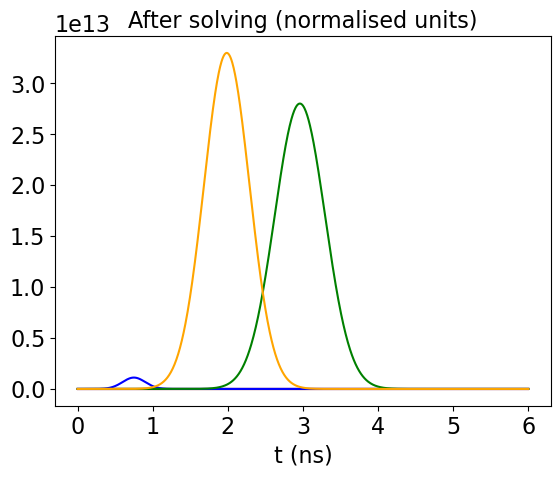

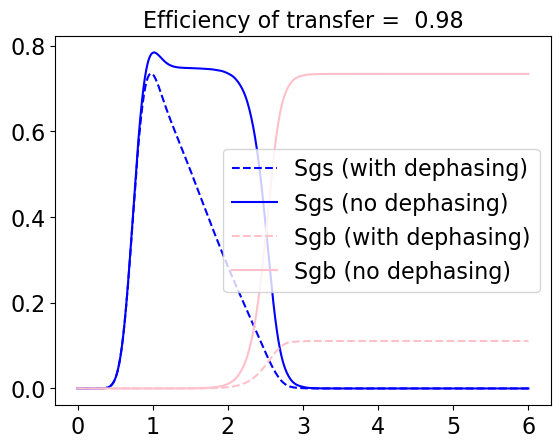

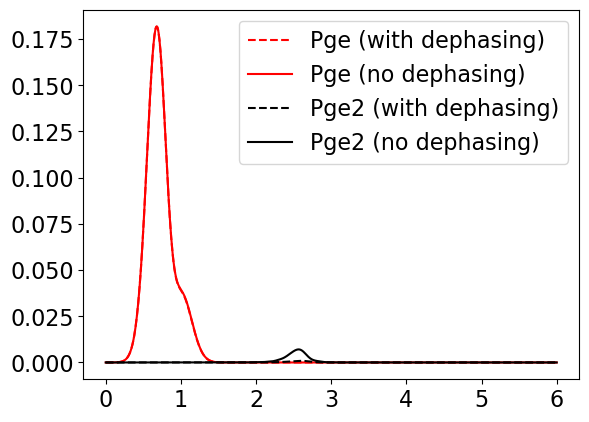

In [21]:
# A_M1 = 1 # units of 2*np.pi*1e9
# FWHM_M1 = 1 # units of tau
# t0_M1 = 1 # units of ns delay after t0
# delta_M1 = 0 # units of 2*np.pi*1e9

# A_M2 = 1 # units of 2*np.pi*1e9
# FWHM_M2 = 1 # units of tau
# t0_M2 = 1 # units of ns delay after t0
# delta_M2 = 0 # units of 2*np.pi*1e9

# x = np.array([t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2])

# [t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2] = x

[t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2] = xopt


protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = delta_M1*2*np.pi*1e9
deltaM2 = delta_M2*2*np.pi*1e9

L = 0.075

t0 = 1.5*tau
tend = 6e-9 #210e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Omega_store = 8e9

control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
M1_store = (S.gaussian(t, t0+t0_M1*1e-9, FWHM_M1*tau, 2*np.pi*1e9*A_M1))[:, None] * control_pol[None, :]
M2_store = (S.gaussian(t, t0+t0_M2*1e-9, FWHM_M2*tau, 2*np.pi*1e9*A_M2))[:, None] * control_pol[None, :]


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])


sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)
sol.gammaS = 1/480e-9
sol.gammaSNU = sol.gammaS/sol.gamma

Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
M2_tzp = sol.co_prop( M2_store )

Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

sol.solve(Controls, method='RK4-Ralston')

plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.ER[:, -1, 0]),2), color='black', label='Leaked bad signal intensity')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(Control_store[:, 0])**2, color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M1_store[:, 0])**2, color='green', label='M1 rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M2_store[:, 0])**2, color='orange', label='M2 rabi frequency\n (scaled)')
#plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('t (ns)')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()


Sgs_eff = np.array([sol.storage_efficiency(sol.Sgs, mi) for mi in range(m)])
Sgs_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgs[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Sgb_eff = np.array([sol.storage_efficiency(sol.Sgb, mi) for mi in range(m)])
Sgb_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Sgs_eff, label='Sgs (with dephasing)', color='b', linestyle='dashed')
plt.plot(t*1e9, Sgs_eff_ignore_phase, label='Sgs (no dephasing)', color='b')
plt.plot(t*1e9, Sgb_eff, label='Sgb (with dephasing)', color='pink', linestyle='dashed')
plt.plot(t*1e9, Sgb_eff_ignore_phase, label='Sgb (no dephasing)', color='pink')
plt.title(f'Efficiency of transfer = {Sgb_eff_ignore_phase[-1]/stored: .2f}')
plt.legend()
plt.show()


Pge_eff = np.array([sol.storage_efficiency(sol.Pge, mi) for mi in range(m)])
Pge_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Pge2_eff = np.array([sol.storage_efficiency(sol.Pge2, mi) for mi in range(m)])
Pge2_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge2[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Pge_eff, label='Pge (with dephasing)', color='r', linestyle='dashed')
plt.plot(t*1e9, Pge_eff_ignore_phase, label='Pge (no dephasing)', color='r')
plt.plot(t*1e9, Pge2_eff, label='Pge2 (with dephasing)', color='k', linestyle='dashed')
plt.plot(t*1e9, Pge2_eff_ignore_phase, label='Pge2 (no dephasing)', color='k')
plt.legend()
plt.show()

## Restrict mapping field amplitude more

In [22]:
algorithm = nlopt.GN_CRS2_LM

A_M1 = 0.55 # units of 2*np.pi*1e9
FWHM_M1 = 1 # units of tau
t0_M1 = 3 # units of ns delay after t0
delta_M1 = 0 # units of 2*np.pi*1e9

A_M2 = 0.55 # units of 2*np.pi*1e9
FWHM_M2 = 1 # units of tau
t0_M2 = 3.5 # units of ns delay after t0
delta_M2 = 0 # units of 2*np.pi*1e9

x = np.array([t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2])

optimiser = nlopt.opt(algorithm, len(x))
optimiser.set_max_objective(objective_function)

lb = np.array([0, 0.1, 0, -2, 0, 0.1, 0, -2])
ub = np.array([5, 3, 2, 2, 5, 3, 2, 2])
optimiser.set_lower_bounds(lb)
optimiser.set_upper_bounds(ub)

ftol = 1e-3
maxeval = 100
optimiser.set_ftol_rel(ftol)
optimiser.set_maxeval(maxeval)

xopt = optimiser.optimize(x)
result = optimiser.last_optimum_value()

print("xopt = ", xopt)
print("Efficiency = ", result)

xopt =  [ 4.10522127  1.77025197  1.66416755  1.67748669  3.87633716  2.24052021
  1.45461371 -1.32310348]
Efficiency =  0.8243803260659078


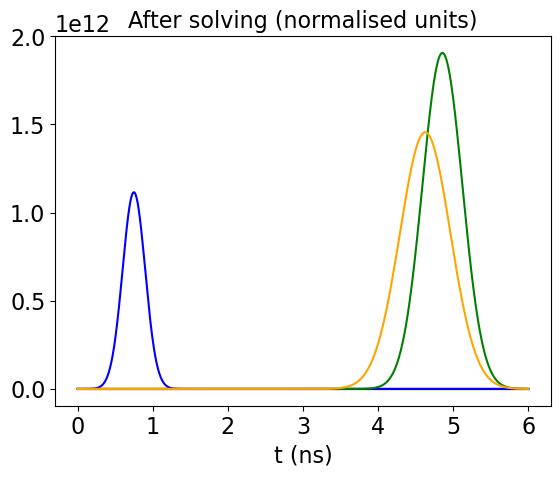

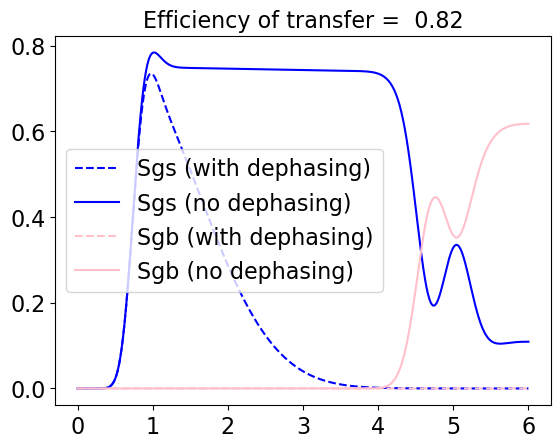

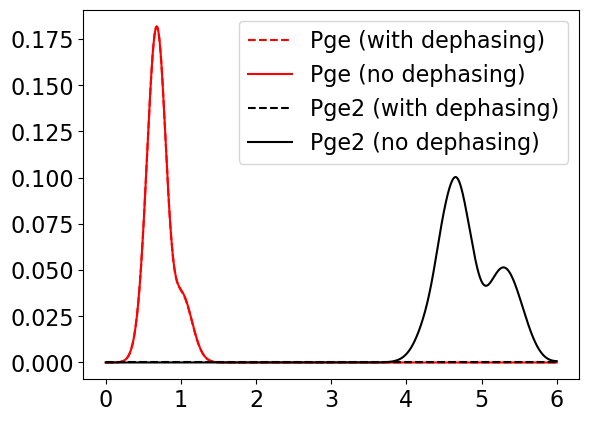

In [23]:
# A_M1 = 1 # units of 2*np.pi*1e9
# FWHM_M1 = 1 # units of tau
# t0_M1 = 1 # units of ns delay after t0
# delta_M1 = 0 # units of 2*np.pi*1e9

# A_M2 = 1 # units of 2*np.pi*1e9
# FWHM_M2 = 1 # units of tau
# t0_M2 = 1 # units of ns delay after t0
# delta_M2 = 0 # units of 2*np.pi*1e9

# x = np.array([t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2])

# [t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2] = x

[t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2] = xopt


protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = delta_M1*2*np.pi*1e9
deltaM2 = delta_M2*2*np.pi*1e9

L = 0.075

t0 = 1.5*tau
tend = 6e-9 #210e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Omega_store = 8e9

control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
M1_store = (S.gaussian(t, t0+t0_M1*1e-9, FWHM_M1*tau, 2*np.pi*1e9*A_M1))[:, None] * control_pol[None, :]
M2_store = (S.gaussian(t, t0+t0_M2*1e-9, FWHM_M2*tau, 2*np.pi*1e9*A_M2))[:, None] * control_pol[None, :]


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])


sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)
sol.gammaS = 1/480e-9
sol.gammaSNU = sol.gammaS/sol.gamma

Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
M2_tzp = sol.co_prop( M2_store )

Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

sol.solve(Controls, method='RK4-Ralston')

plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.ER[:, -1, 0]),2), color='black', label='Leaked bad signal intensity')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(Control_store[:, 0])**2, color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M1_store[:, 0])**2, color='green', label='M1 rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M2_store[:, 0])**2, color='orange', label='M2 rabi frequency\n (scaled)')
#plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('t (ns)')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()


Sgs_eff = np.array([sol.storage_efficiency(sol.Sgs, mi) for mi in range(m)])
Sgs_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgs[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Sgb_eff = np.array([sol.storage_efficiency(sol.Sgb, mi) for mi in range(m)])
Sgb_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Sgs_eff, label='Sgs (with dephasing)', color='b', linestyle='dashed')
plt.plot(t*1e9, Sgs_eff_ignore_phase, label='Sgs (no dephasing)', color='b')
plt.plot(t*1e9, Sgb_eff, label='Sgb (with dephasing)', color='pink', linestyle='dashed')
plt.plot(t*1e9, Sgb_eff_ignore_phase, label='Sgb (no dephasing)', color='pink')
plt.title(f'Efficiency of transfer = {Sgb_eff_ignore_phase[-1]/stored: .2f}')
plt.legend()
plt.show()


Pge_eff = np.array([sol.storage_efficiency(sol.Pge, mi) for mi in range(m)])
Pge_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Pge2_eff = np.array([sol.storage_efficiency(sol.Pge2, mi) for mi in range(m)])
Pge2_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge2[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Pge_eff, label='Pge (with dephasing)', color='r', linestyle='dashed')
plt.plot(t*1e9, Pge_eff_ignore_phase, label='Pge (no dephasing)', color='r')
plt.plot(t*1e9, Pge2_eff, label='Pge2 (with dephasing)', color='k', linestyle='dashed')
plt.plot(t*1e9, Pge2_eff_ignore_phase, label='Pge2 (no dephasing)', color='k')
plt.legend()
plt.show()

## Restrict mapping field amplitude more

In [24]:
algorithm = nlopt.GN_CRS2_LM

A_M1 = 0.55 # units of 2*np.pi*1e9
FWHM_M1 = 1 # units of tau
t0_M1 = 3 # units of ns delay after t0
delta_M1 = 0 # units of 2*np.pi*1e9

A_M2 = 0.55 # units of 2*np.pi*1e9
FWHM_M2 = 1 # units of tau
t0_M2 = 3.5 # units of ns delay after t0
delta_M2 = 0 # units of 2*np.pi*1e9

x = np.array([t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2])

optimiser = nlopt.opt(algorithm, len(x))
optimiser.set_max_objective(objective_function)

lb = np.array([0, 0.1, 0, -2, 0, 0.1, 0, -2])
ub = np.array([5, 3, 1, 2, 5, 3, 1, 2])
optimiser.set_lower_bounds(lb)
optimiser.set_upper_bounds(ub)

ftol = 1e-3
maxeval = 100
optimiser.set_ftol_rel(ftol)
optimiser.set_maxeval(maxeval)

xopt = optimiser.optimize(x)
result = optimiser.last_optimum_value()

print("xopt = ", xopt)
print("Efficiency = ", result)

xopt =  [3.   1.   0.55 0.   3.5  1.   0.55 0.  ]
Efficiency =  0.7834482876722139


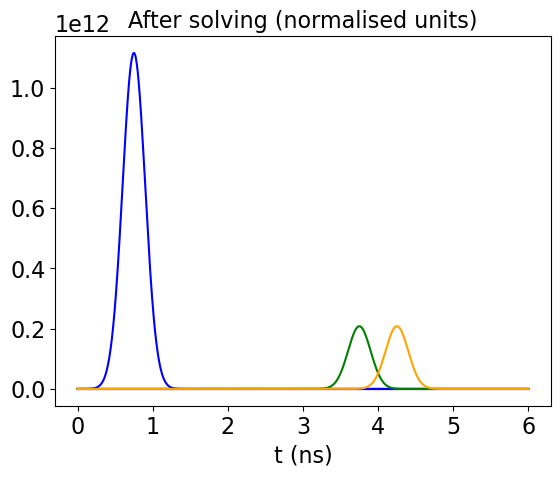

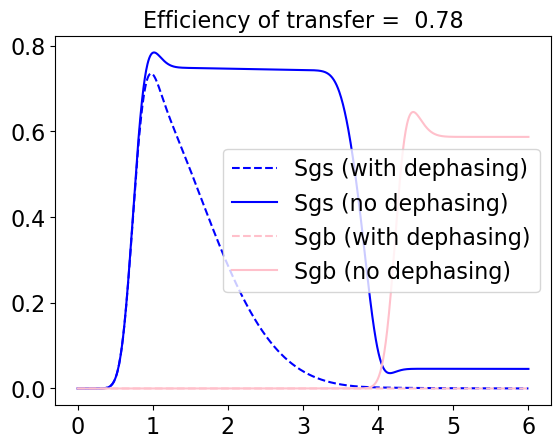

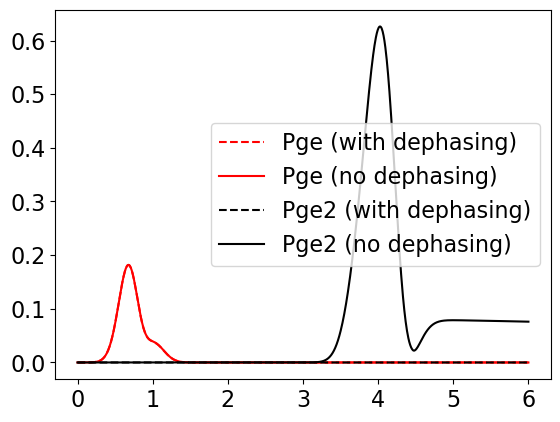

In [25]:
# A_M1 = 1 # units of 2*np.pi*1e9
# FWHM_M1 = 1 # units of tau
# t0_M1 = 1 # units of ns delay after t0
# delta_M1 = 0 # units of 2*np.pi*1e9

# A_M2 = 1 # units of 2*np.pi*1e9
# FWHM_M2 = 1 # units of tau
# t0_M2 = 1 # units of ns delay after t0
# delta_M2 = 0 # units of 2*np.pi*1e9

# x = np.array([t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2])

# [t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2] = x

[t0_M1, FWHM_M1, A_M1, delta_M1, t0_M2, FWHM_M2, A_M2, delta_M2] = xopt


protocol = 'ORCA_GSM'

OD = 10000
#BW = 2*np.pi*1e9
tau = 0.5e-9
n = 50
T = 273.15 + 90
vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning
deltaM1 = delta_M1*2*np.pi*1e9
deltaM2 = delta_M2*2*np.pi*1e9

L = 0.075

t0 = 1.5*tau
tend = 6e-9 #210e-9
tbounds = np.array([0, tend])

m = 1000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

Omega_store = 8e9

control_pol = np.array([1, 0])
Control_store = S.gaussian(t, t0, tau, Omega_store)[:, None] * control_pol[None, :]
M1_store = (S.gaussian(t, t0+t0_M1*1e-9, FWHM_M1*tau, 2*np.pi*1e9*A_M1))[:, None] * control_pol[None, :]
M2_store = (S.gaussian(t, t0+t0_M2*1e-9, FWHM_M2*tau, 2*np.pi*1e9*A_M2))[:, None] * control_pol[None, :]


Sinits = np.array([np.zeros((n, 1, 1, 1, 1, vno)), np.zeros((n, 1, 1, 1, 1, vno))])


sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC, deltaM1, deltaM2], OD, L, n, m, tbounds, T, vno)
sol.gammaS = 1/480e-9
sol.gammaSNU = sol.gammaS/sol.gamma

Control_tzp = sol.counter_prop( Control_store, zdef=0.5, field=0)
M1_tzp = sol.counter_prop( M1_store, zdef=0.5, field=1)
M2_tzp = sol.co_prop( M2_store )

Controls = np.array([Control_tzp, M1_tzp, M2_tzp])

sol.solve(Controls, method='RK4-Ralston')

plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
plt.plot(t*1e9, pow(np.abs(sol.ER[:, -1, 0]),2), color='black', label='Leaked bad signal intensity')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(Control_store[:, 0])**2, color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M1_store[:, 0])**2, color='green', label='M1 rabi frequency\n (scaled - half way through cell)')
plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega_store)*np.abs(M2_store[:, 0])**2, color='orange', label='M2 rabi frequency\n (scaled)')
#plt.vlines(t[mcut]*1e9, 0, 2*max(pow(np.abs(sol.E[:, 0, 0]), 2)), color = 'black', linestyles='dashed')
plt.title('After solving (normalised units)')
plt.xlabel('t (ns)')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
plt.show()


Sgs_eff = np.array([sol.storage_efficiency(sol.Sgs, mi) for mi in range(m)])
Sgs_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgs[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Sgb_eff = np.array([sol.storage_efficiency(sol.Sgb, mi) for mi in range(m)])
Sgb_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Sgb[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Sgs_eff, label='Sgs (with dephasing)', color='b', linestyle='dashed')
plt.plot(t*1e9, Sgs_eff_ignore_phase, label='Sgs (no dephasing)', color='b')
plt.plot(t*1e9, Sgb_eff, label='Sgb (with dephasing)', color='pink', linestyle='dashed')
plt.plot(t*1e9, Sgb_eff_ignore_phase, label='Sgb (no dephasing)', color='pink')
plt.title(f'Efficiency of transfer = {Sgb_eff_ignore_phase[-1]/stored: .2f}')
plt.legend()
plt.show()


Pge_eff = np.array([sol.storage_efficiency(sol.Pge, mi) for mi in range(m)])
Pge_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])

Pge2_eff = np.array([sol.storage_efficiency(sol.Pge2, mi) for mi in range(m)])
Pge2_eff_ignore_phase = np.array([np.trapz( 
                    np.einsum('zghqw -> z', 
                                pow(np.einsum('v, zghqwv -> zghqw', np.sqrt(sol.MB(sol.vs)*sol.dvs), np.abs( np.nan_to_num(sol.Pge2[mi], nan=0.0))),2)), 
                                sol.zCheby)  for mi in range(m)])


plt.plot(t*1e9, Pge_eff, label='Pge (with dephasing)', color='r', linestyle='dashed')
plt.plot(t*1e9, Pge_eff_ignore_phase, label='Pge (no dephasing)', color='r')
plt.plot(t*1e9, Pge2_eff, label='Pge2 (with dephasing)', color='k', linestyle='dashed')
plt.plot(t*1e9, Pge2_eff_ignore_phase, label='Pge2 (no dephasing)', color='k')
plt.legend()
plt.show()